### **1. Import necessary libraries and modules**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

from custom_loss_functions import SCCE, SCCEInverse, SCCEMinMaxBin, SCCEMaxBin, SCCEDifference
from custom_layers import DefaultDense, RowWiseQuantized, RowWiseQuantizedSTE, ColumnWiseQuantized, ColumnWiseQuantizedSTE
from custom_callbacks import ScaleTrackingCallback, AccuracyTrackingCallBack, LossTrackingCallbackNew
from utils import print_model_structure, count_unique_values, count_unique_values_and_plot_histograms, count_unique_values_2

from datetime import datetime

from plot_scripts import plot_loss

/Users/anuunchinbat/Desktop/Thesis/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### **2. Import MNIST data:**

In [2]:
# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

### **3. Define model layers**

The custom `RowWiseQuantizedSTE` can be replaced with other custom layer classes. Refer to `custom_layers.py`.

In [3]:
def initialize_quantized_model(input_shape = (28, 28, 1)):
    input_layer = Input(shape=input_shape)
    flatten_layer = Flatten()(input_layer)
    quantized_dense_layer = RowWiseQuantized(128)(flatten_layer)
    quantized_dense_layer_2 = tf.keras.activations.relu(quantized_dense_layer)
    output_layer = RowWiseQuantized(10)(quantized_dense_layer_2)
    output_layer_2 = tf.keras.activations.softmax(output_layer)
    quantized_model = Model(inputs=input_layer, outputs=output_layer_2)

    return quantized_model

### **4. Print model structure for timely inspection**

In [4]:
def prepare_model_dir(model, penalty_rate, run_timestamp):
    log_dir = f'logs/{run_timestamp}_pr_{penalty_rate}'
    os.makedirs(log_dir)
    print_model_structure(model, log_dir, filename="quantized_model_structure.txt")
    return log_dir

### **5. Initialize a custom loss function and compile the model**
The `SCCEMinMaxBin` can be replaced with other loss function objects. Refer to `custom_loss_functions.py`. Note that only `SCCEMinMaxBin` and `SCCEMaxBin` take the `row_wise` argument.

In [5]:
def initialize_loss_function(model, penalty_rate, log_dir, loss_func = SCCEMaxBin):
    # Initialize your custom loss function
    loss_function = loss_func(
        layers=[
            model.get_layer(index=2),
            model.get_layer(index=4)
        ],
        penalty_rate=penalty_rate,
        row_wise=1,
        log_dir = log_dir  # 1 = True = scale factor values are applied row-wise, must match the used custom layer (RowWiseQuantized)
                # 0 = False = scale factor values are applied column-wise, must match the used custom layer (ColumnWiseQuantized)
    )
    return loss_function


def compile_model(model, learning_rate, loss_function):
    # Compile your models
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_function.compute_total_loss,
        metrics=['accuracy']
    )

### **6. Initialize callbacks, train and evaluate the model**

In [6]:
def initialize_callbacks(model, loss_function, log_dir, validation_data):
    # Initialize your callbacks
    scale_tracking_callback_first_dense_layer = ScaleTrackingCallback(model.get_layer(index=2), log_dir)
    scale_tracking_callback_second_dense_layer = ScaleTrackingCallback(model.get_layer(index=4), log_dir)
    penalty_callback = LossTrackingCallbackNew(loss_function=loss_function, validation_data=validation_data, interval=val_interval, log_dir=log_dir)
    accuracy_callback = AccuracyTrackingCallBack(model.get_layer(index=4), log_dir)

    # Return callbacks as a dictionary
    callbacks = {
        'scale_tracking_callback_first_dense_layer': scale_tracking_callback_first_dense_layer,
        'scale_tracking_callback_second_dense_layer': scale_tracking_callback_second_dense_layer,
        'penalty_callback': penalty_callback,
        'accuracy_callback': accuracy_callback
    }

    return callbacks

def train_model(model, epochs, validation_data, batch_size, **callbacks):
    # Train your model
    model.fit(
        x_train, y_train,
        epochs=epochs,
        validation_data=validation_data,
        callbacks=list(callbacks.values()),  
        batch_size=batch_size
    )

def evaluate_model(model):
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f'Quantized Model Test Accuracy: {accuracy}')
    return accuracy

In [7]:
start = 0.000001
end =   0.0001
step =  0.000001

penalty_rates = [start + i * step for i in range(int((end - start) / step) + 1)]
print(len(penalty_rates))

100



--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x16a4a81c0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x16a4ceb80>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x16a55d0a0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x16a55db80>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x16a55d670>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x1753b1670>
  - Input Shape: (None, 10)

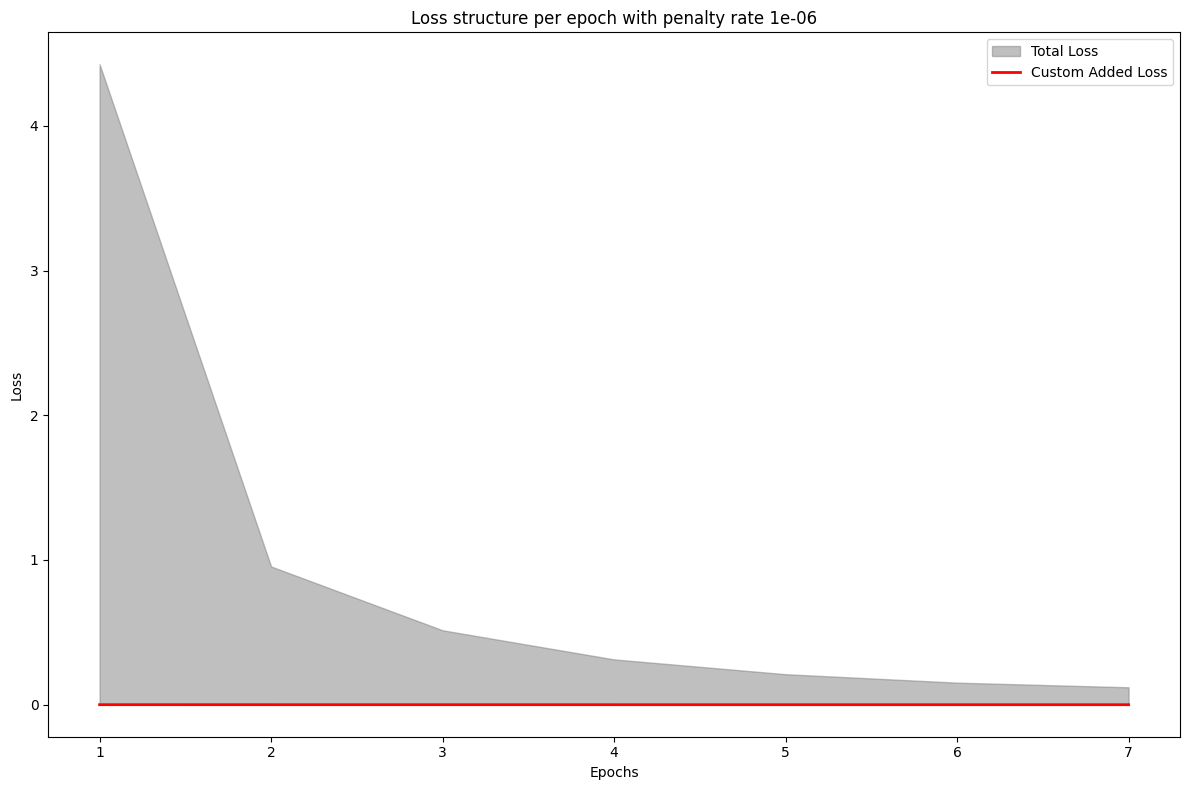


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x31882da30>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x31881f100>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x31882de50>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x1753b18b0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x31881f2e0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x31aa26040>
  - Input Shape: (None, 10)

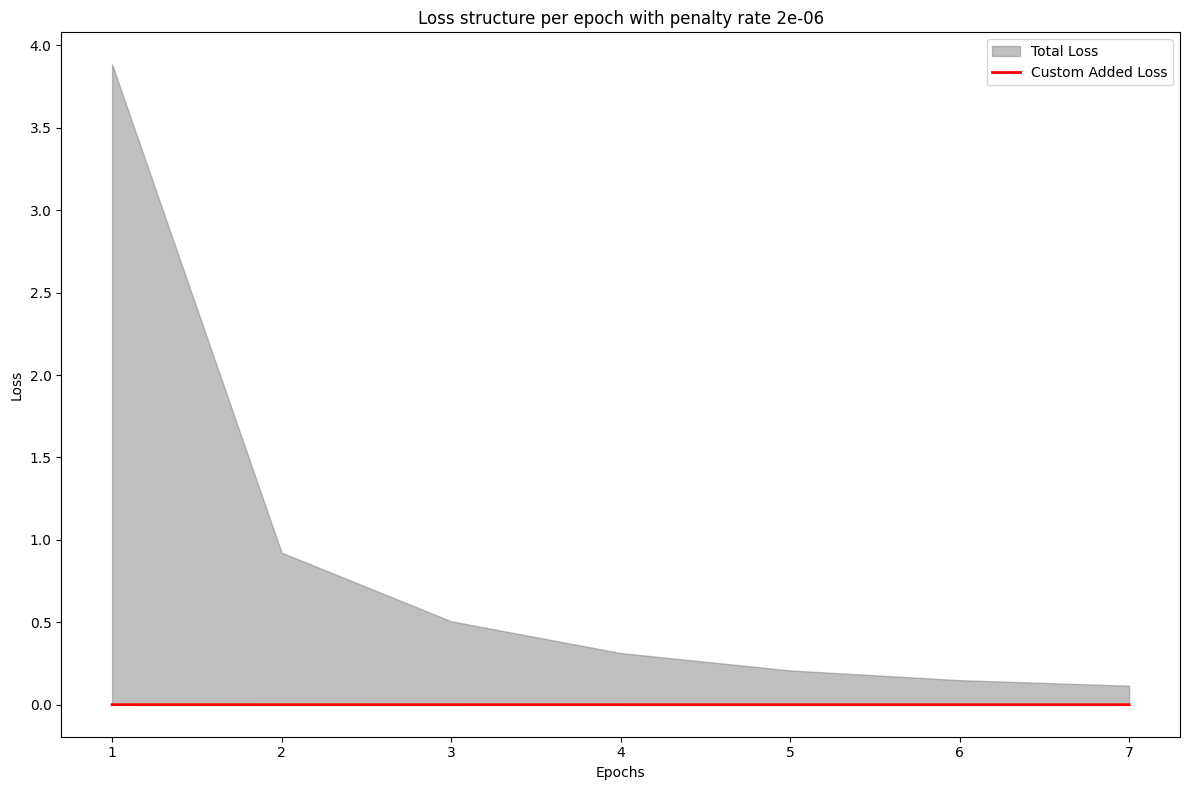


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3188fd5b0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3187db9d0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3185b9f10>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3185227f0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3184d8340>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x318522640>
  - Input Shape: (None, 10)

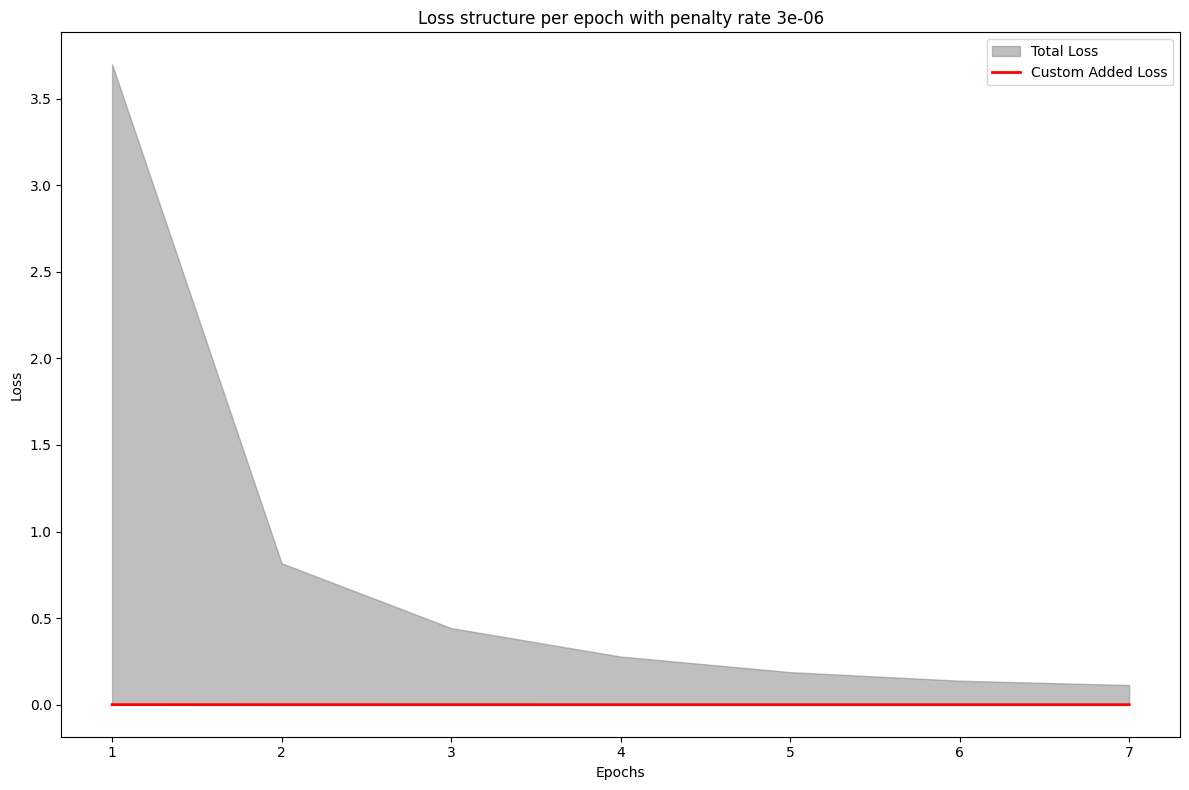


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x177731100>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3154c0820>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x343e5f9a0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x342614580>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x342627b80>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3426bc730>
  - Input Shape: (None, 10)

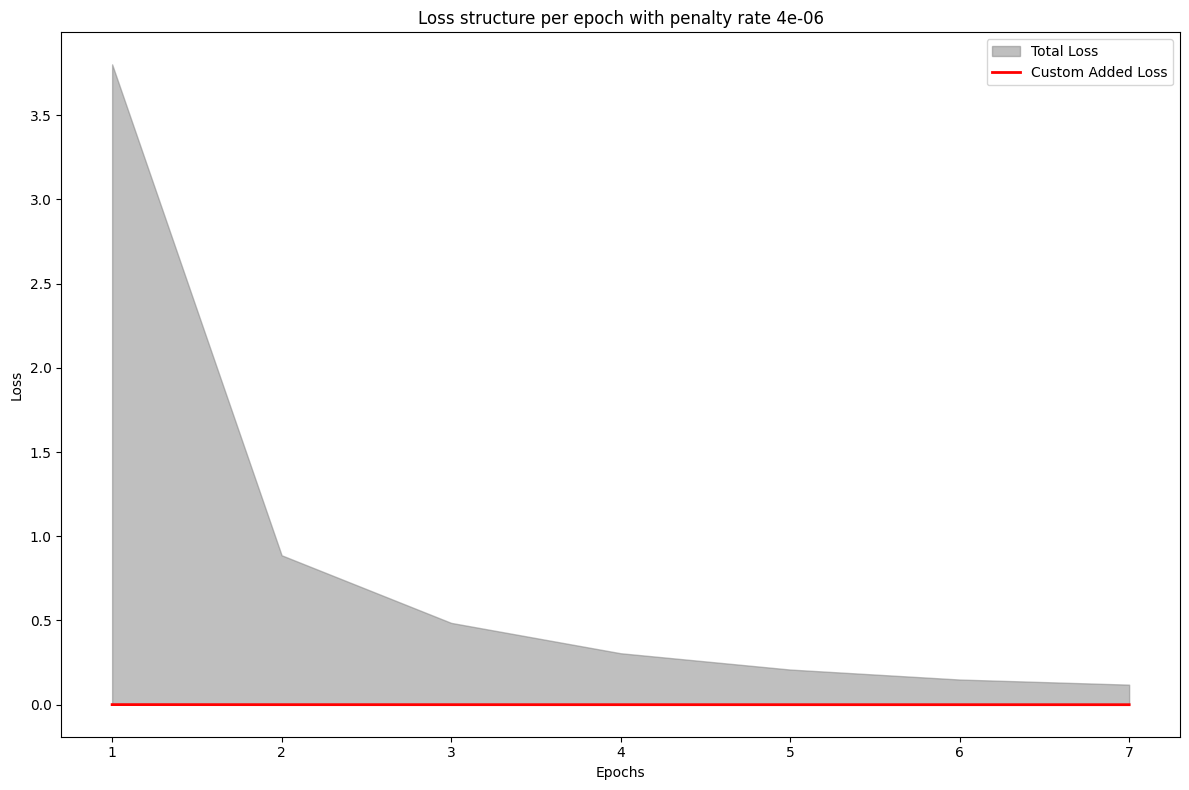


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3426afdc0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3425f50a0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x318876d90>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x34261e370>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x343e21250>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3426273d0>
  - Input Shape: (None, 10)

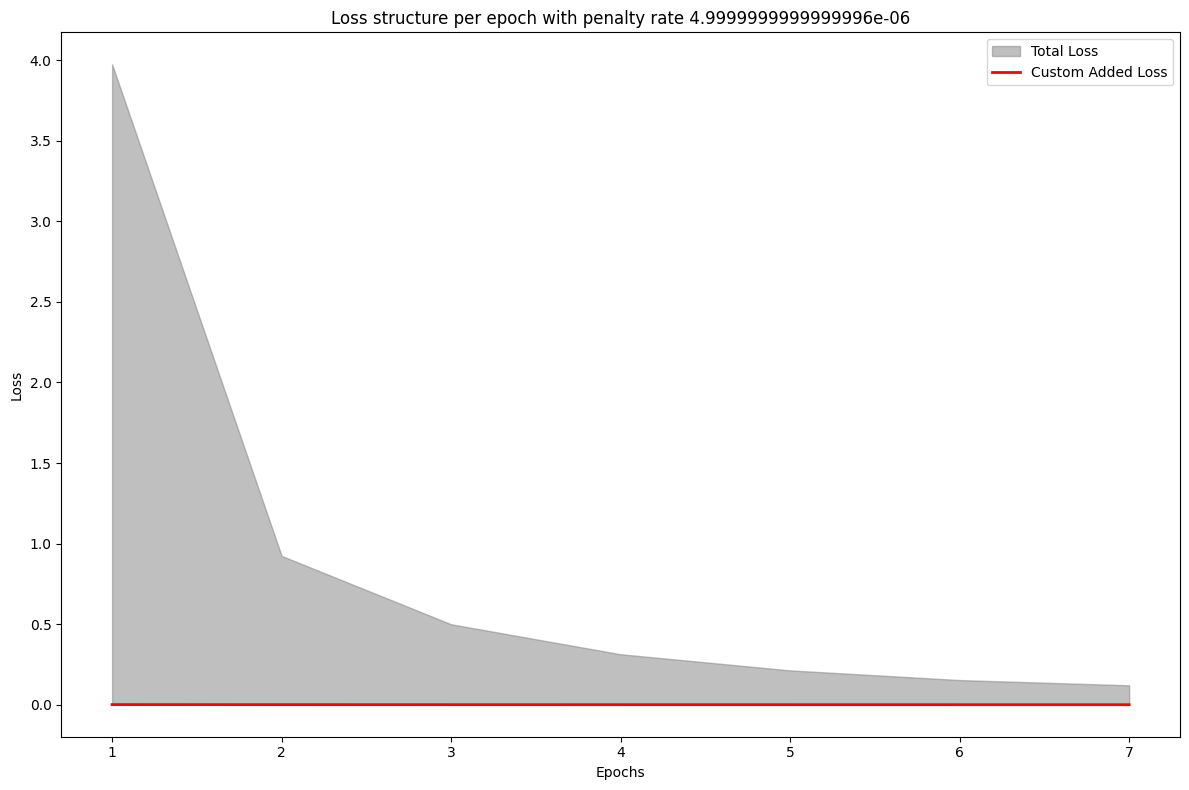


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x342585af0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x380cb07f0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x31859bd30>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x343e30f10>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3185799d0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x318728dc0>
  - Input Shape: (None, 10)

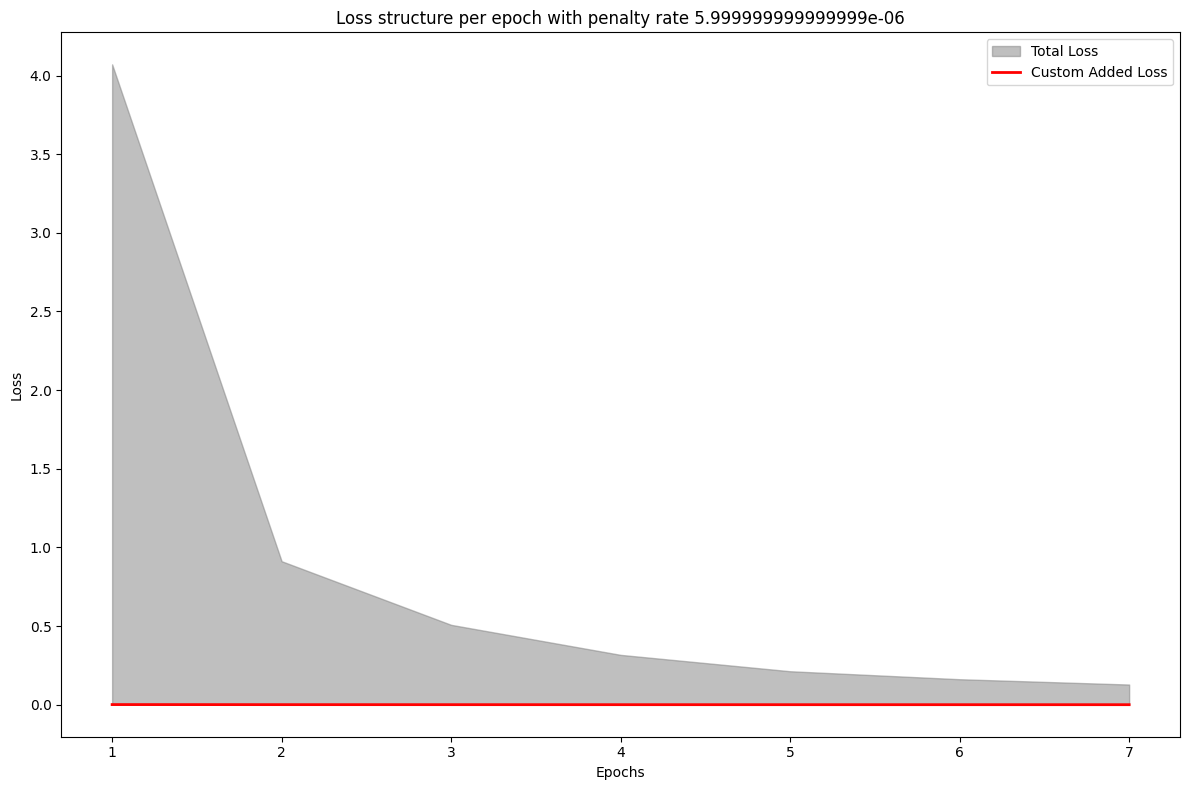


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x15f99e430>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x175f564f0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3185cf910>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x31882bd90>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3185cf220>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x175f4cfa0>
  - Input Shape: (None, 10)

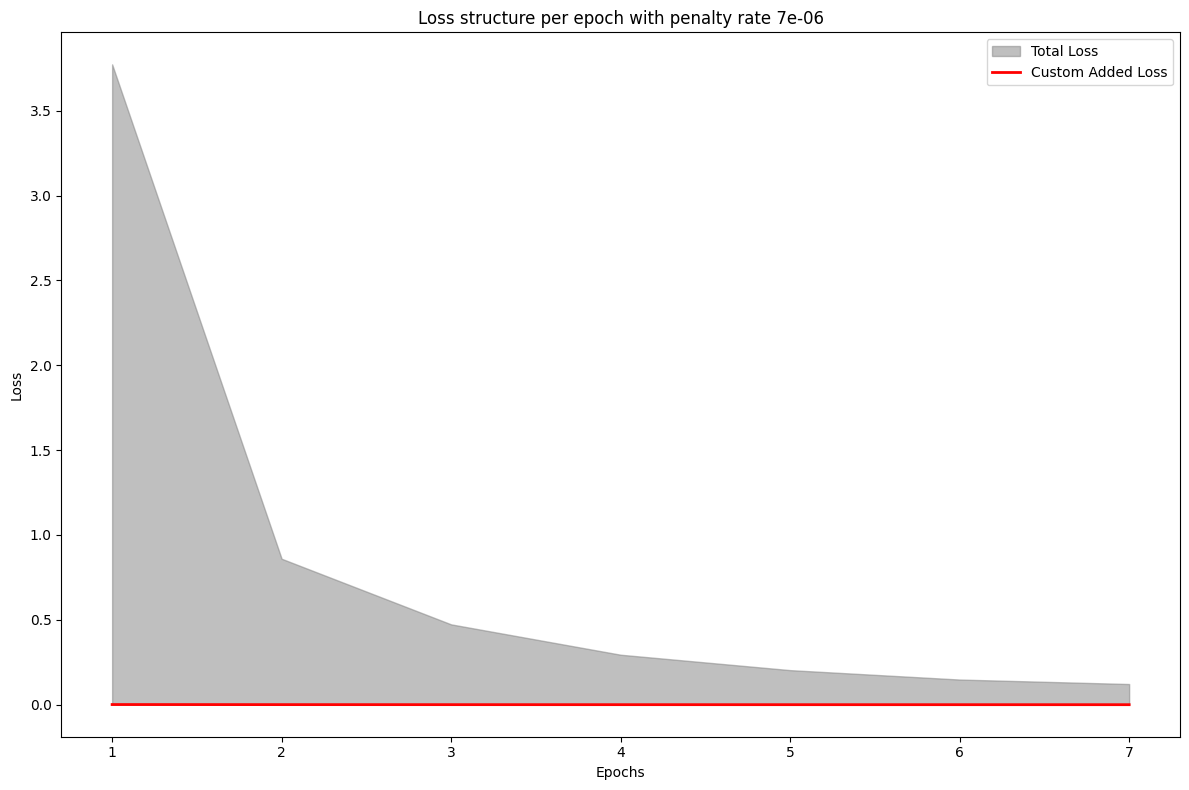


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3886c34c0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x34257fee0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x31884f0d0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x318592a30>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x318592c10>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x343e4e850>
  - Input Shape: (None, 10)

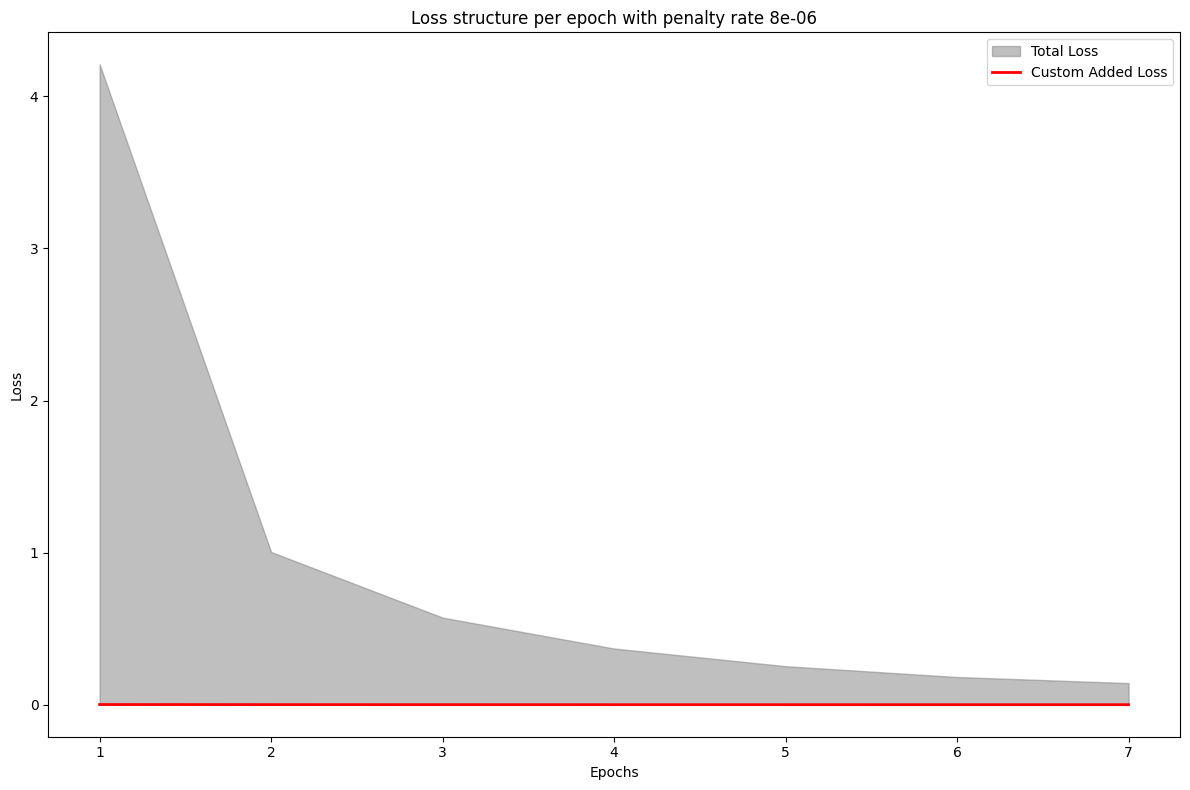


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x380bcca00>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x177628580>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x36e662af0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x380ec8310>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x17688fb20>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x176880940>
  - Input Shape: (None, 10)

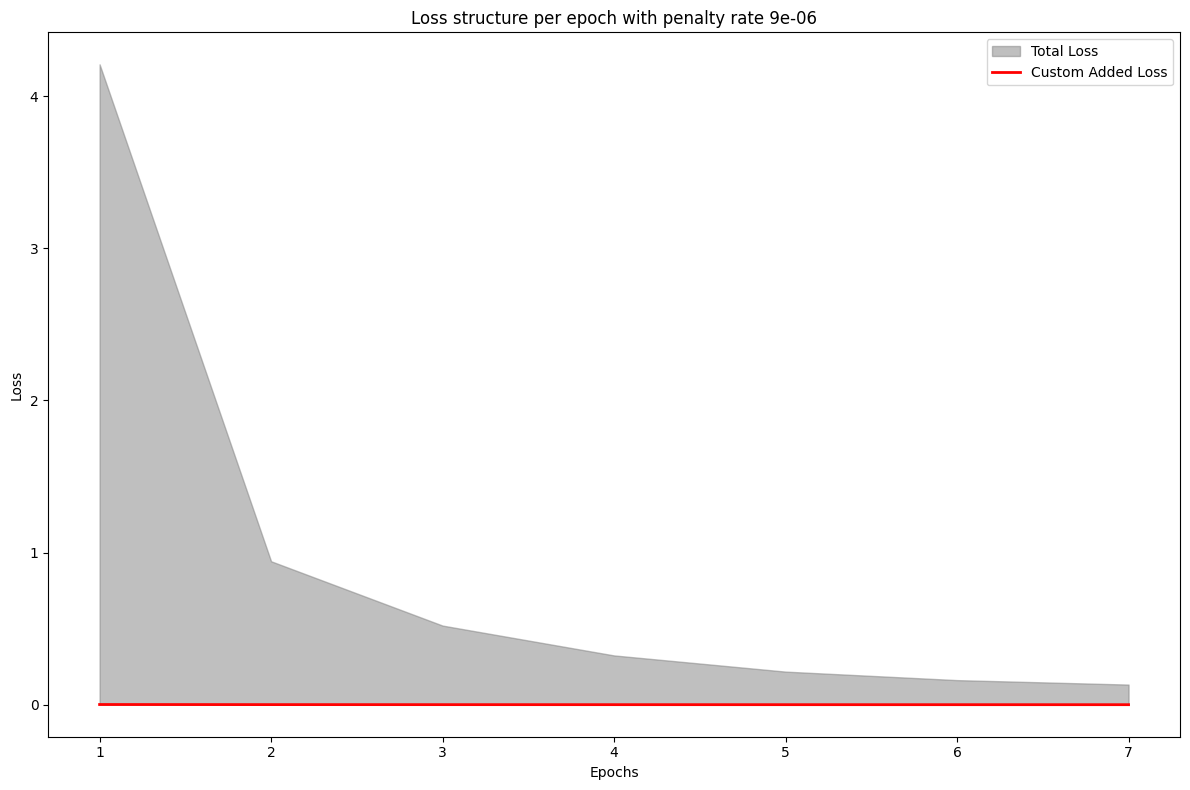


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x318592c40>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x17599c940>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3187a7520>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3185508b0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3424c2af0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x380cac3d0>
  - Input Shape: (None, 10)

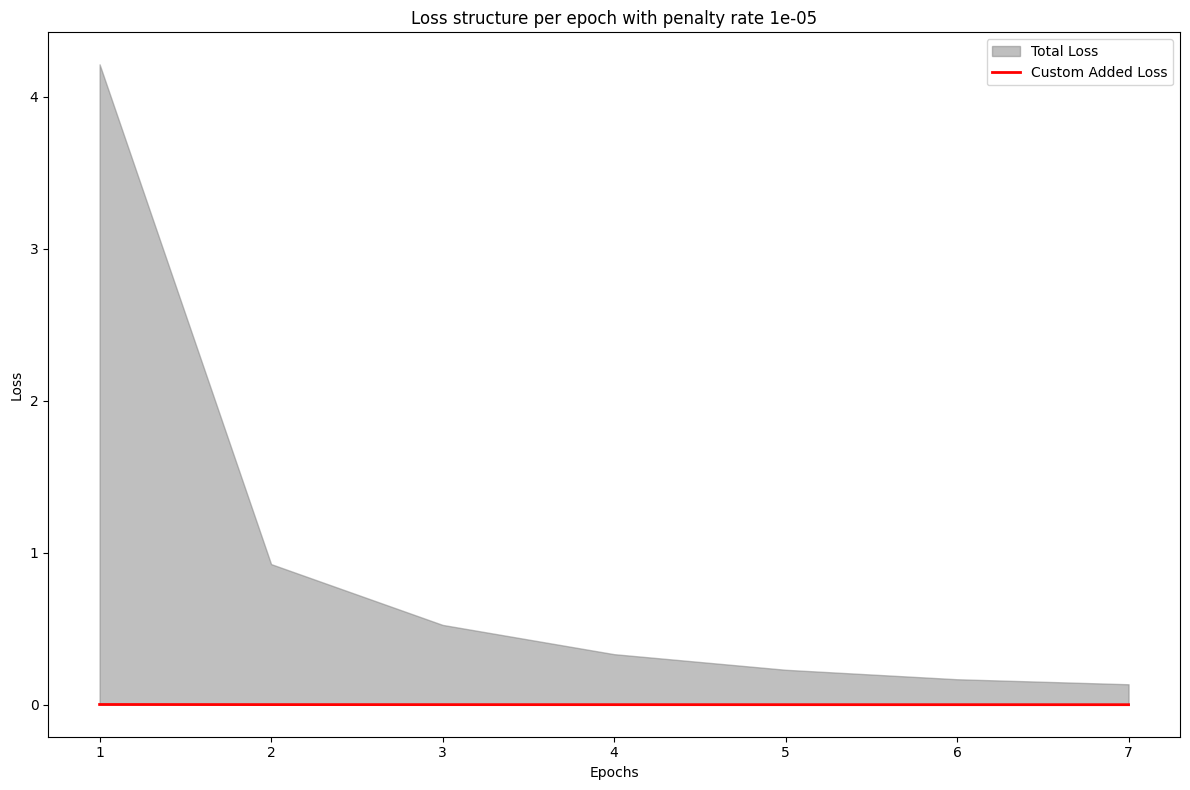


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x318736f10>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x31aa658b0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x30c5545e0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x31aadb430>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x31846ae80>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3510e63a0>
  - Input Shape: (None, 10)

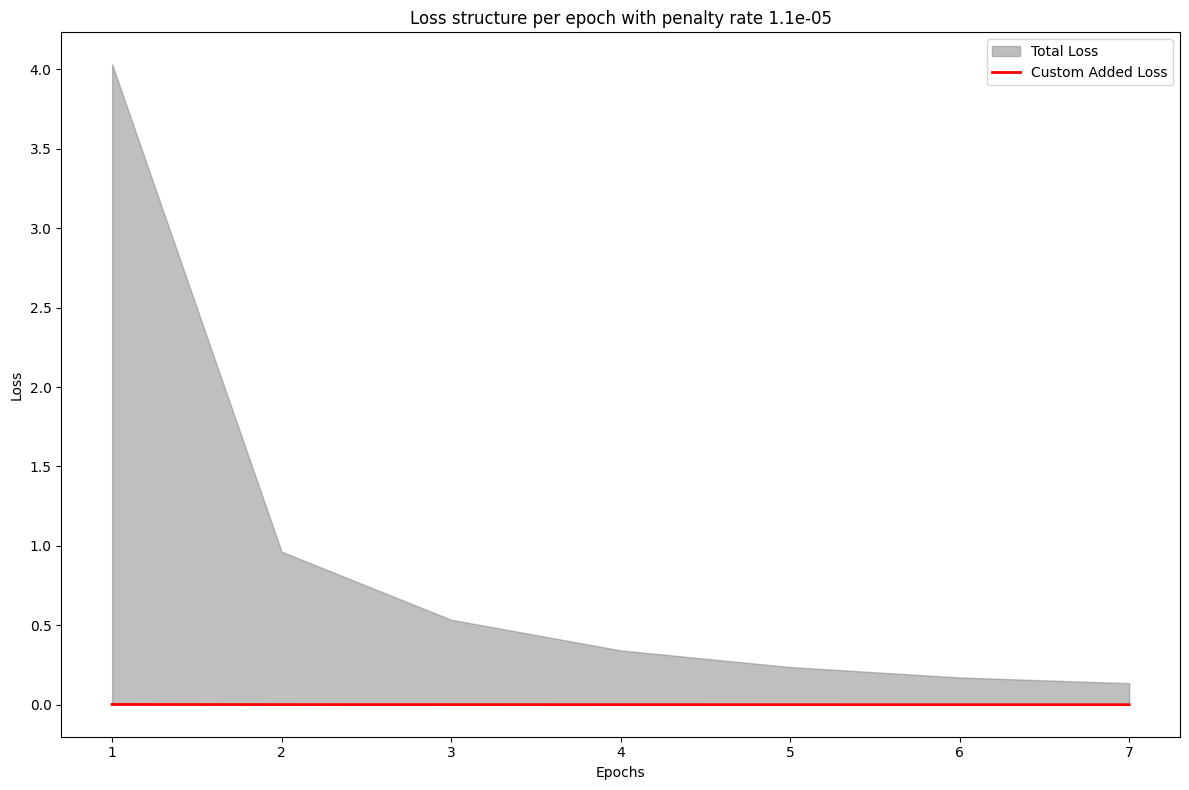


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x31876c4c0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x36a0791f0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x380cacf40>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x380e350d0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x17687be50>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x17686a3a0>
  - Input Shape: (None, 10)

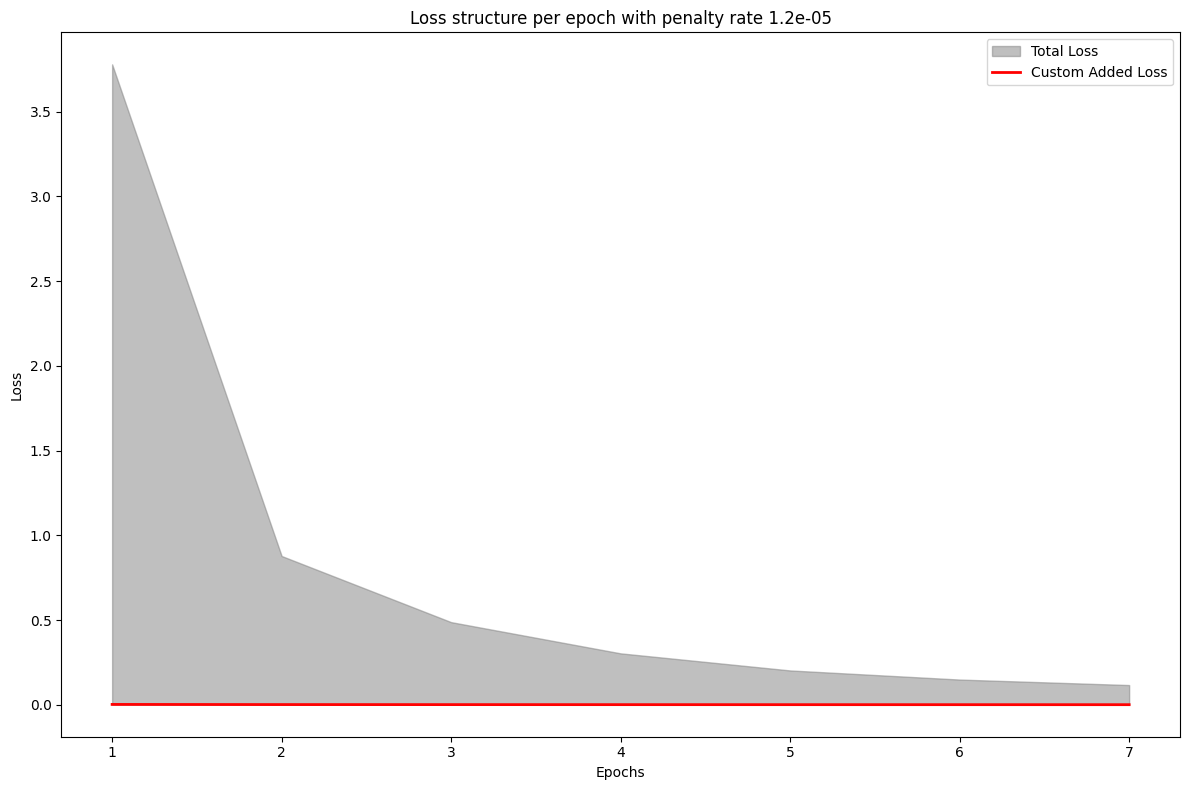


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x380c78f70>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x175f4ca60>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x380c1aa30>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3185a5850>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x347a9ddc0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x1776b82b0>
  - Input Shape: (None, 10)

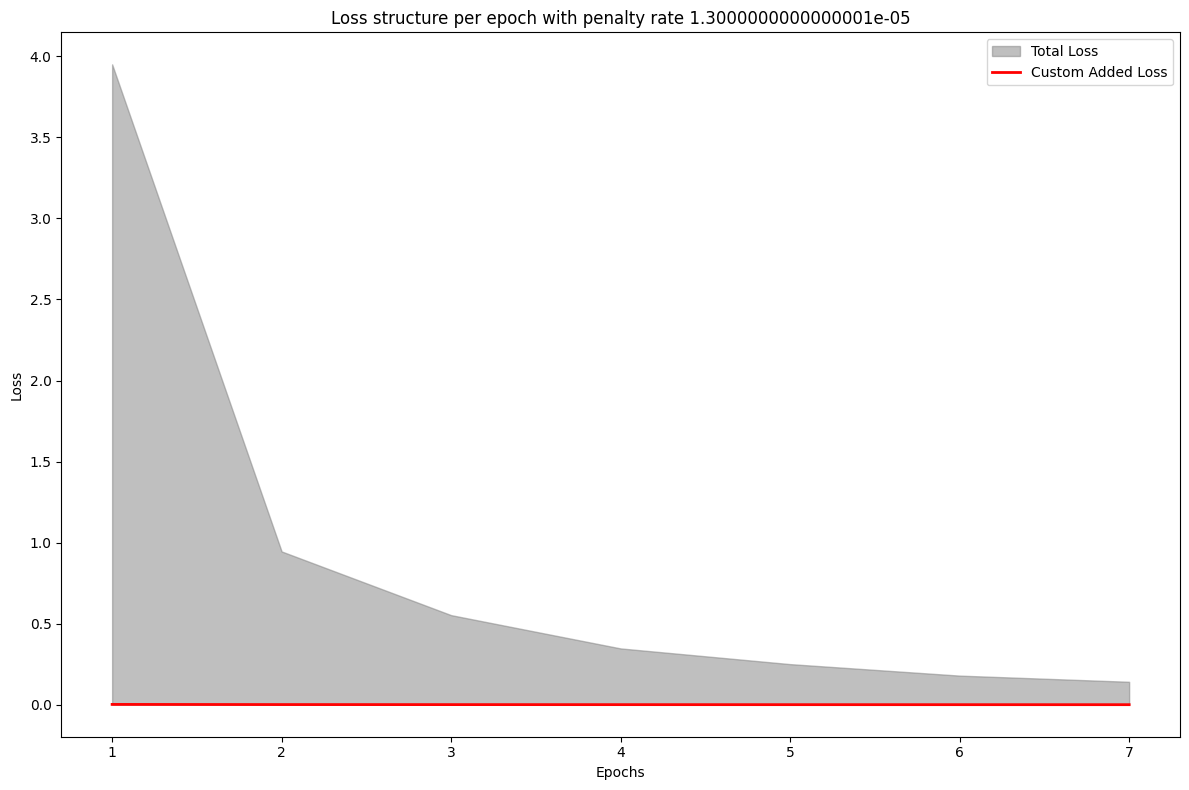


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x31871af40>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x386f5b0a0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x380b4b640>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x314472610>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x386f794c0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x386f30fd0>
  - Input Shape: (None, 10)

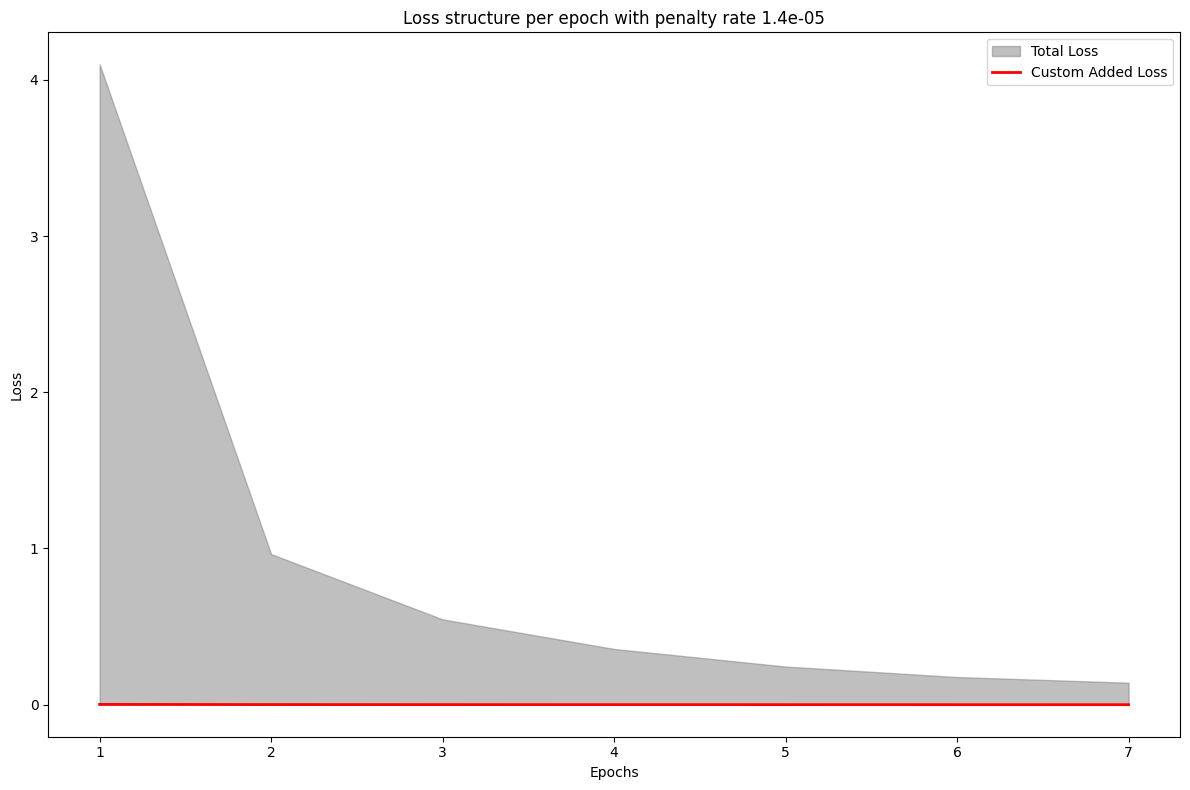


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x380c1af40>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x177628e80>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3187ee7f0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x343e44700>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x388d3a880>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x318438c40>
  - Input Shape: (None, 10)

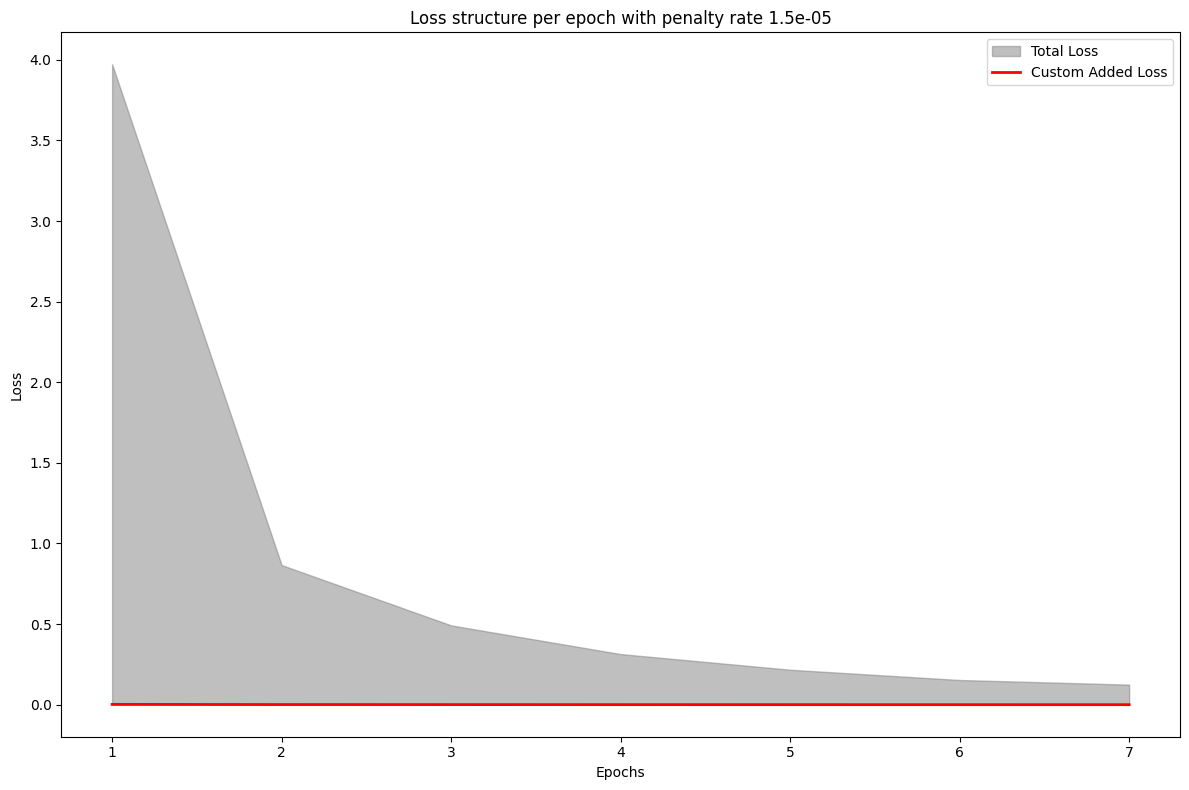


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3424e3c10>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x314b2f520>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x36e651520>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x175f6a880>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x314b2f970>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x31884b730>
  - Input Shape: (None, 10)

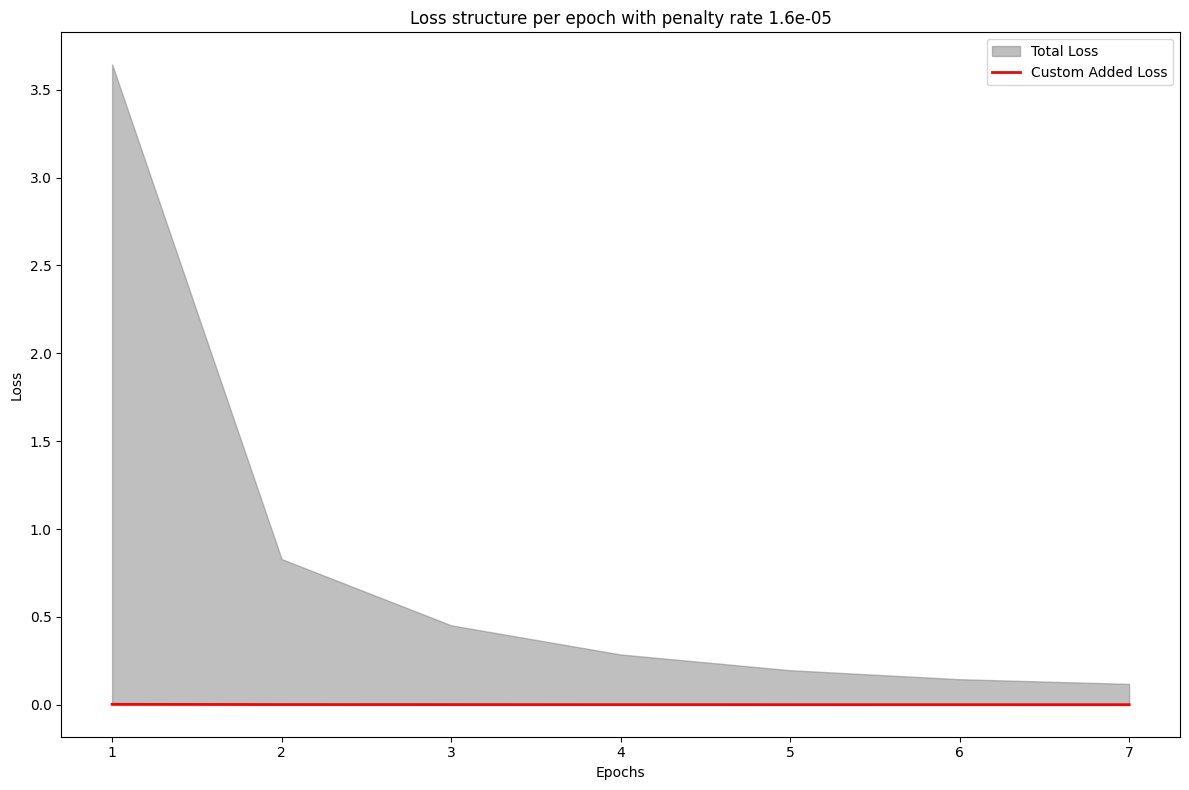


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x380b7ebb0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3a3e07f10>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x31aaa89a0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x36a086a90>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x36a0f97c0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3a3b02c70>
  - Input Shape: (None, 10)

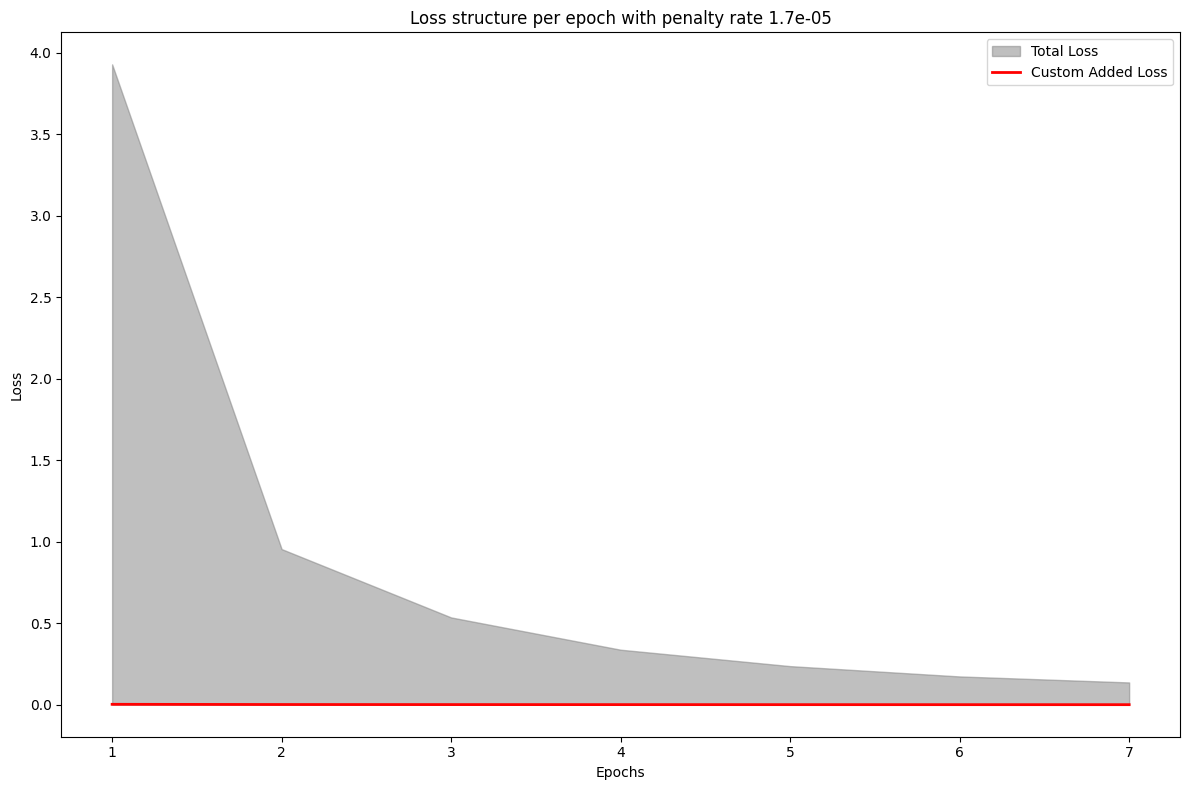


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x347ca4af0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x175dc6f10>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3424c20d0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x366f7ff10>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x1753c57f0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x30f03de50>
  - Input Shape: (None, 10)

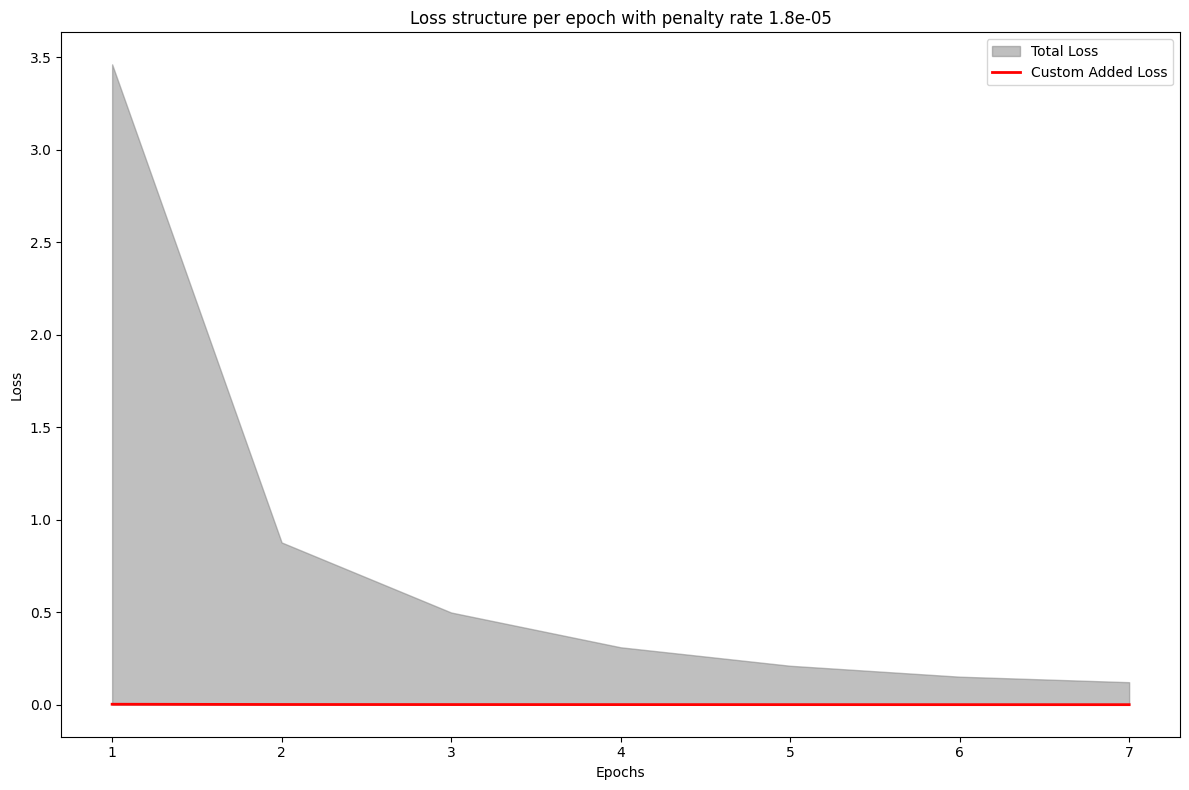


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x343e53820>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3423557f0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x31aab50a0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3aa61d310>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x31885c880>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x388416a60>
  - Input Shape: (None, 10)

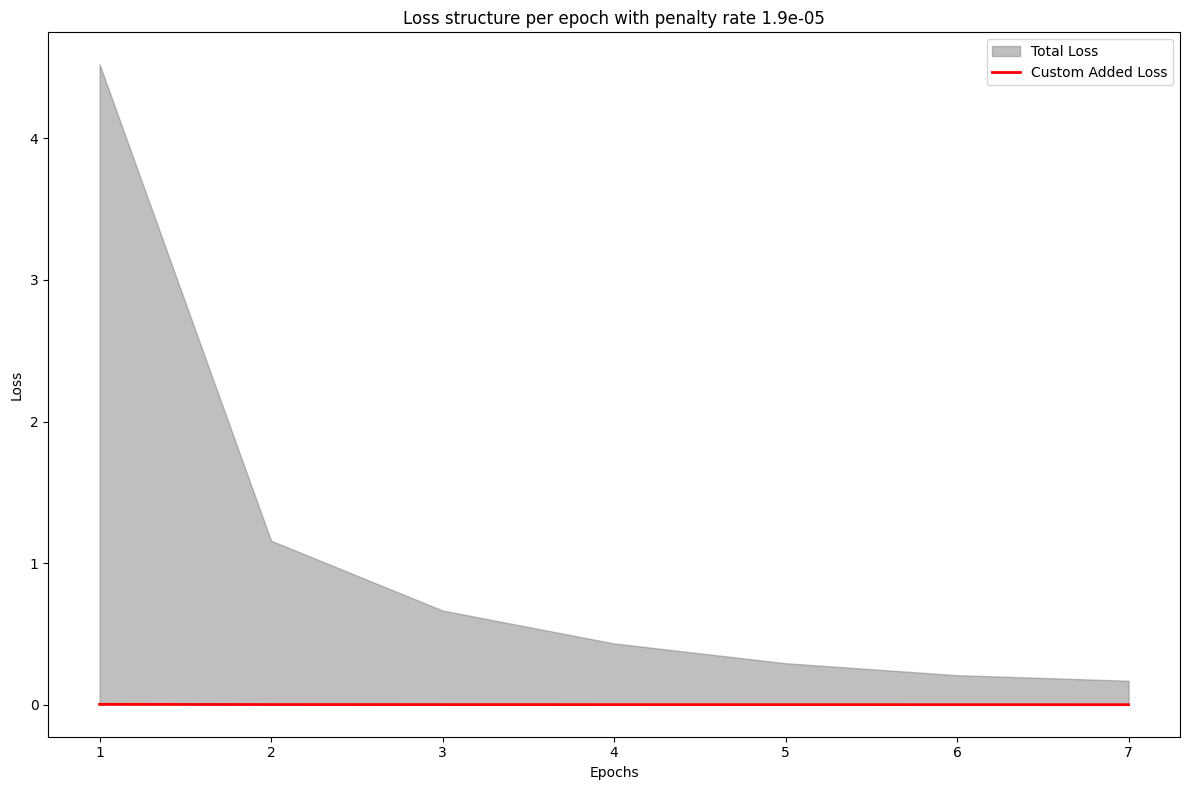


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x380e86100>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x39c66d250>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x30f4e8970>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x39c66d4c0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3187428e0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x39c854970>
  - Input Shape: (None, 10)

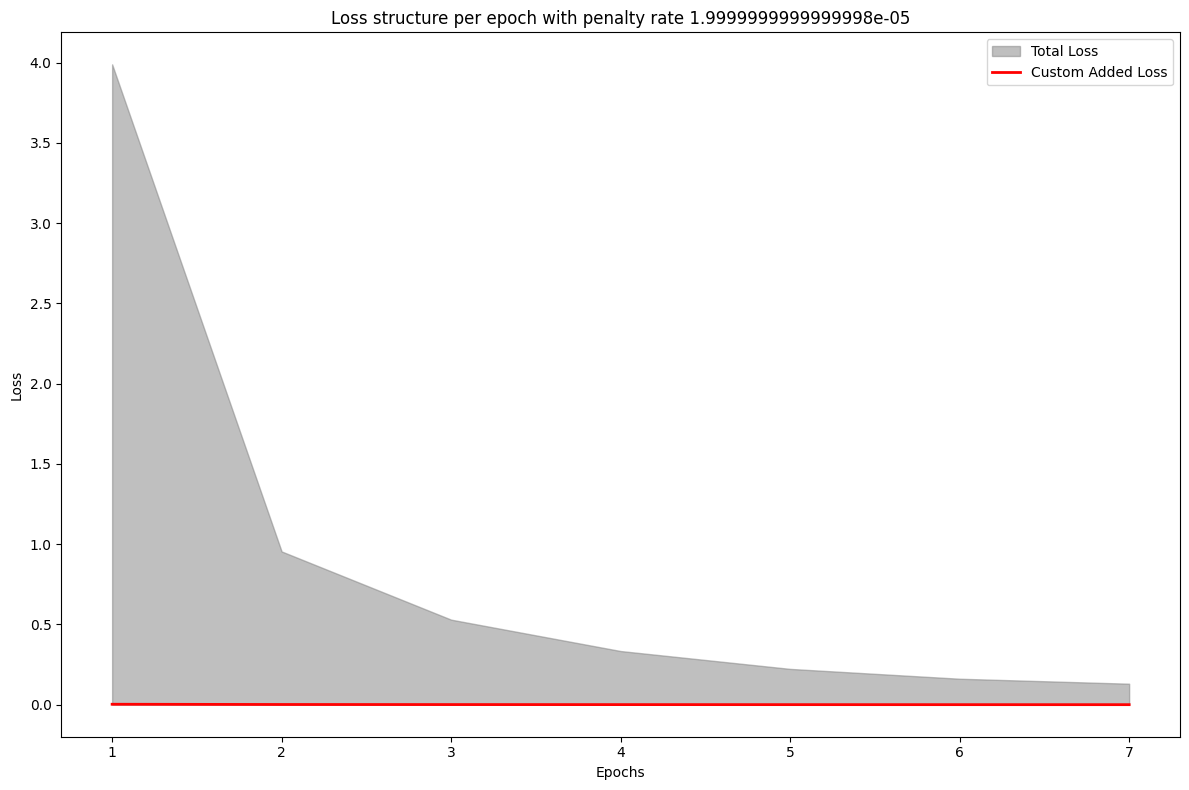


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x345c69b80>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3154c5070>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x345b73040>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x31846a1c0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x175fefd30>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x30f4e86a0>
  - Input Shape: (None, 10)

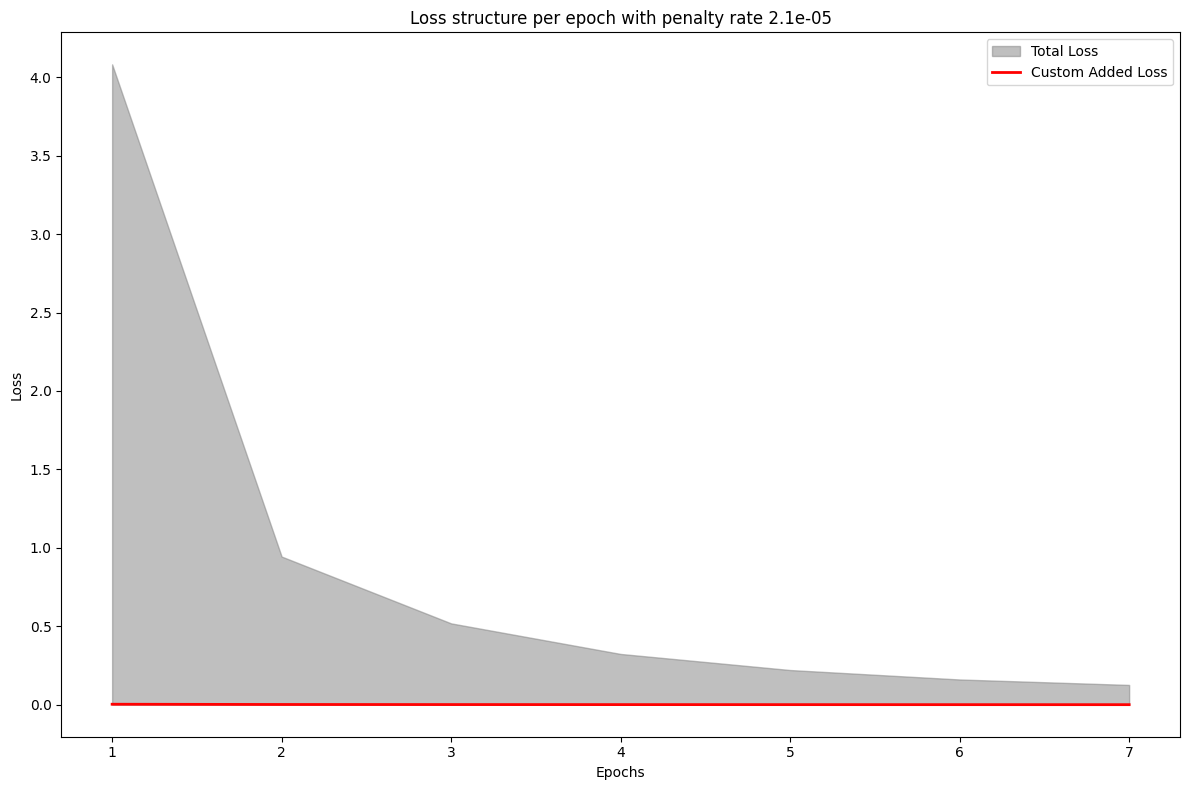


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x31845f9d0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x30f073eb0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x39cb3b610>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x39ca02250>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x30c5549d0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x39ca0aeb0>
  - Input Shape: (None, 10)

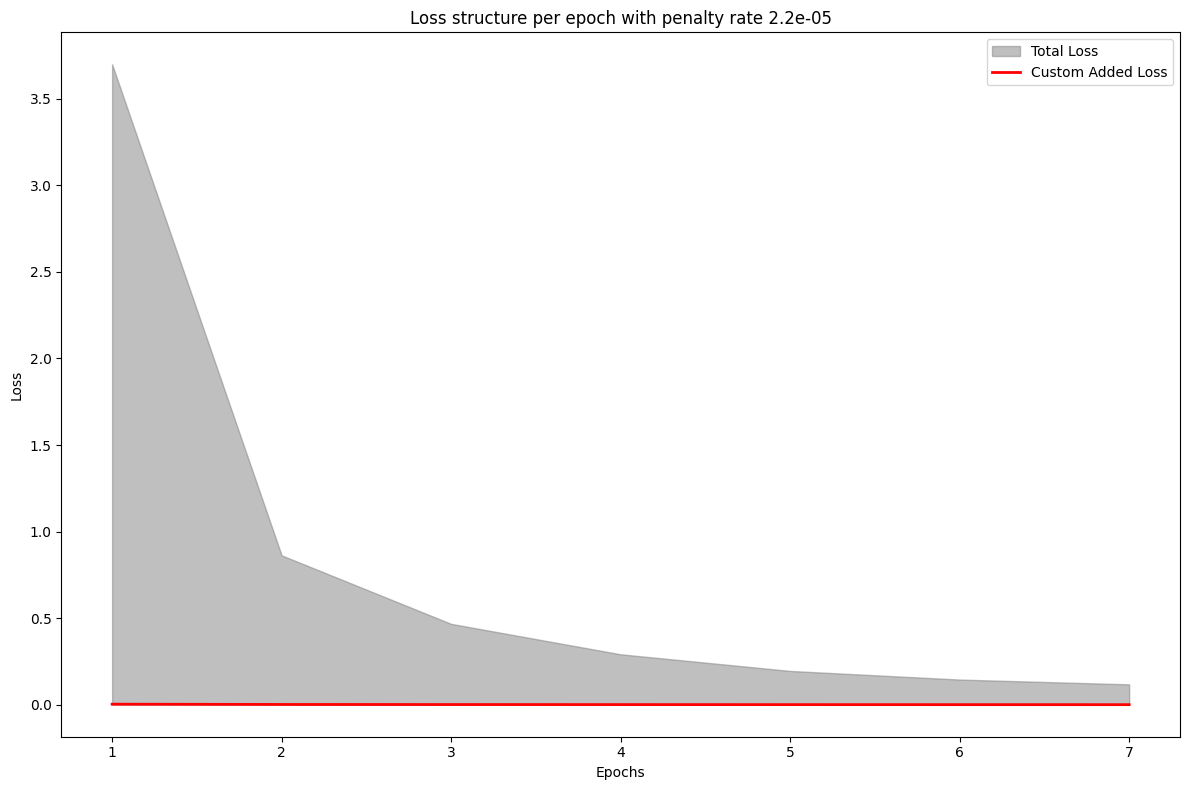


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x39c8d7d30>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3a4d39820>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3aa6d8b20>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x16a598460>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3144696a0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x314408730>
  - Input Shape: (None, 10)

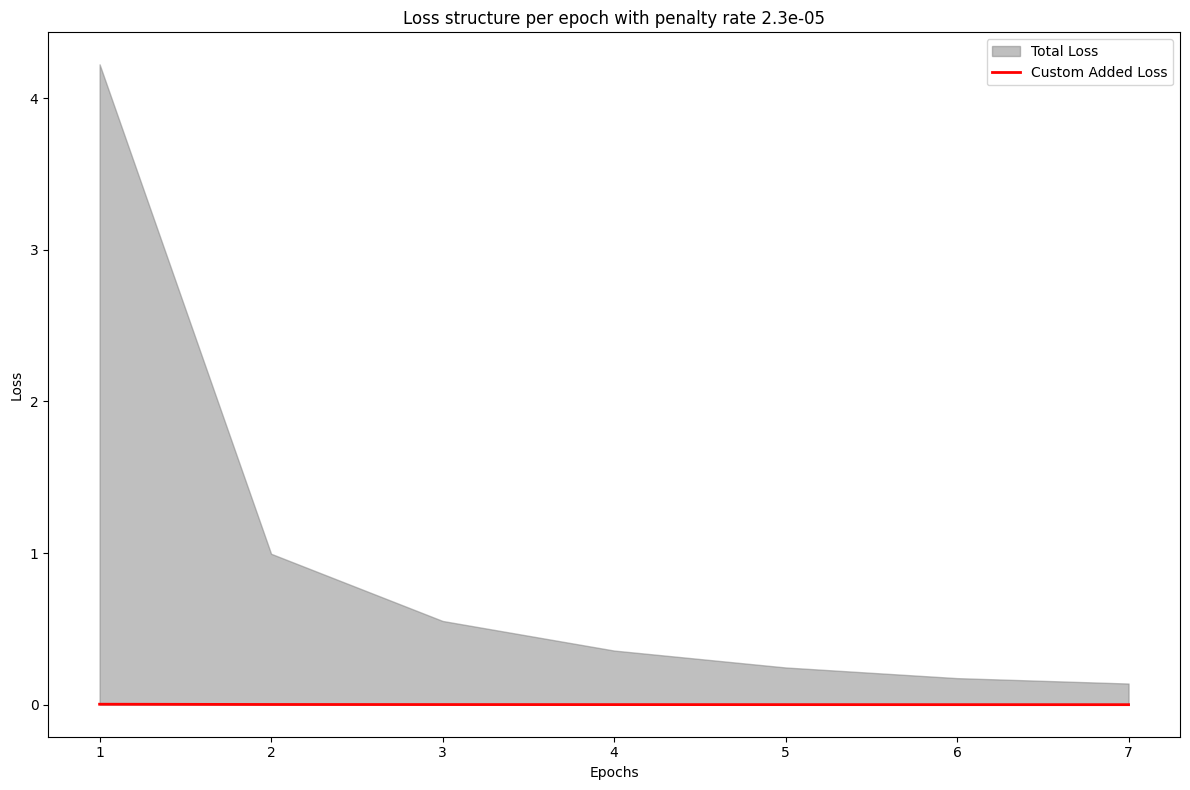


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x31a766550>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x175f51d90>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x351048820>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3a4d46d30>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x31445d7f0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x380e1bdc0>
  - Input Shape: (None, 10)

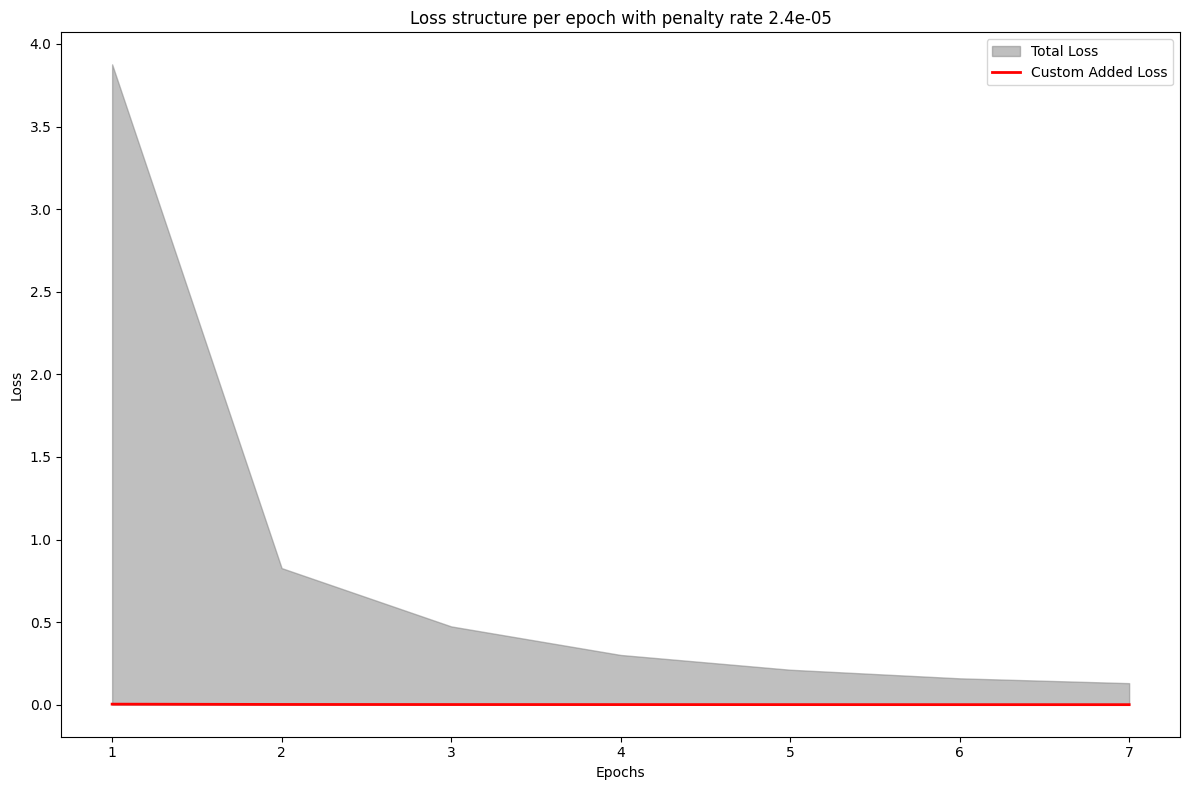


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x380583a60>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3a4d70b50>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x177628ee0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x380e57370>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x39c616a30>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x380ec8850>
  - Input Shape: (None, 10)

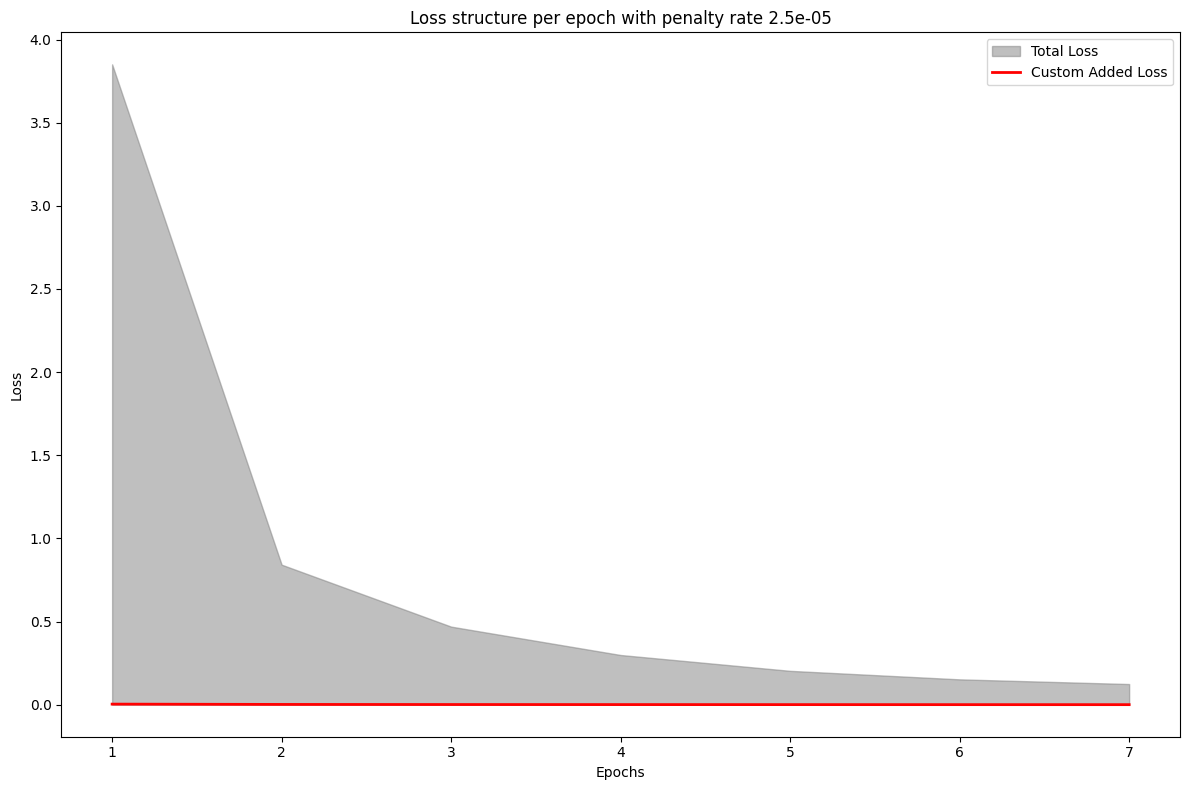


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x314b36be0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3650549a0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x36504d1f0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x345b6d160>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x36504d850>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x39ca64f10>
  - Input Shape: (None, 10)

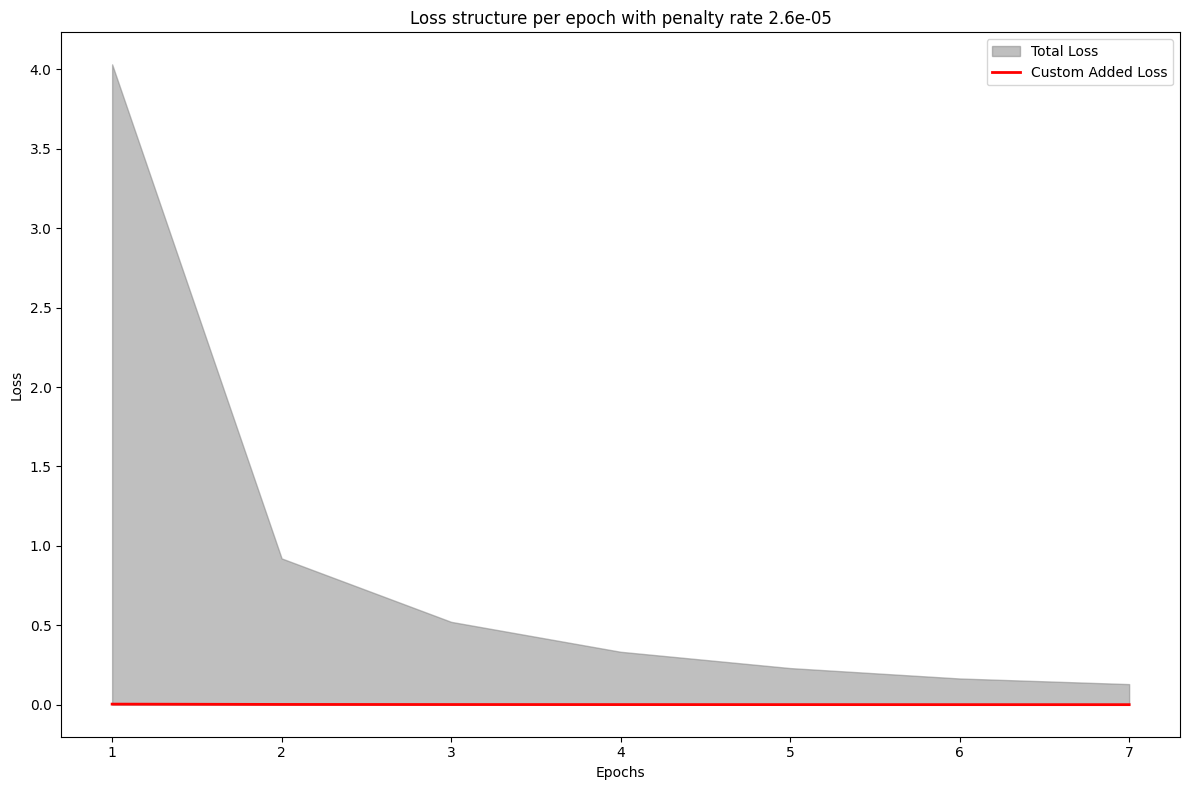


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3e936d8b0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3cd6c7e80>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3e4937e50>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3cd78d370>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3cd6b7f10>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3cd7b10d0>
  - Input Shape: (None, 10)

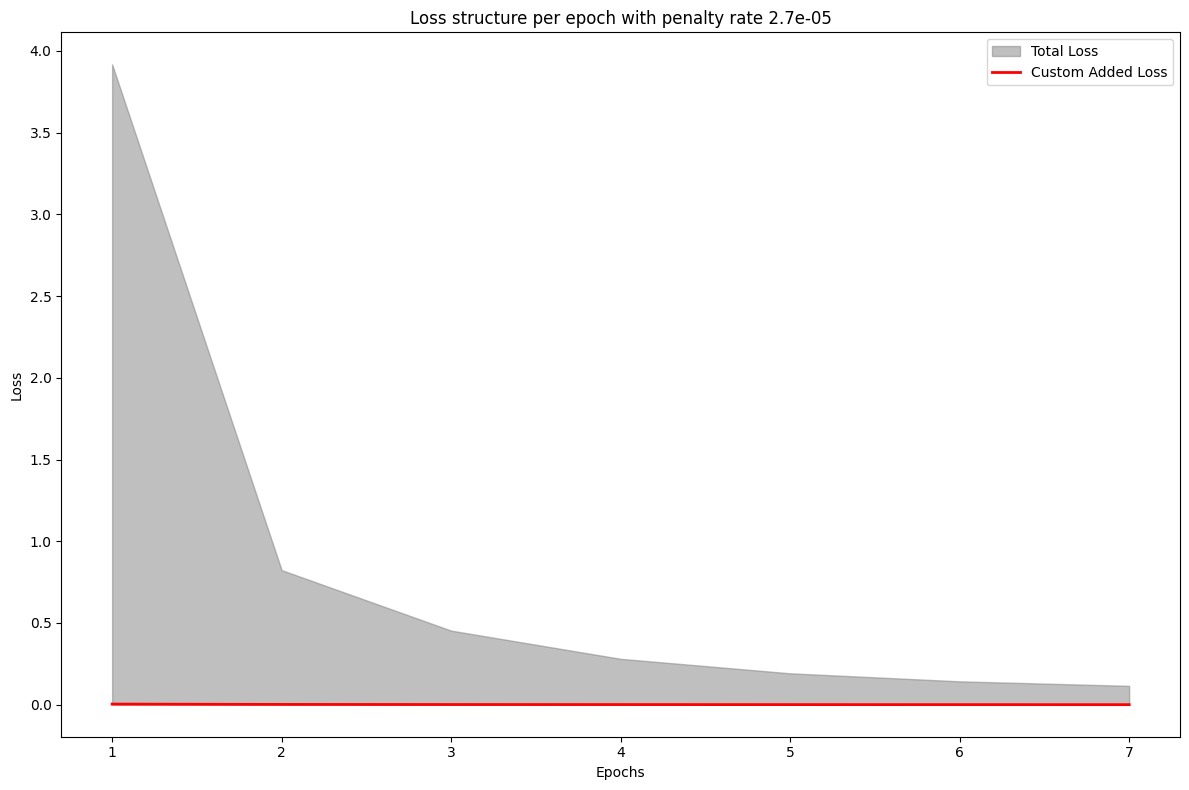


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3cba5c9a0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x175f51400>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x342355be0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3a4c8bac0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3650a02b0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3a4c8b7f0>
  - Input Shape: (None, 10)

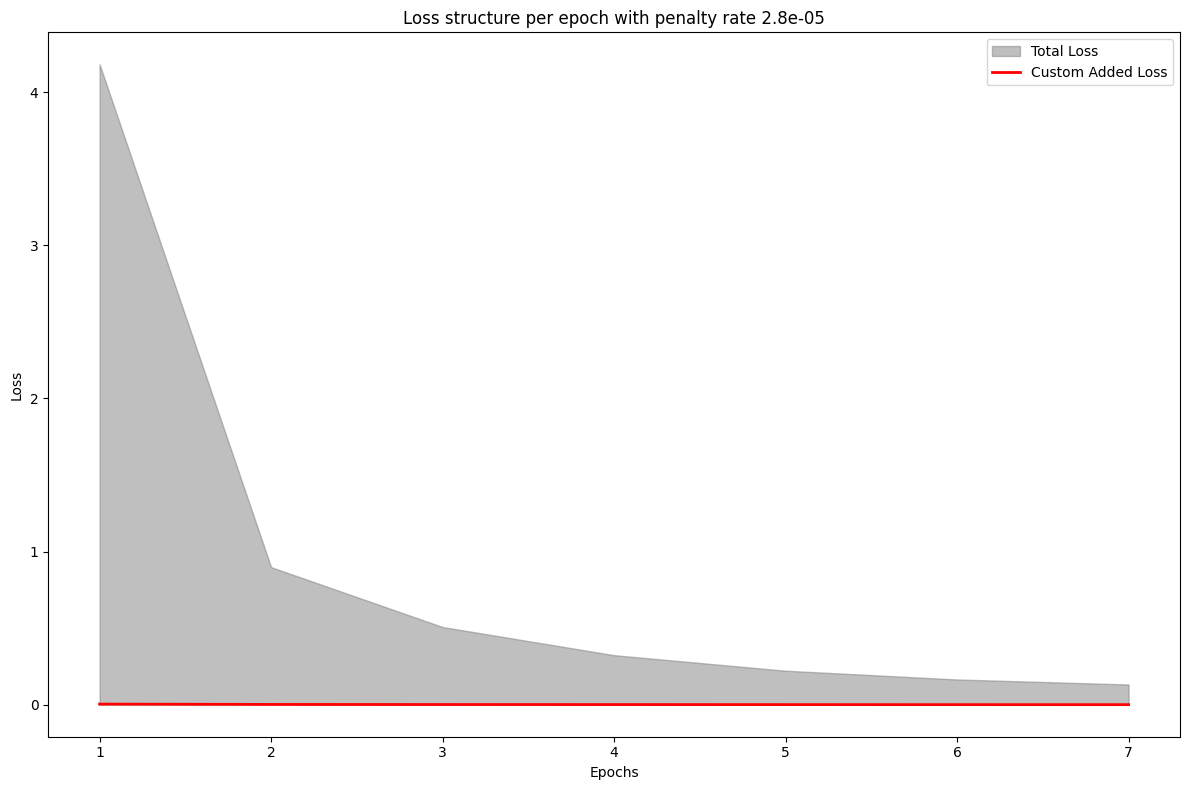


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3cd79f1c0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3a95c8fa0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3a3e3b610>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3e49bb100>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3cd6b7b20>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3e493e4f0>
  - Input Shape: (None, 10)

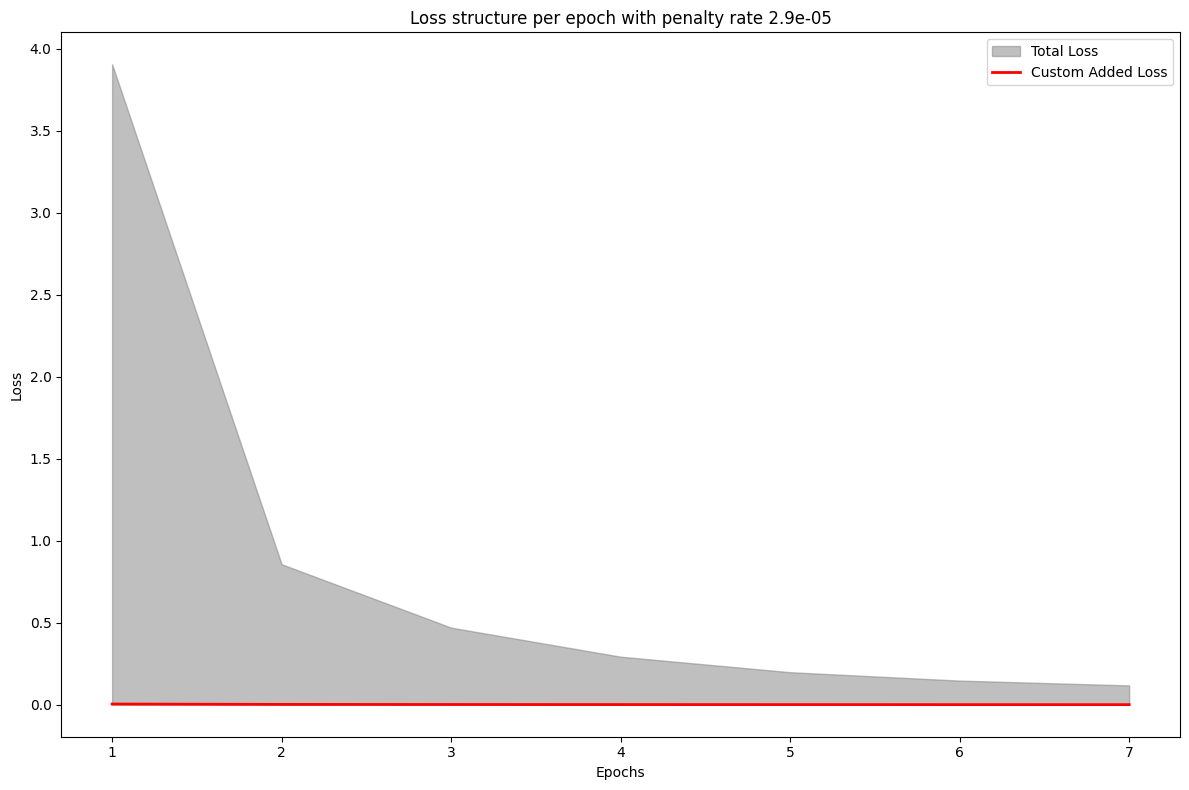


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3a4ccbb50>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x39c633190>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3aa6d83d0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x175b20b50>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3b19ee7f0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3b1a3b1c0>
  - Input Shape: (None, 10)

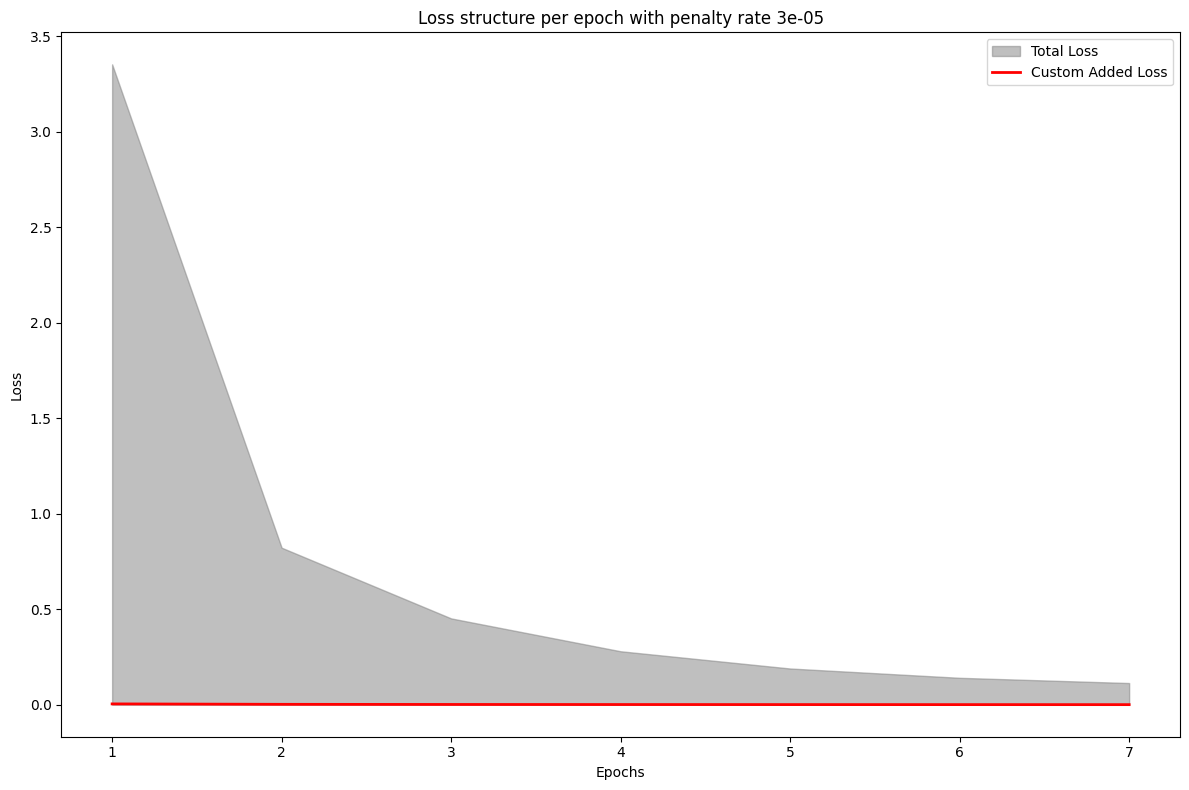


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x409107b20>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x405955dc0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x40598ea00>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3e97c2b20>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3e97ba550>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x405955640>
  - Input Shape: (None, 10)

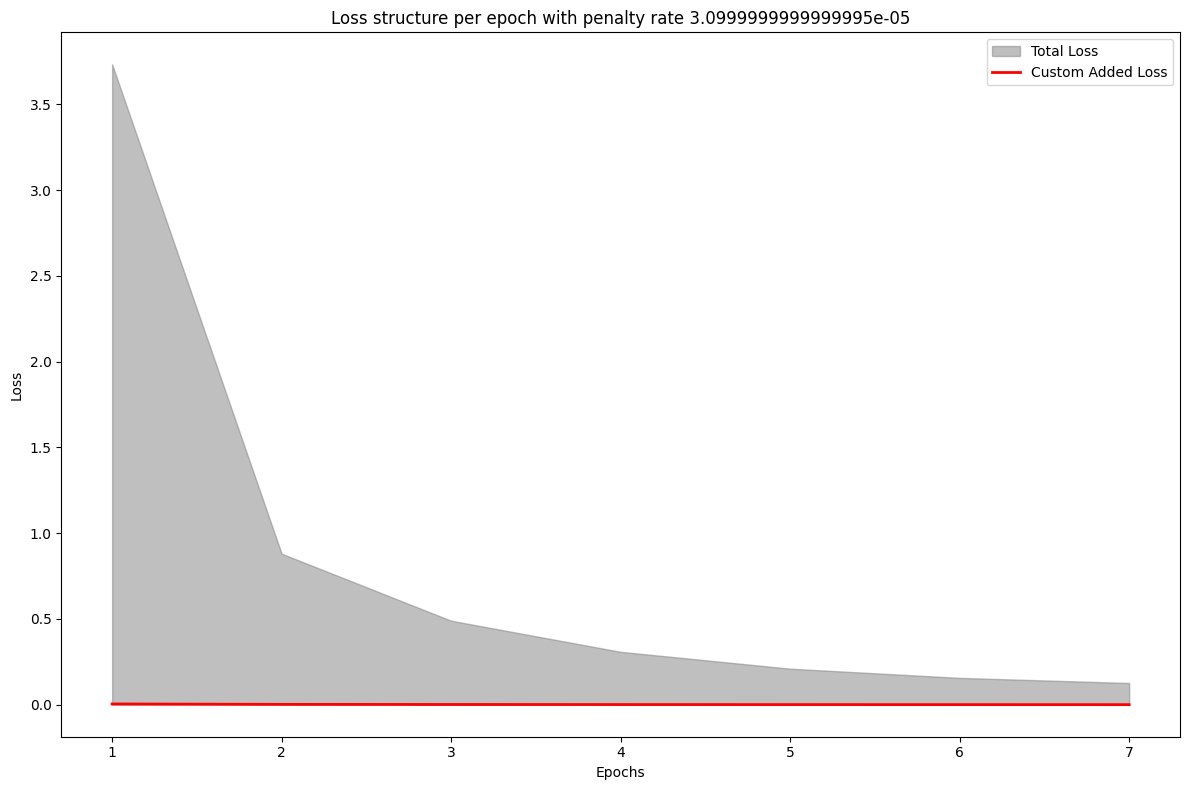


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x39c52a580>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x365054ca0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x314409640>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x347acae50>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x405955e80>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3886308e0>
  - Input Shape: (None, 10)

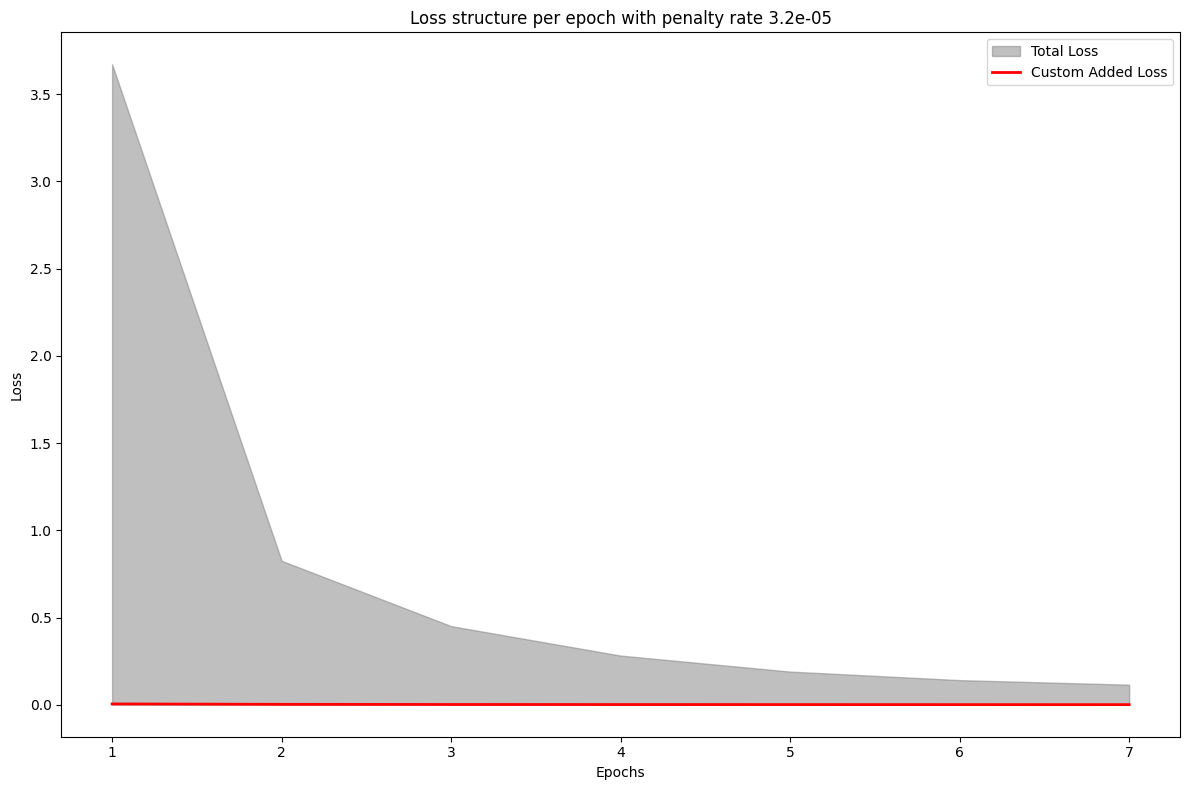


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x39c87df70>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3e494d040>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3b1a5a580>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3a4d7fca0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3b1a5a490>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3a4d7fd90>
  - Input Shape: (None, 10)

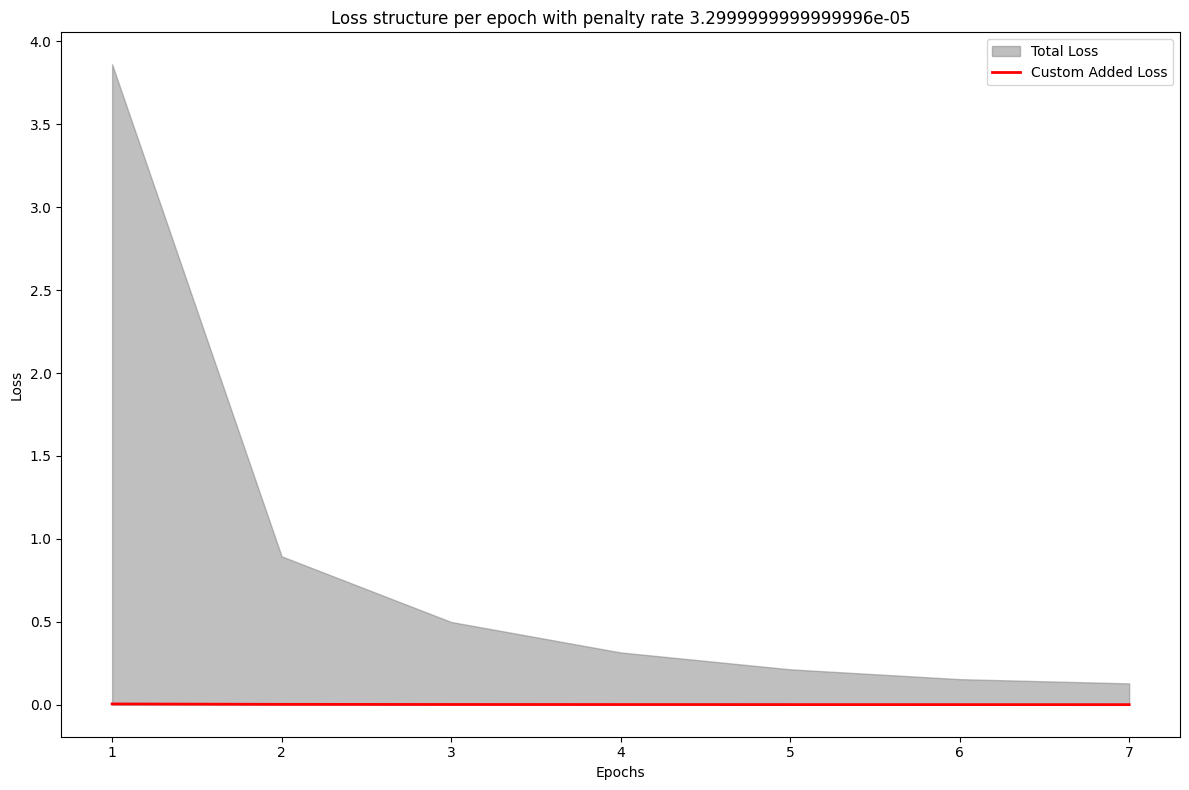


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3e49e4df0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x364f654c0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x39ca02850>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3cd8899a0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x36a079d60>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x40599efd0>
  - Input Shape: (None, 10)

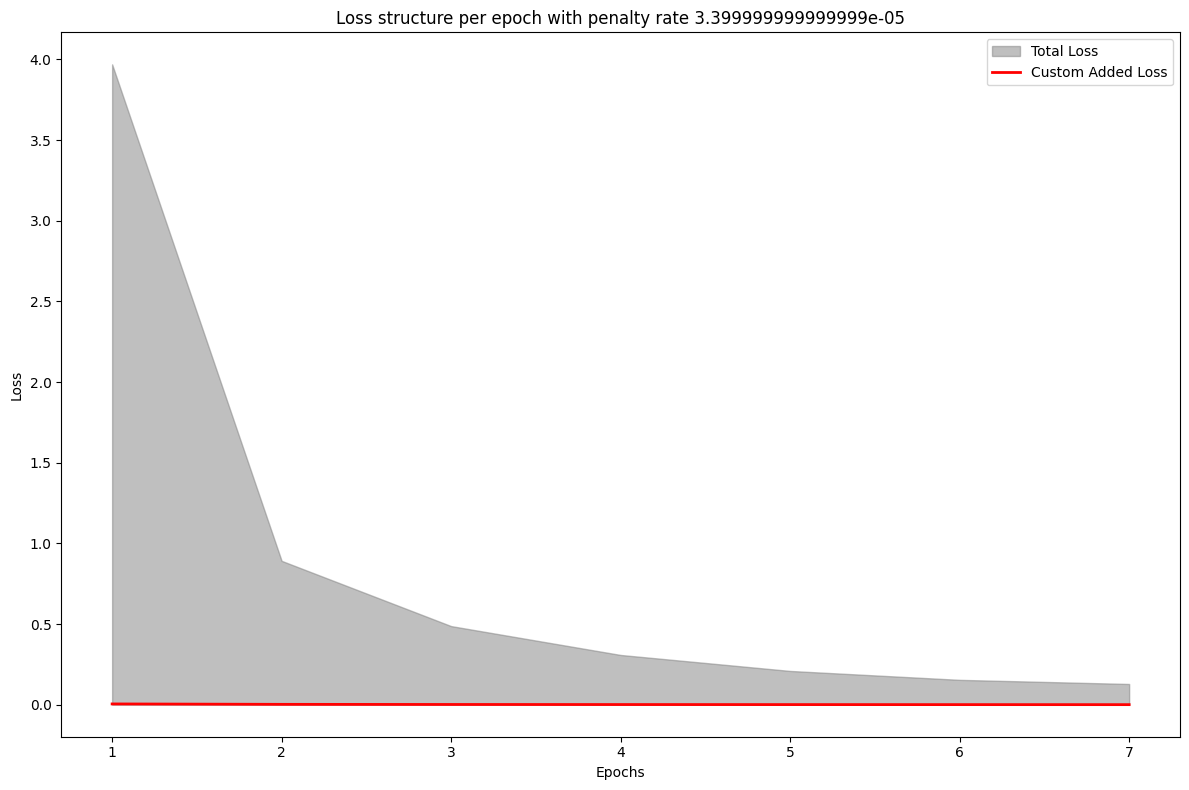


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3a3eda7c0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3fe9cffd0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3fe9cf4f0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3feb7feb0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3d09020d0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3d08f5fa0>
  - Input Shape: (None, 10)

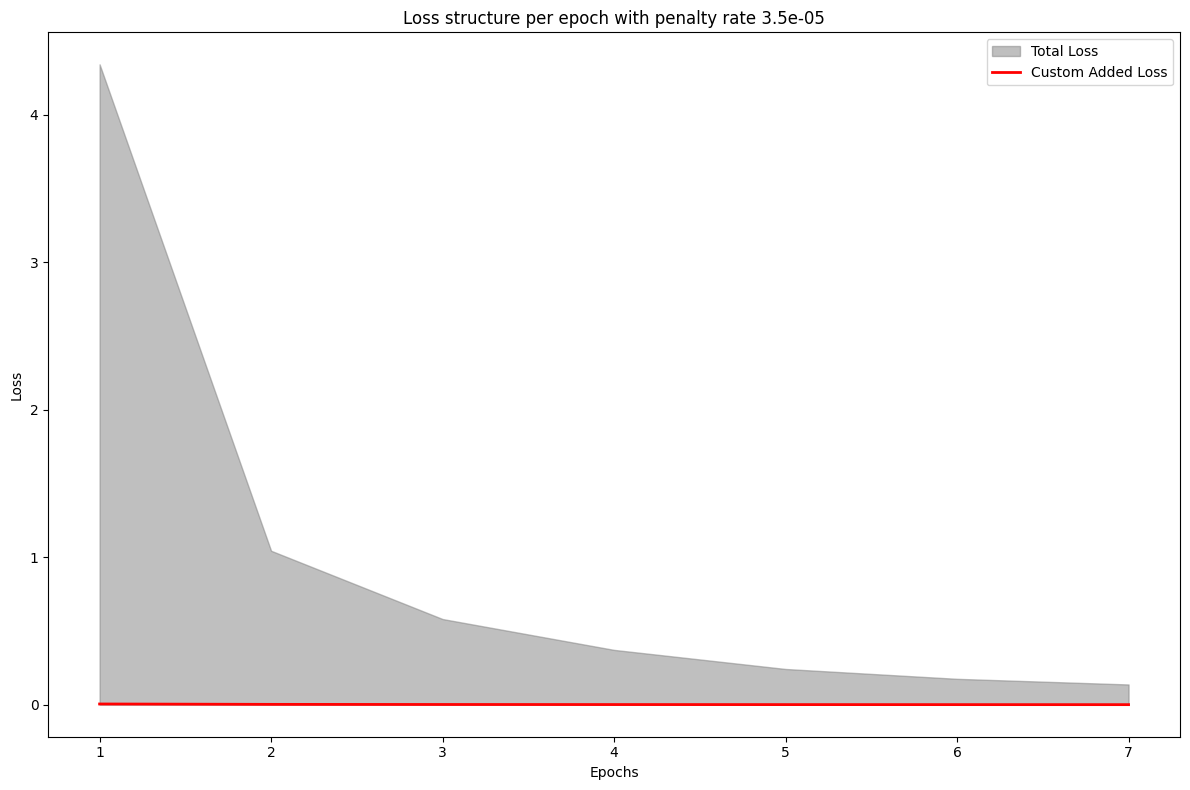


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3feb29370>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x36a0b3d00>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3a4ce7940>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x345c6c6a0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x31a78e310>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x380c70310>
  - Input Shape: (None, 10)

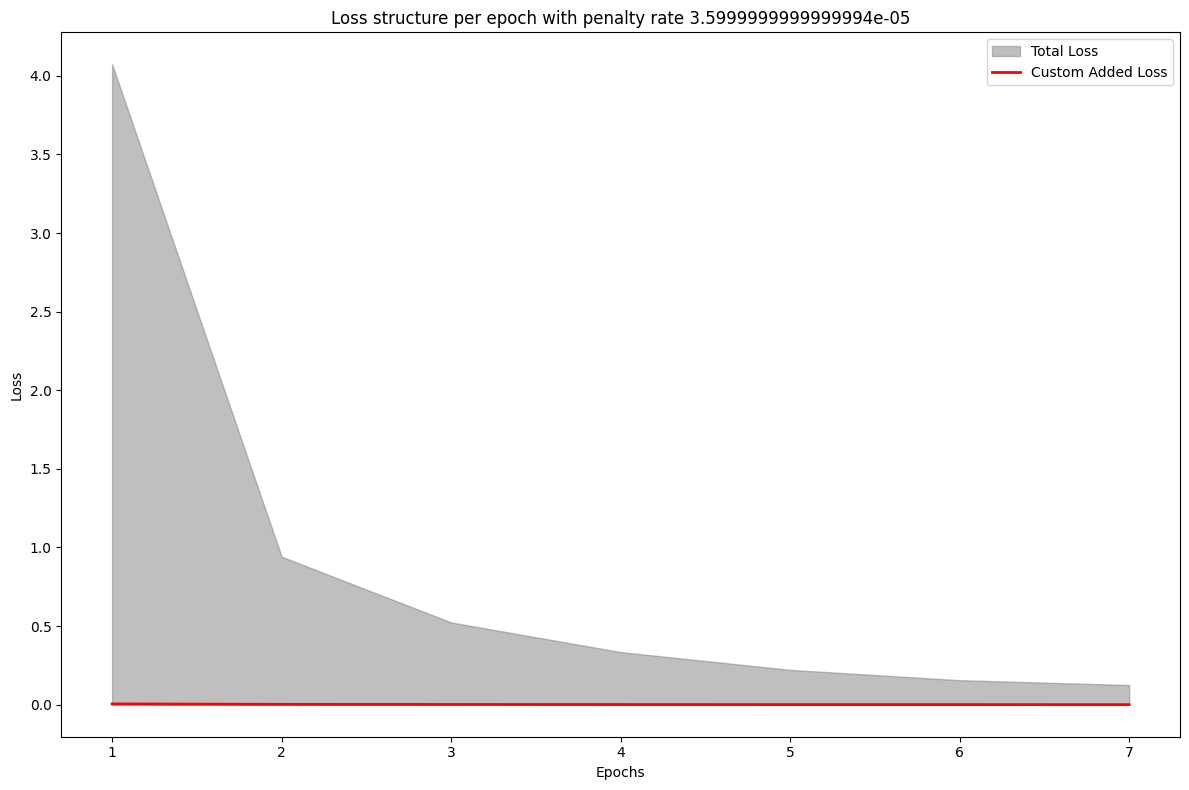


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3a4c48d30>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3feb1abe0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3fe9cfd90>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3b8ebf400>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x36a079ee0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3e493e9a0>
  - Input Shape: (None, 10)

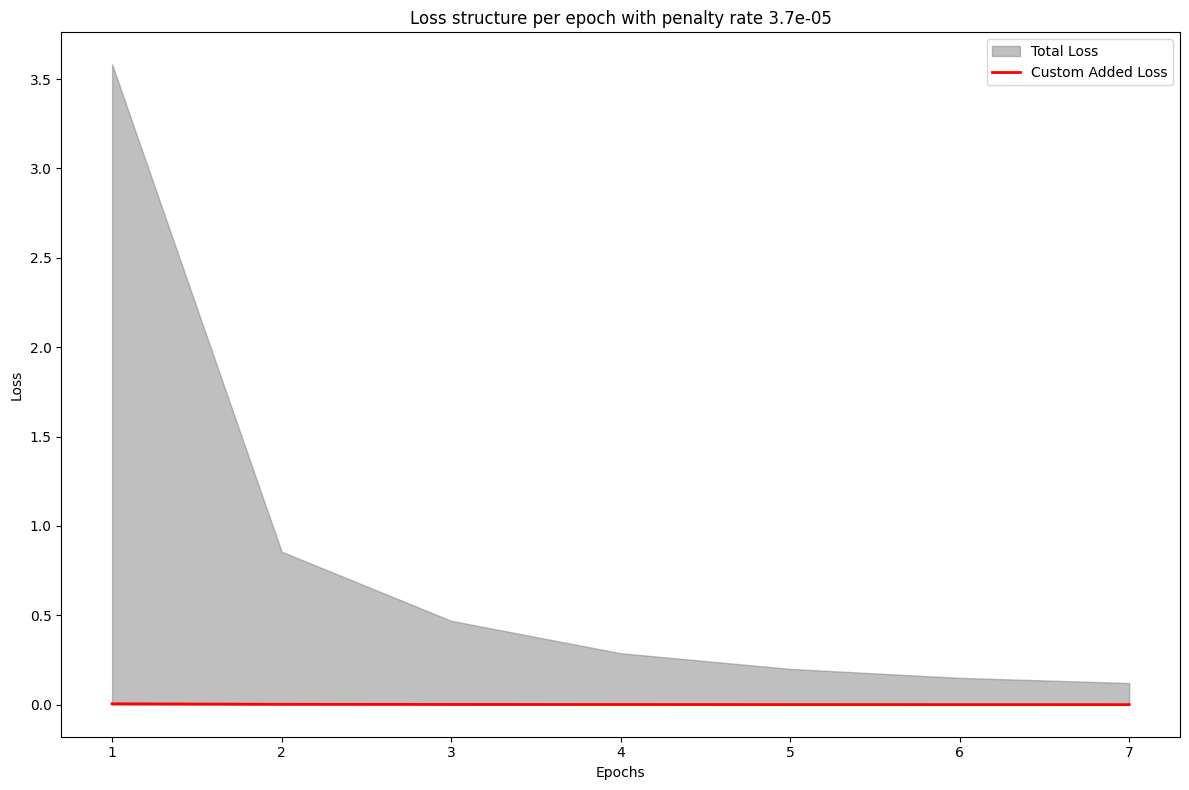


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x318550730>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3b89752e0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x39ca0aa60>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3b890b340>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4059d1880>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3e936dd60>
  - Input Shape: (None, 10)

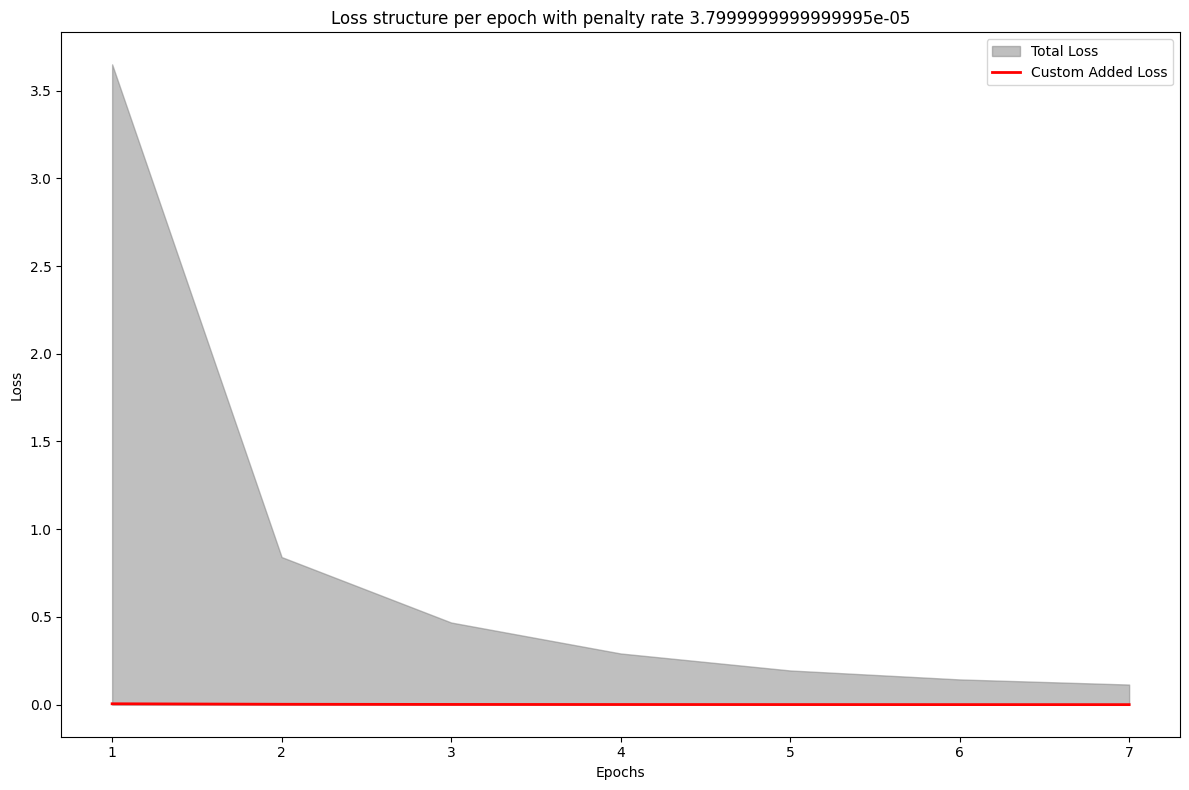


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3b899f1f0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3ffc59be0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x380e09490>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4091bc5e0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3d7d745e0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3ffb5c4f0>
  - Input Shape: (None, 10)

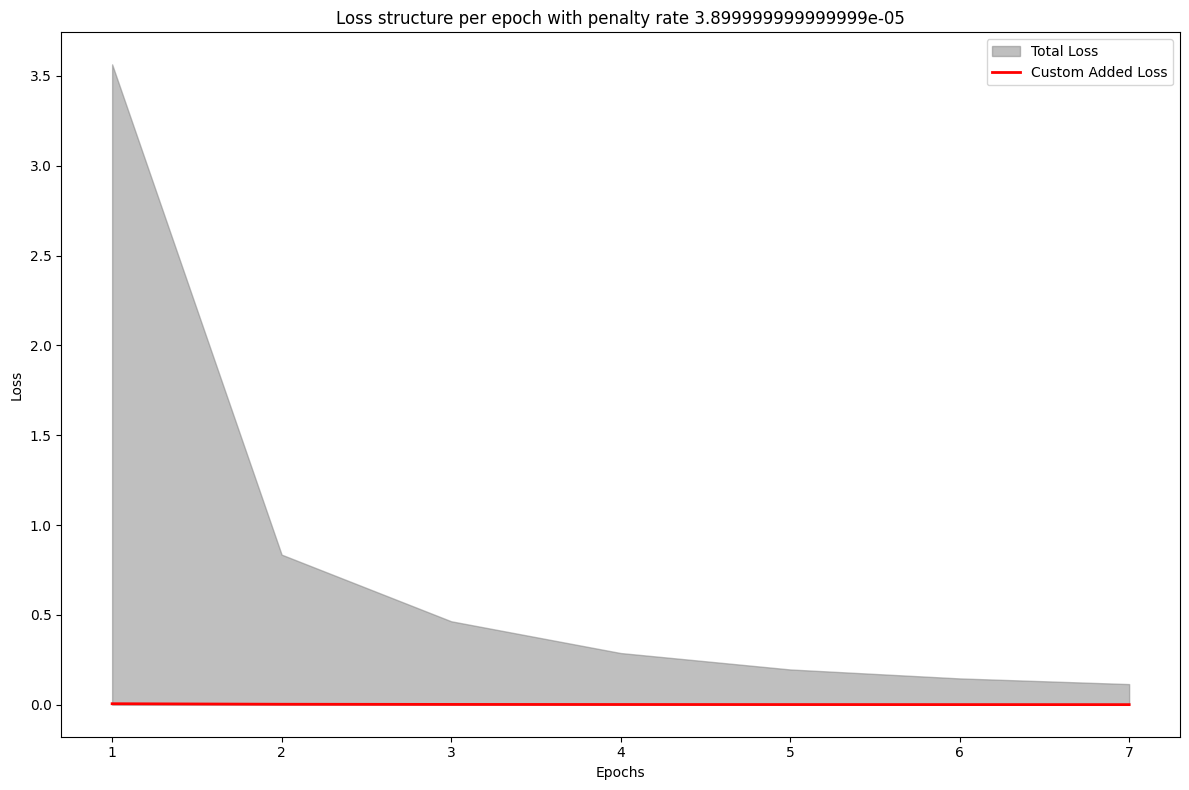


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x318550a90>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x386f79b50>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x39c66ddf0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3b1a96b50>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x31870f280>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3bb4e2c70>
  - Input Shape: (None, 10)

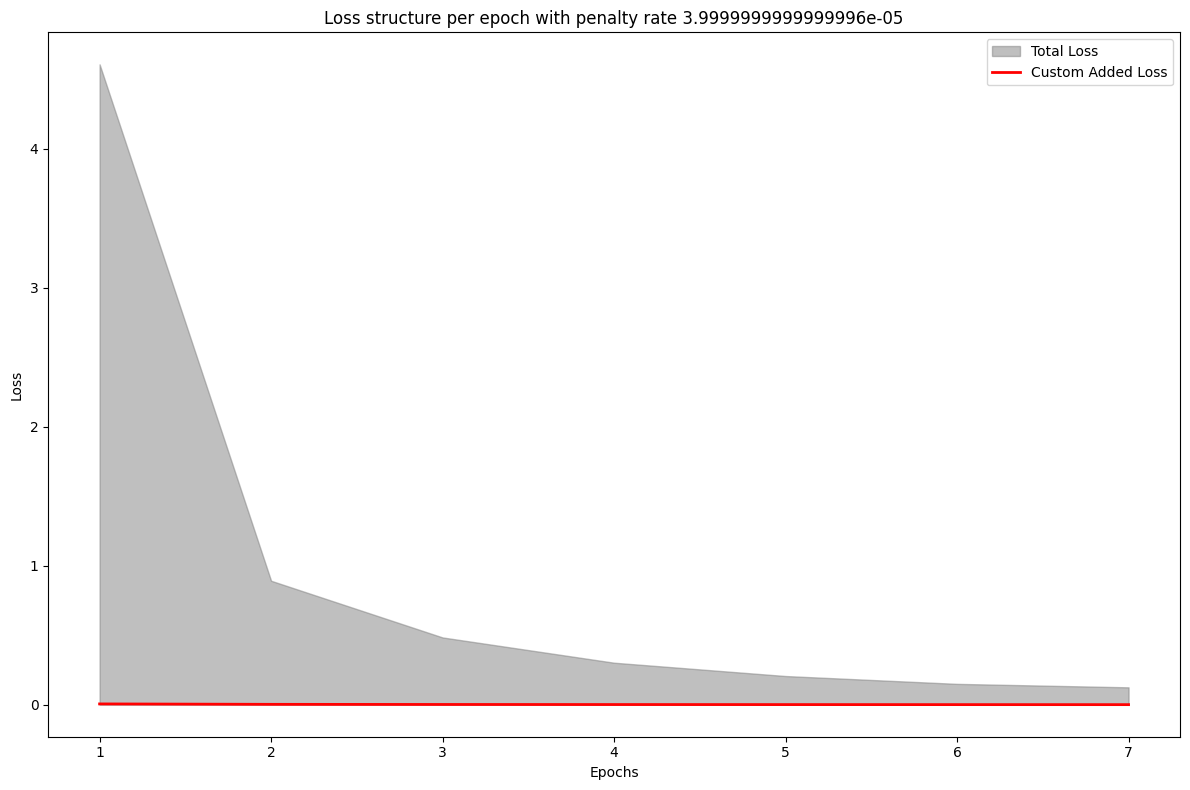


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x388db7d00>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3d07c6430>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3feb840d0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x342606d90>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3b89a8730>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3b1c77070>
  - Input Shape: (None, 10)

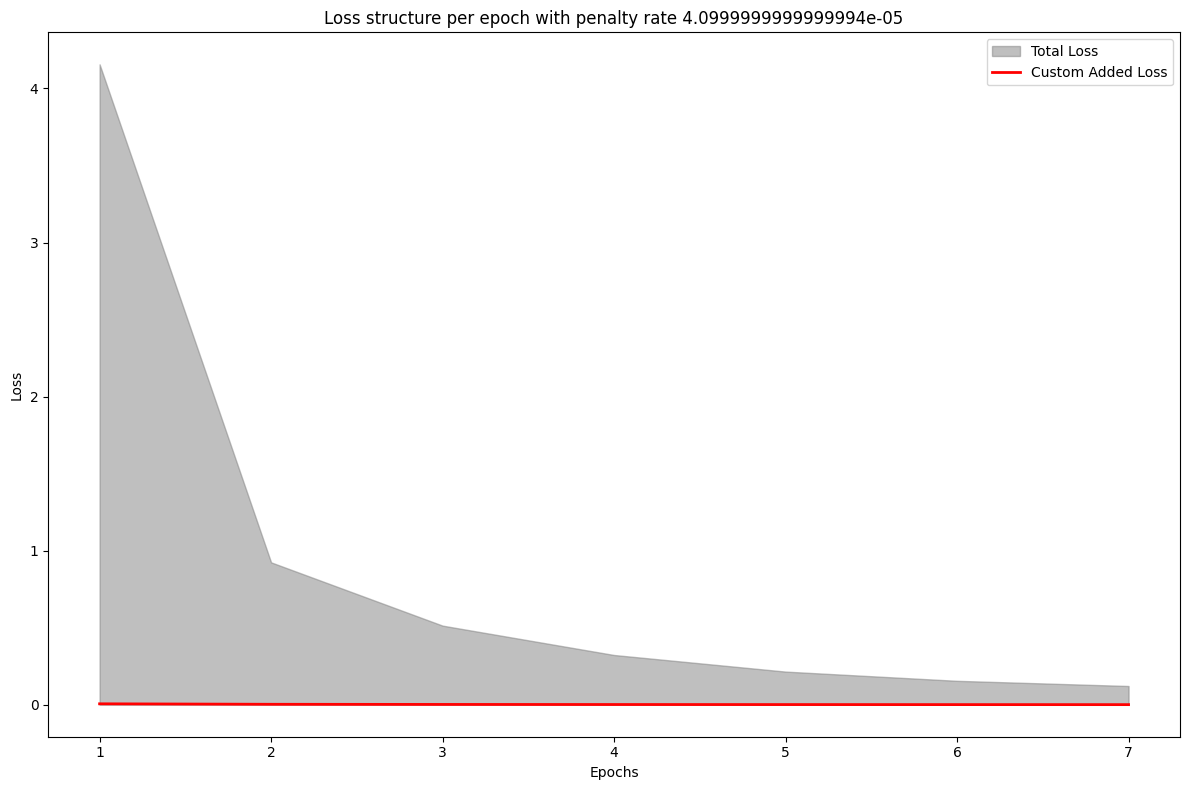


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3cd719640>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3febe98e0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3ffc16640>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3e4994790>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x380b6e970>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x405db0af0>
  - Input Shape: (None, 10)

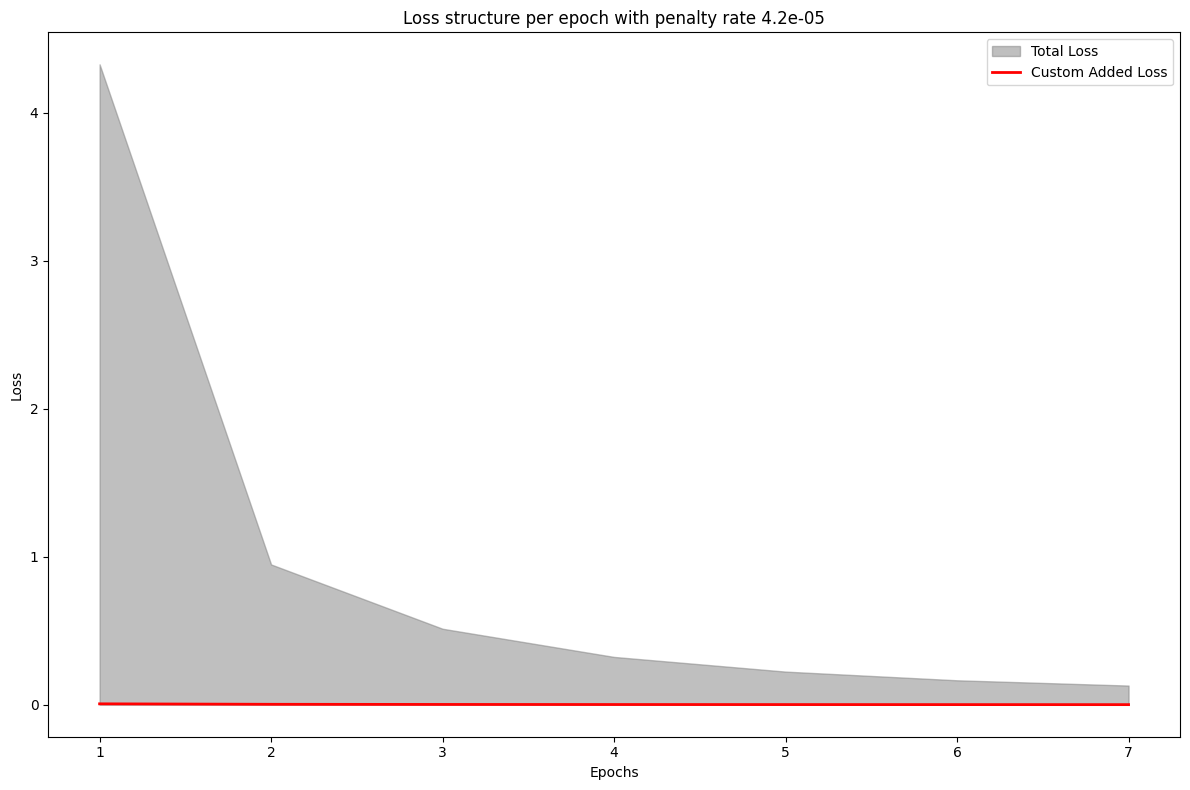


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x42122fbb0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x42128a430>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3b8d5c790>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x421259160>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3ca9ecaf0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4212a3f40>
  - Input Shape: (None, 10)

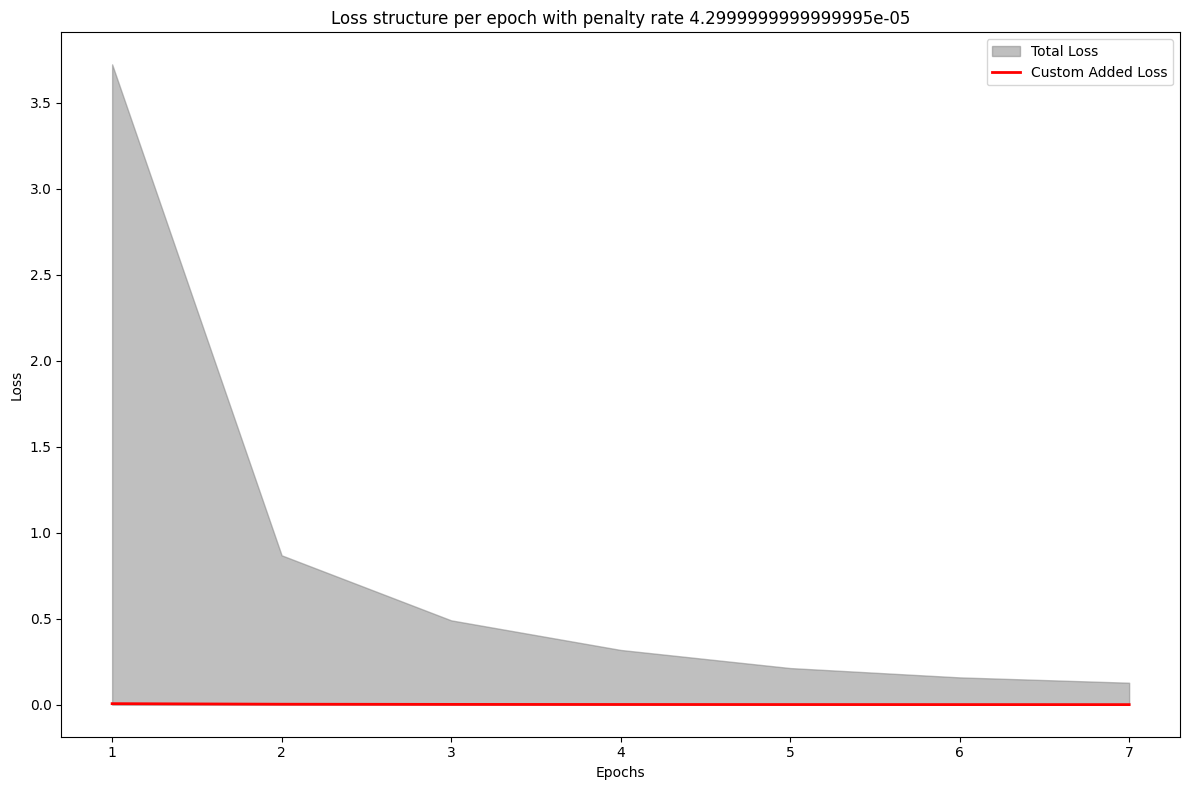


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3ffbdf4f0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x482e531f0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x482ea6400>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x464fb1a90>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x464fd94f0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x483009af0>
  - Input Shape: (None, 10)

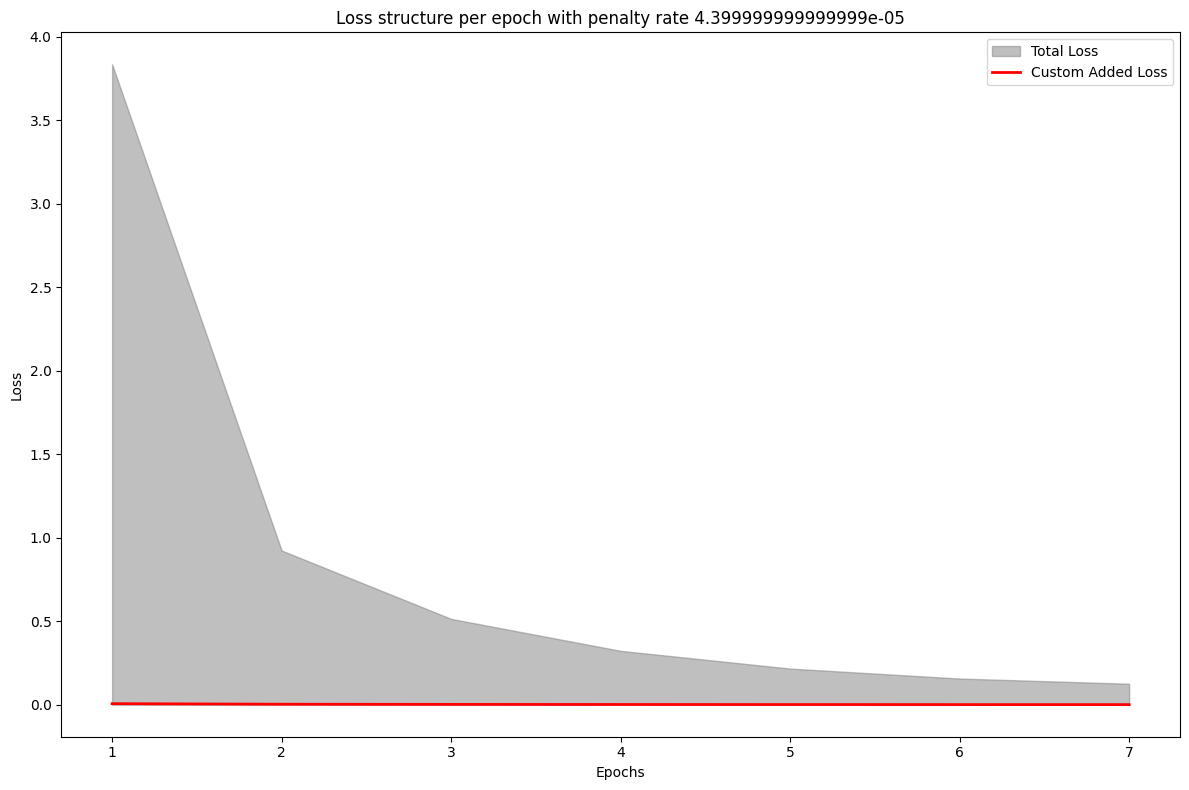


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3cd889fa0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3cd8bb6a0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x316e34ac0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x30dd49e20>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x175f9a640>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x31855e4c0>
  - Input Shape: (None, 10)

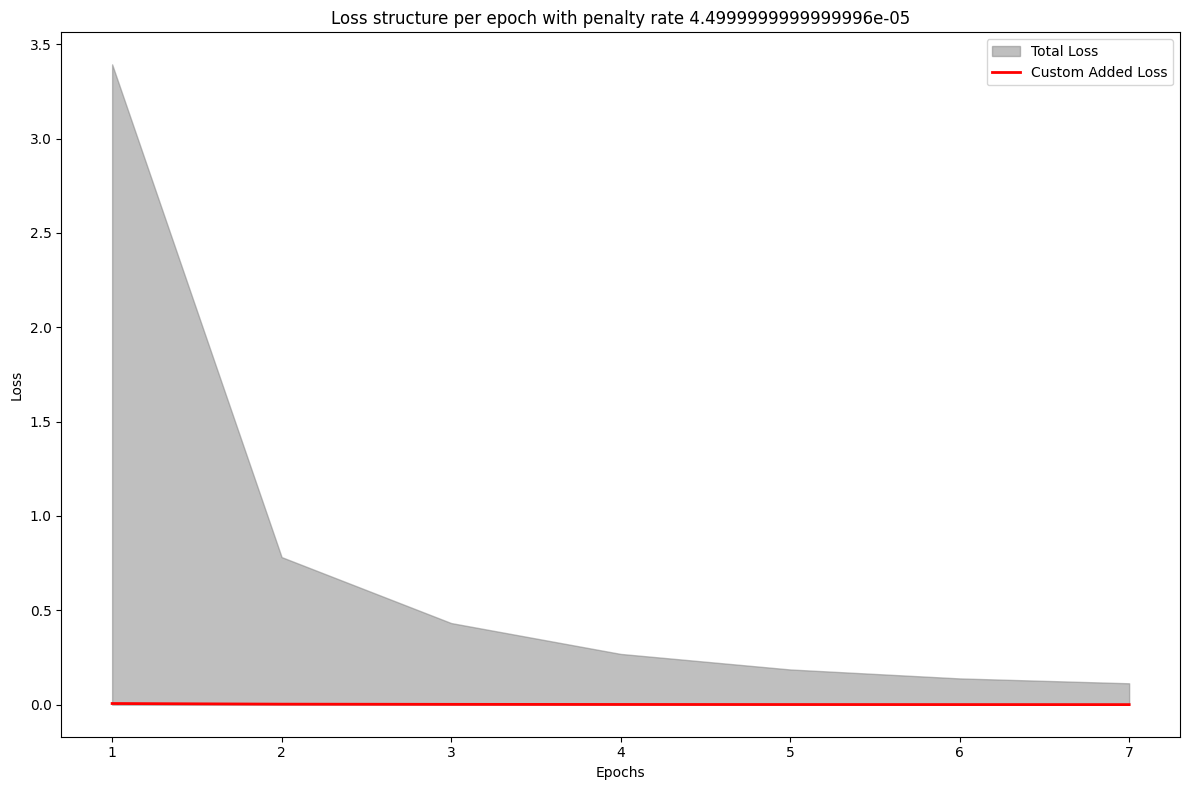


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x345c99640>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3ffbc50a0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3b89cc8e0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3ffc83490>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3cd719940>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3b8db3130>
  - Input Shape: (None, 10)

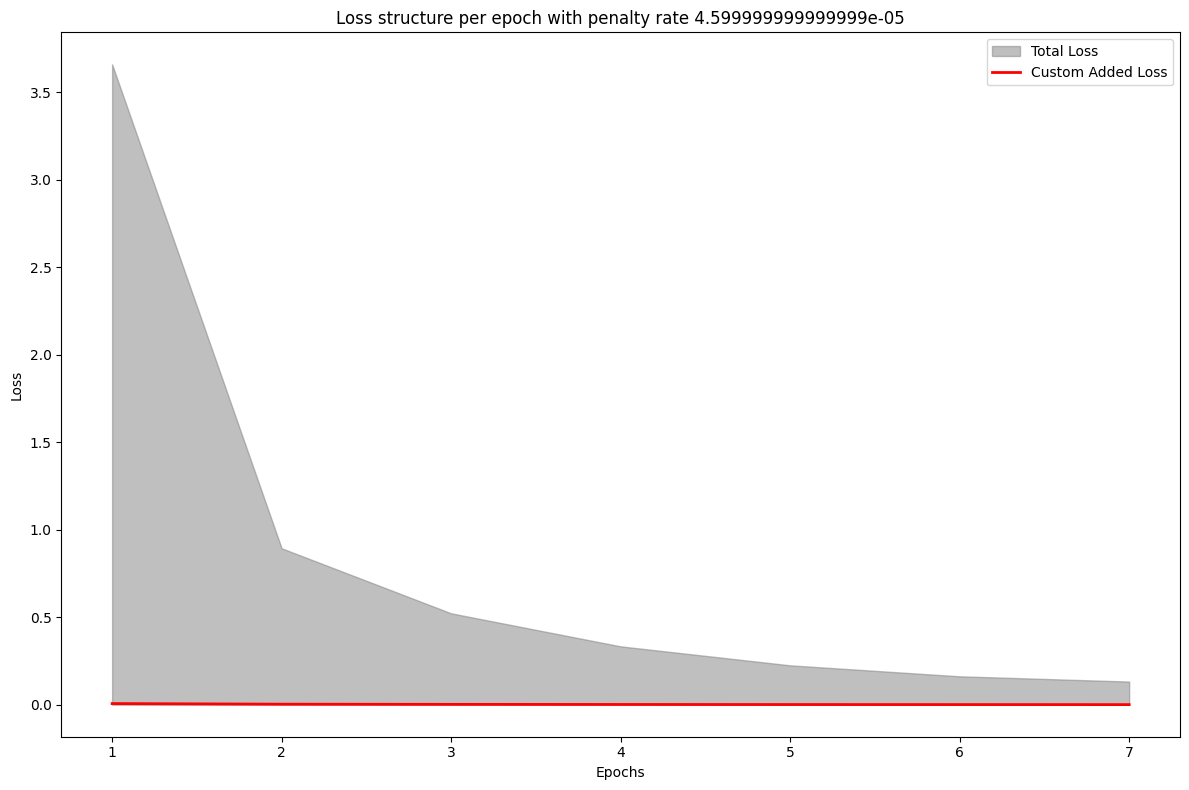


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x421092bb0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3e964a790>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x31546b580>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x34c1ab8b0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x380557100>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x34c1b5160>
  - Input Shape: (None, 10)

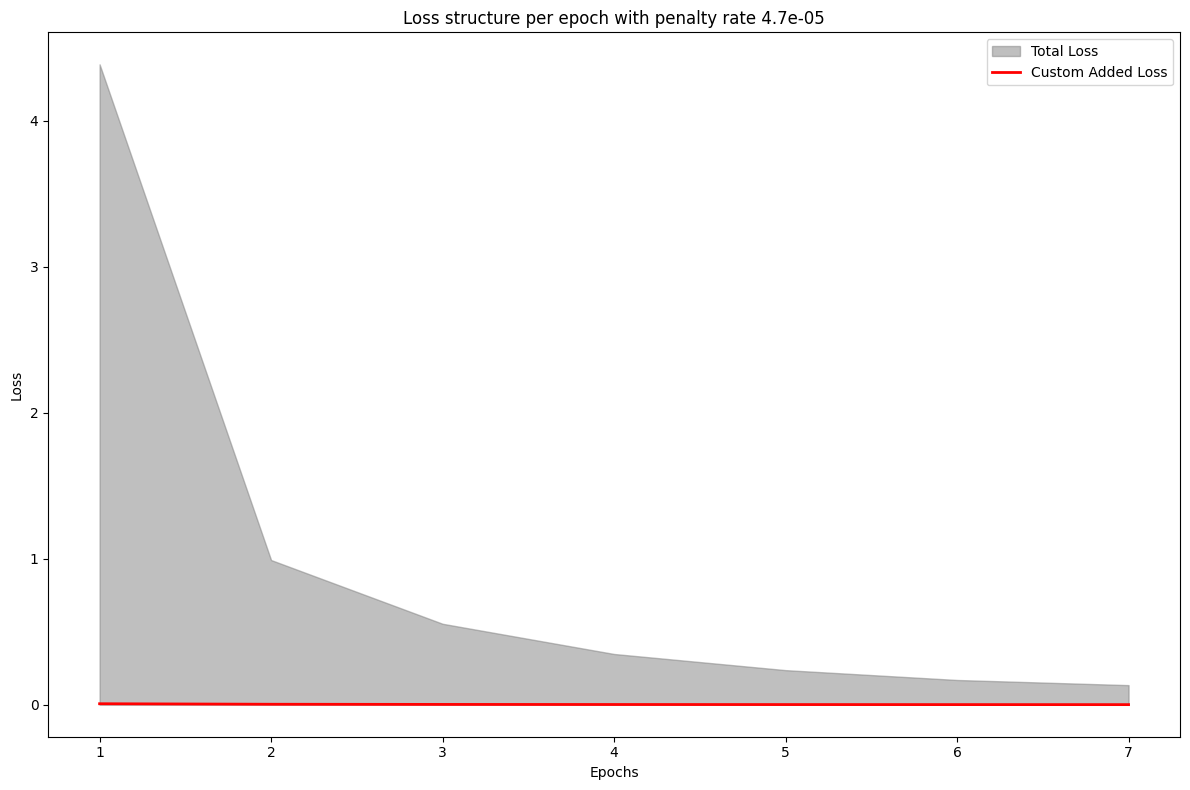


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x426406190>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x440b86670>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x4361dac70>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3f4fca730>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x440b87040>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x42646edf0>
  - Input Shape: (None, 10)

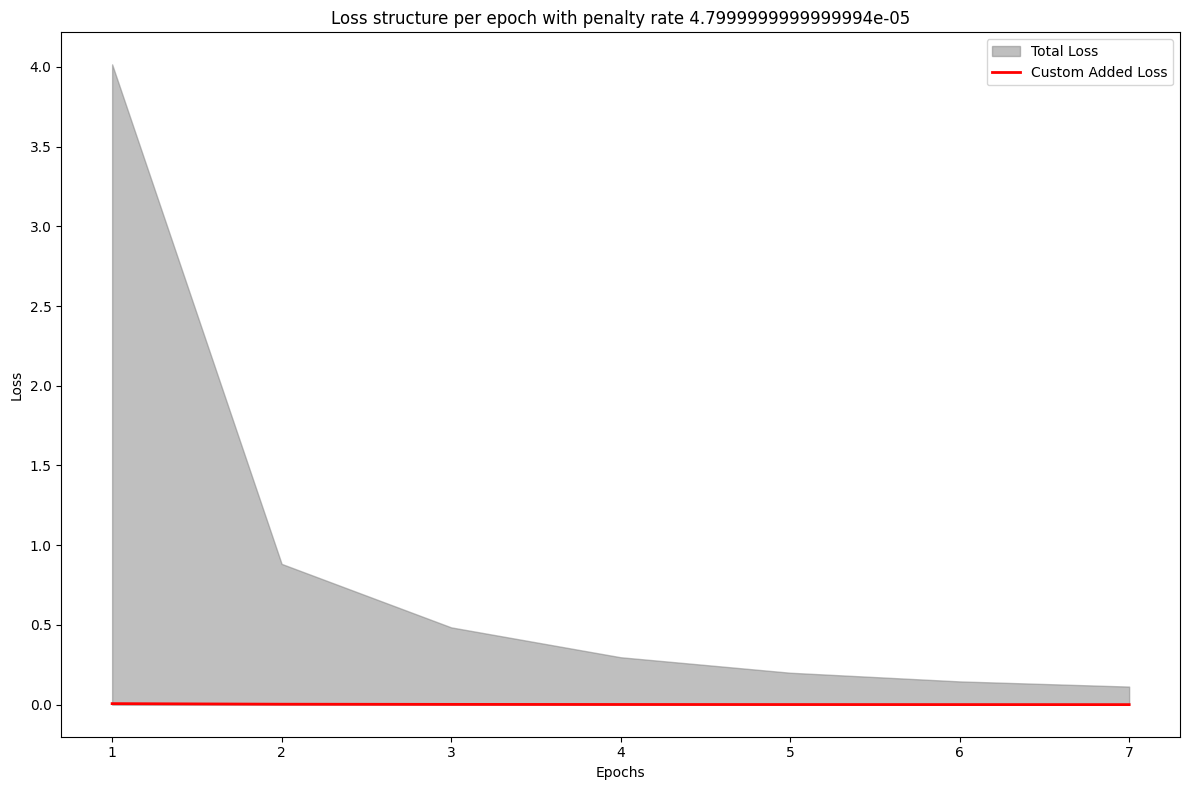


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x34a249ac0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x31546bcd0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x388db7b80>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x34ba05160>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x39ca64760>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x34235d5b0>
  - Input Shape: (None, 10)

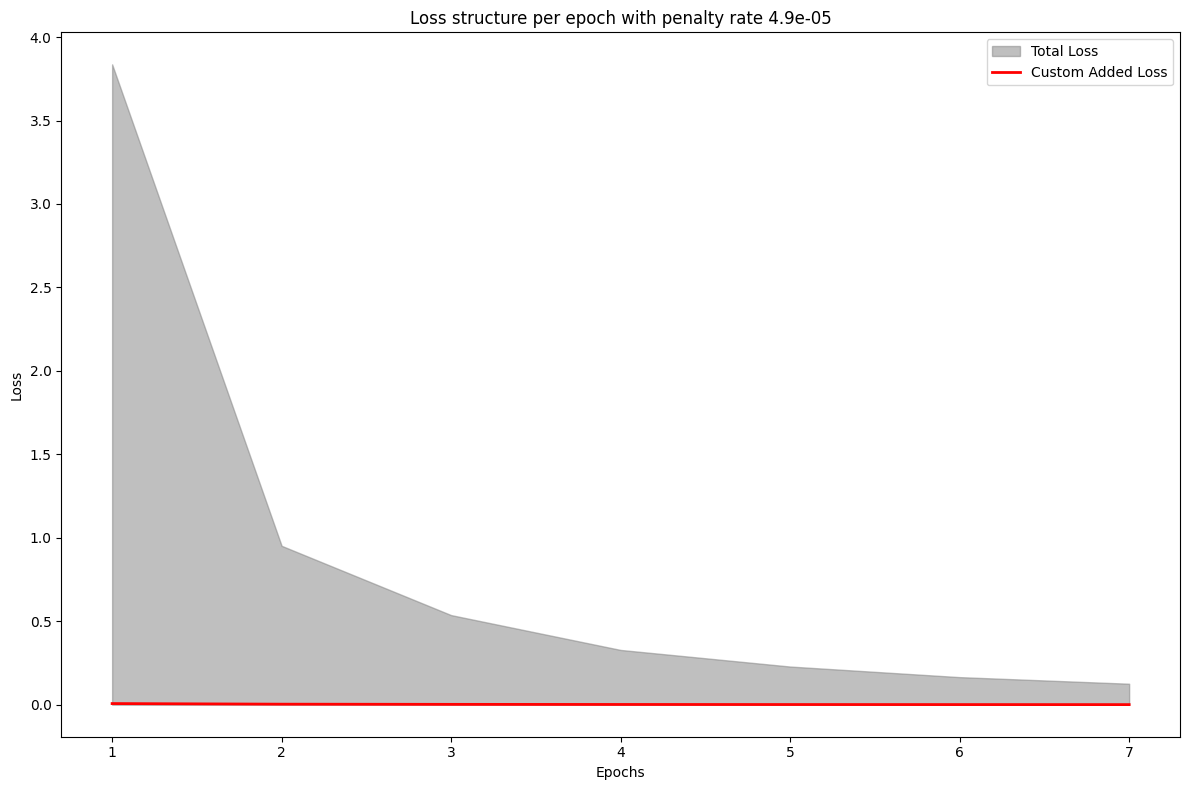


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x45add5be0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3e96f3970>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x31845f760>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4830fa2b0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3e93bb1f0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x47cb8bf10>
  - Input Shape: (None, 10)

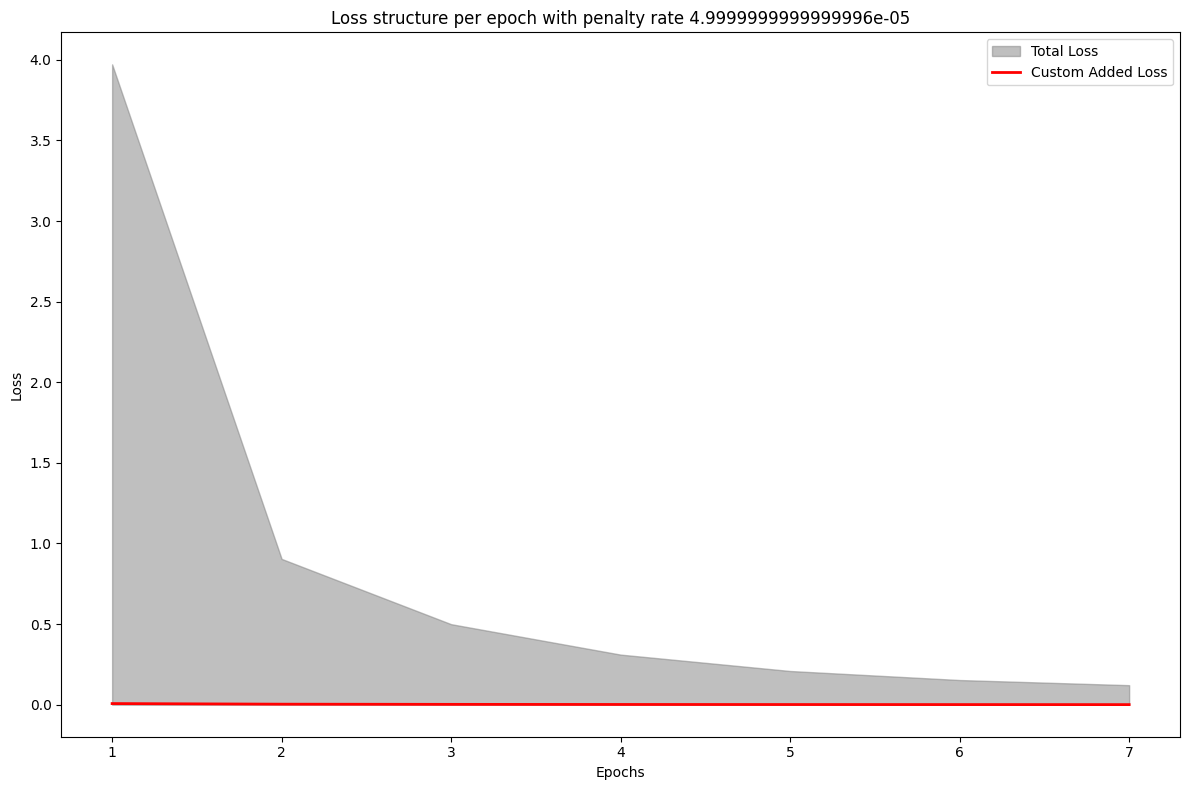


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x405d08e50>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x314408fa0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x426416a30>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4059d9670>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3f4f99190>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4059d9070>
  - Input Shape: (None, 10)

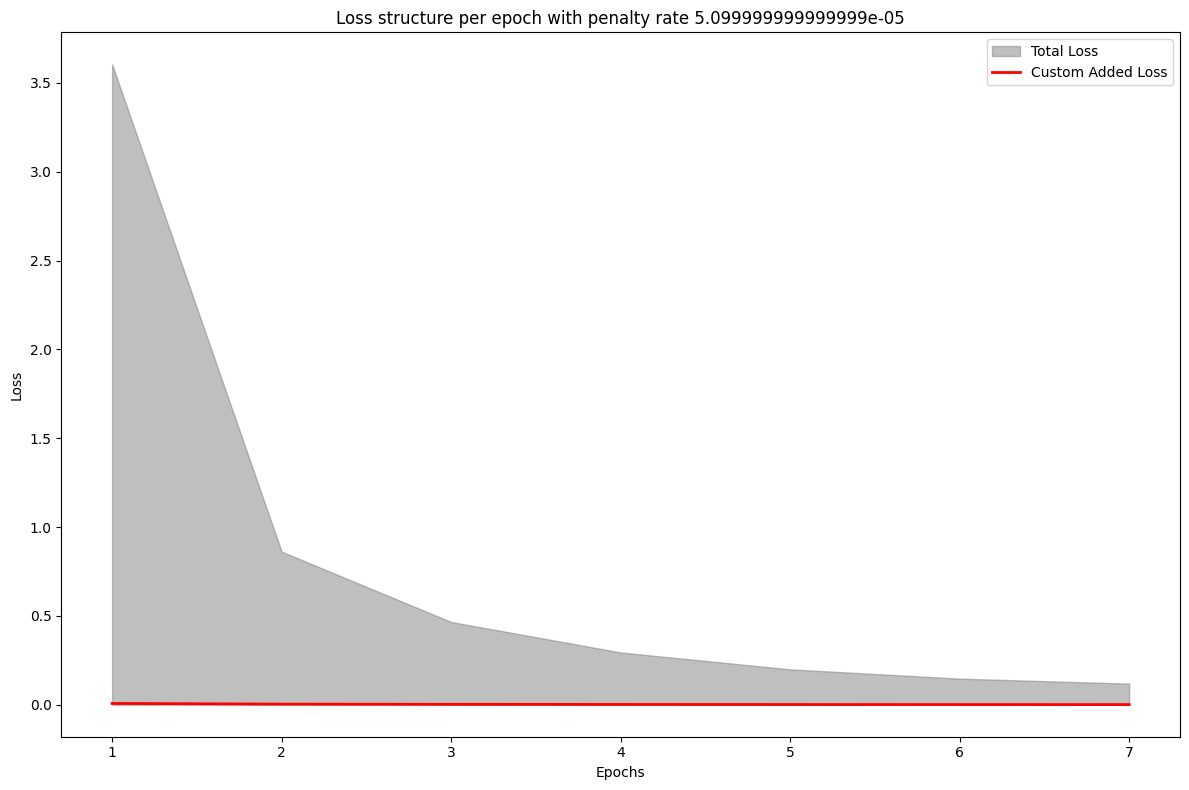


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3ca95d550>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3ca98d460>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x4410a58b0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3c7ec5dc0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3a3eb77f0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3c7e9ffa0>
  - Input Shape: (None, 10)

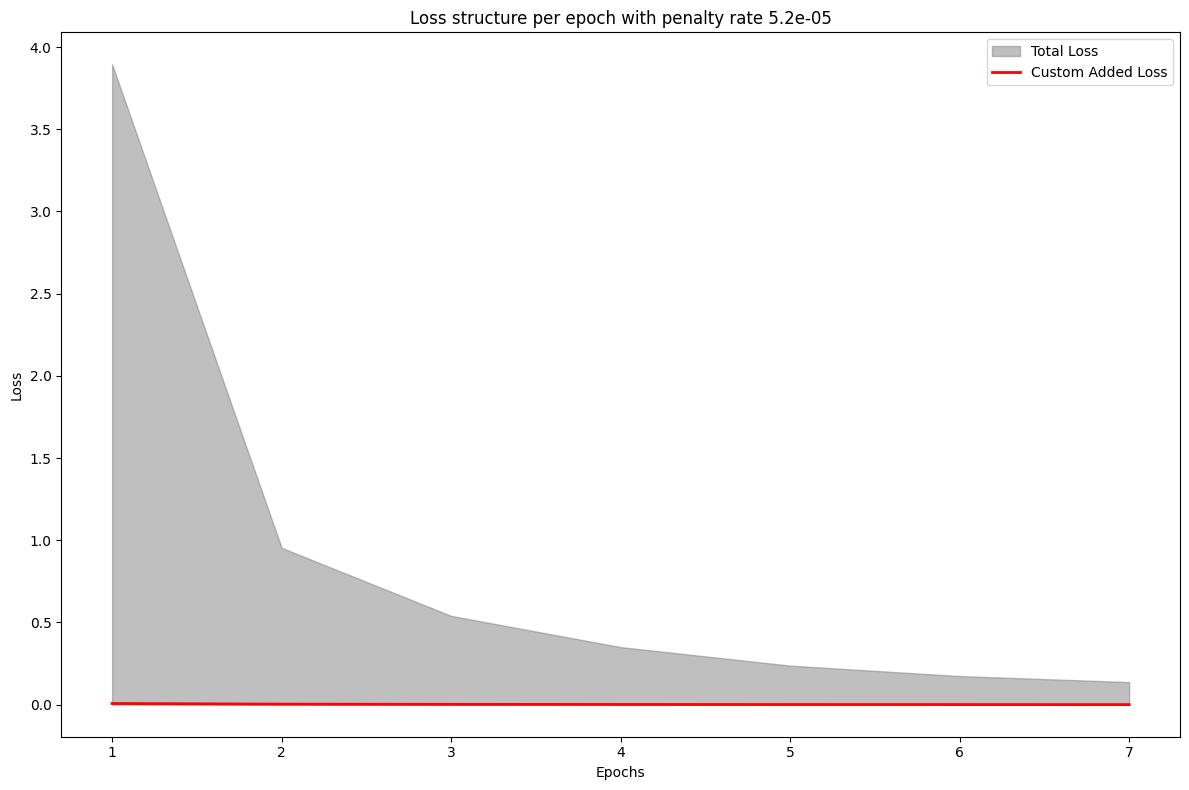


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3c7ecdf10>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x34b287940>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x34b287130>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4048d0f40>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4547c7fd0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x384177a90>
  - Input Shape: (None, 10)

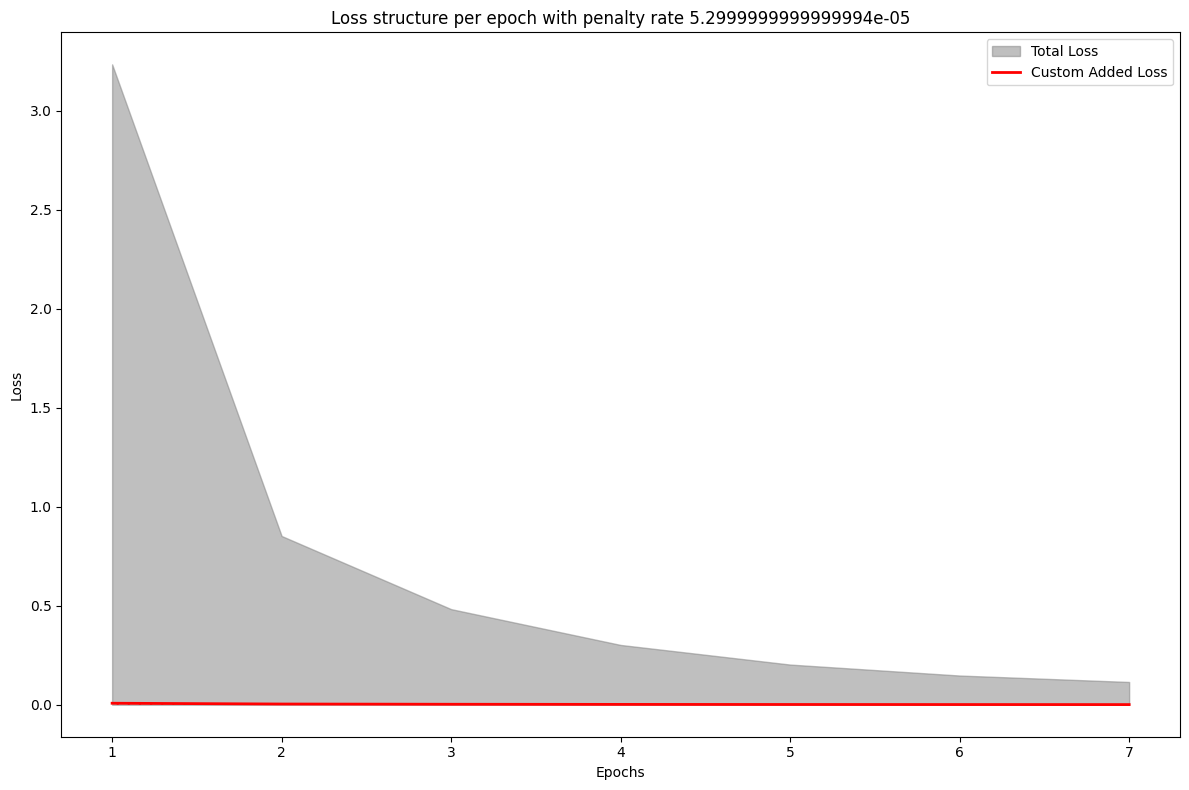


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3bb424a00>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x45422cd00>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x345cc4b80>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x454869bb0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4d75dffa0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3c7ea3310>
  - Input Shape: (None, 10)

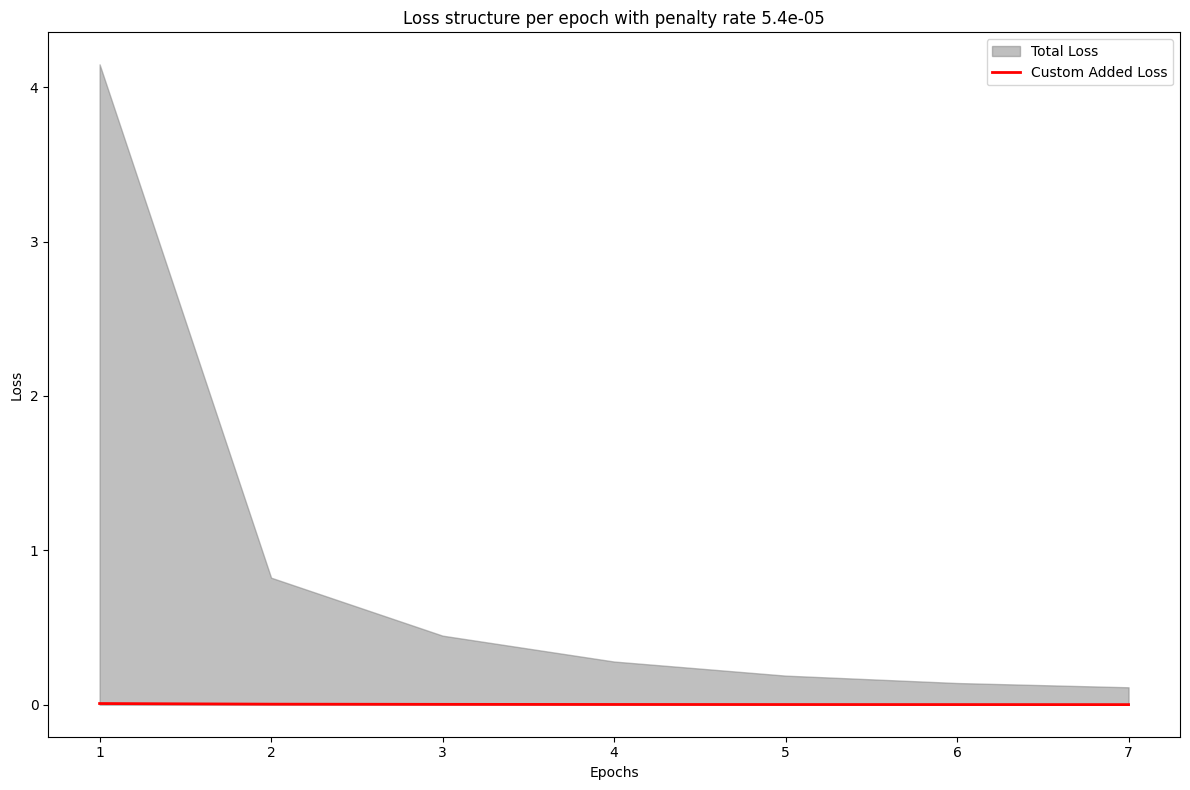


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x175db59a0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x47cbacb50>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3a4cece50>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x48802b580>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3a4cec430>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3febabe20>
  - Input Shape: (None, 10)

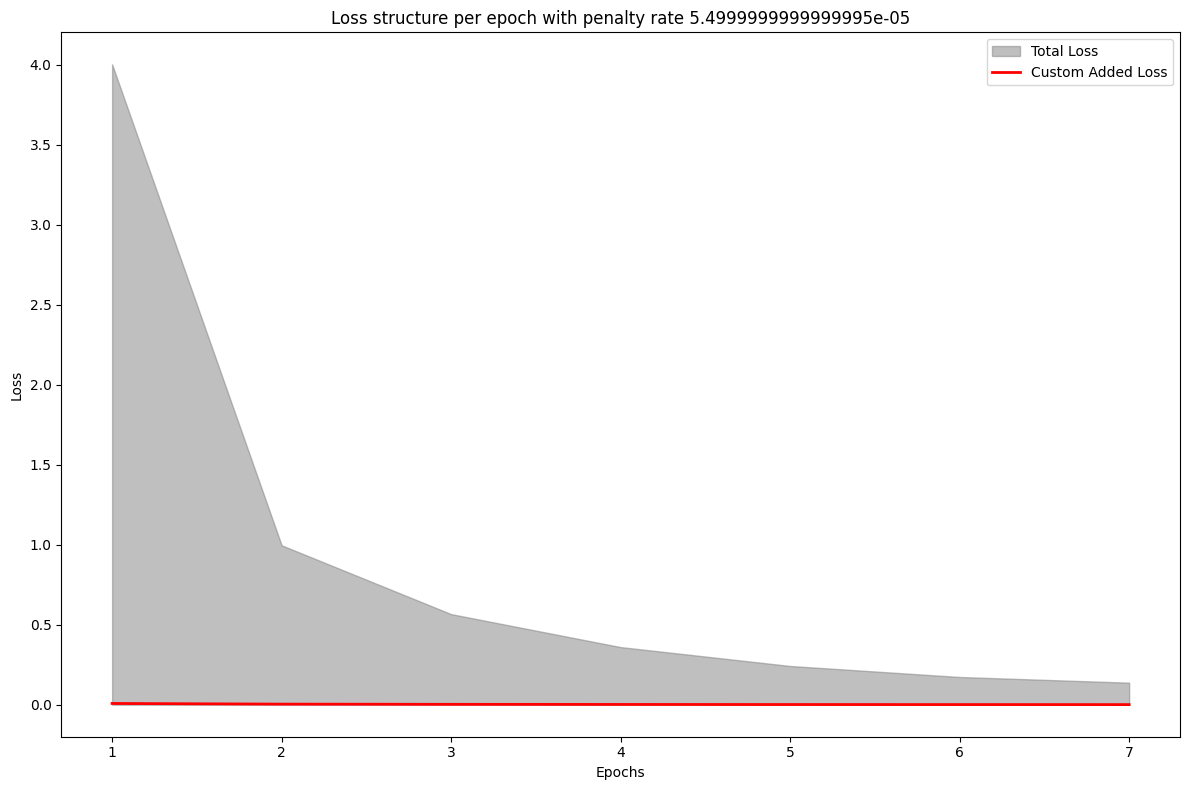


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3842c7ac0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3febdfdf0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x401dc90a0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x384116370>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3841166a0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3842da400>
  - Input Shape: (None, 10)

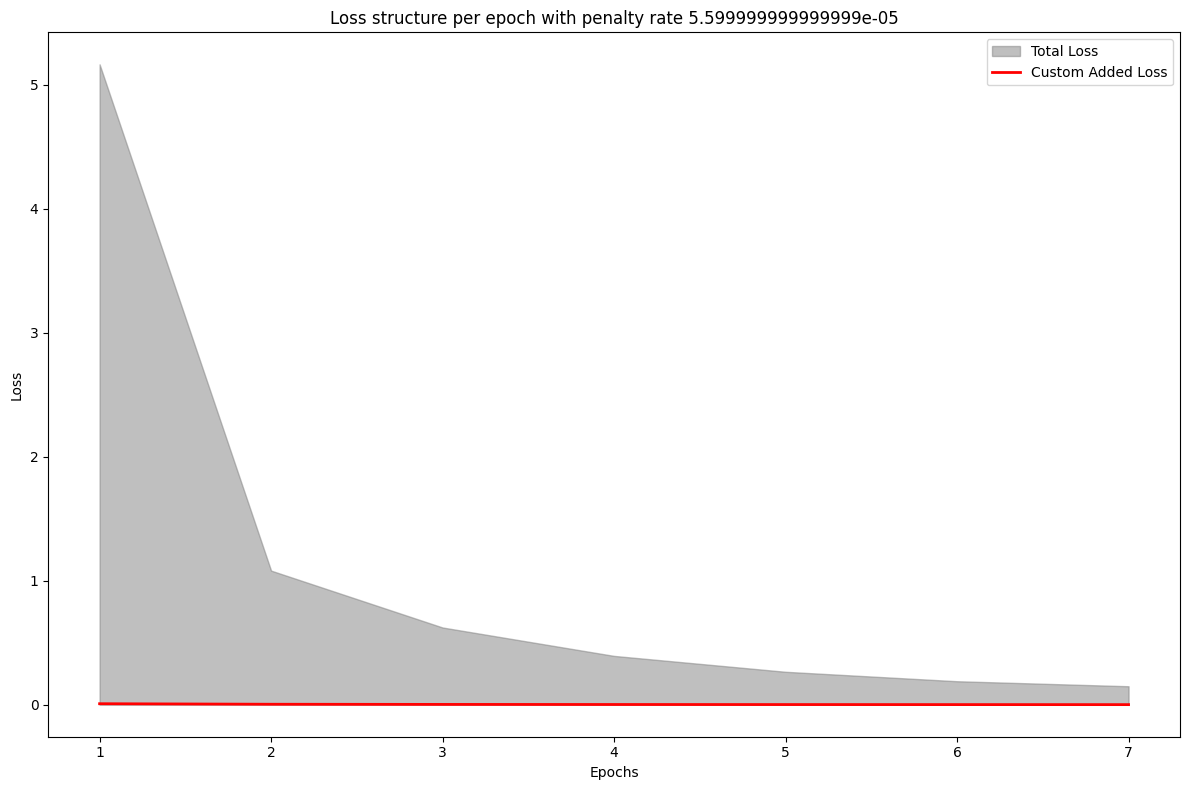


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x4210ac970>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4880ef7f0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3ffc537c0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x355c38880>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x45407c520>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3fe921a30>
  - Input Shape: (None, 10)

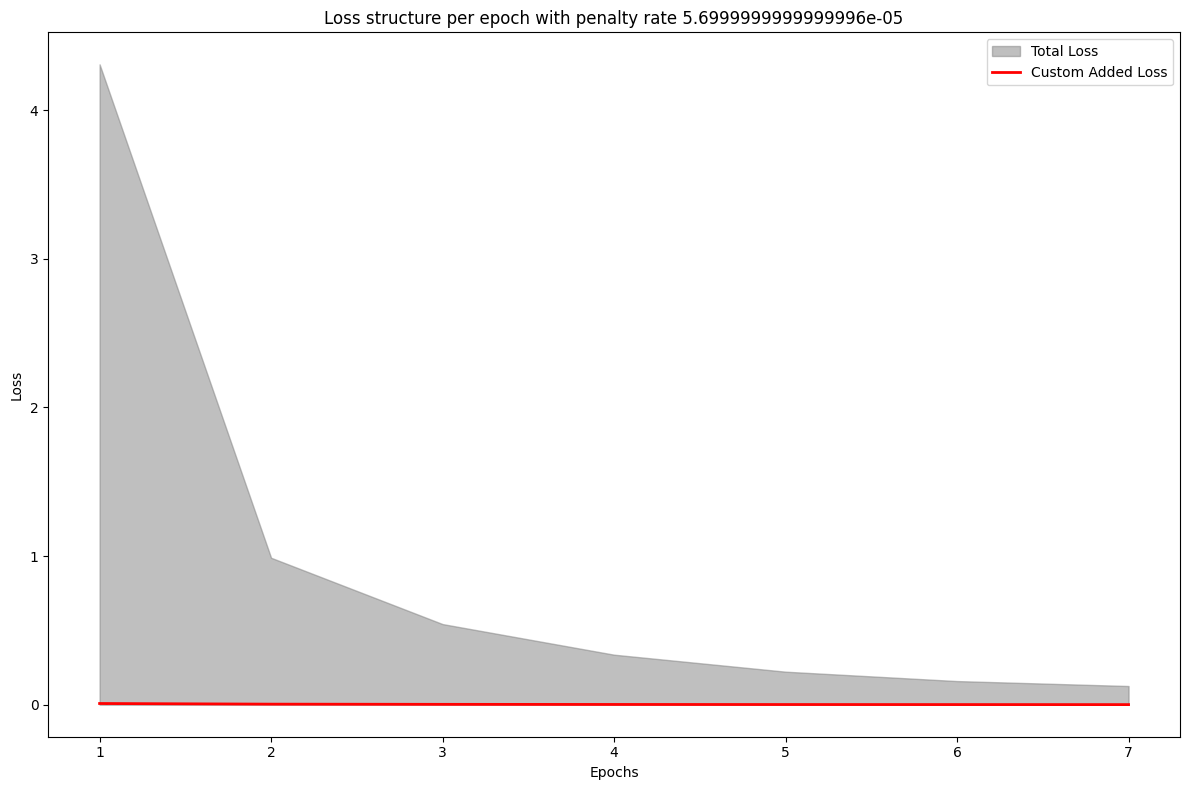


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3d7d1c8e0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x3805575e0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x384116d60>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3423550d0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x45474d670>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x45471cbe0>
  - Input Shape: (None, 10)

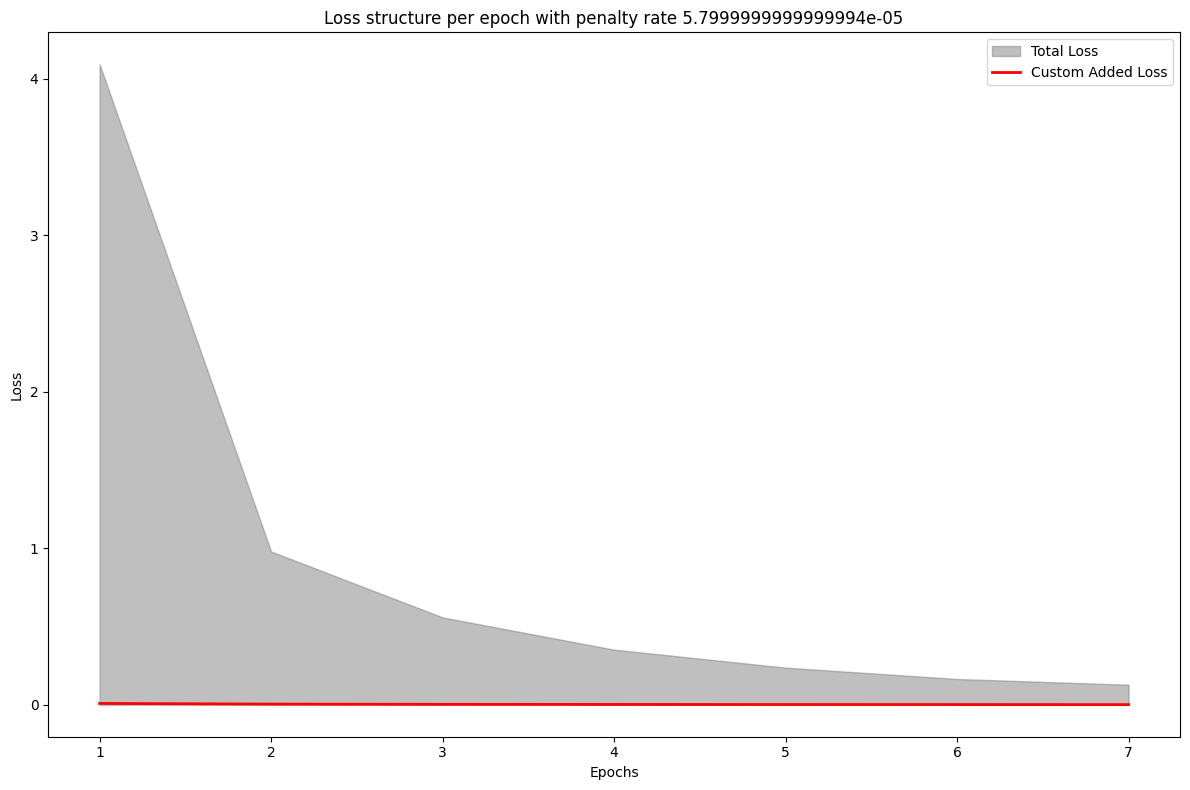


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x49bb89d60>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x459596520>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x49bb796d0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4bd7107c0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4595ec580>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4bd7104f0>
  - Input Shape: (None, 10)

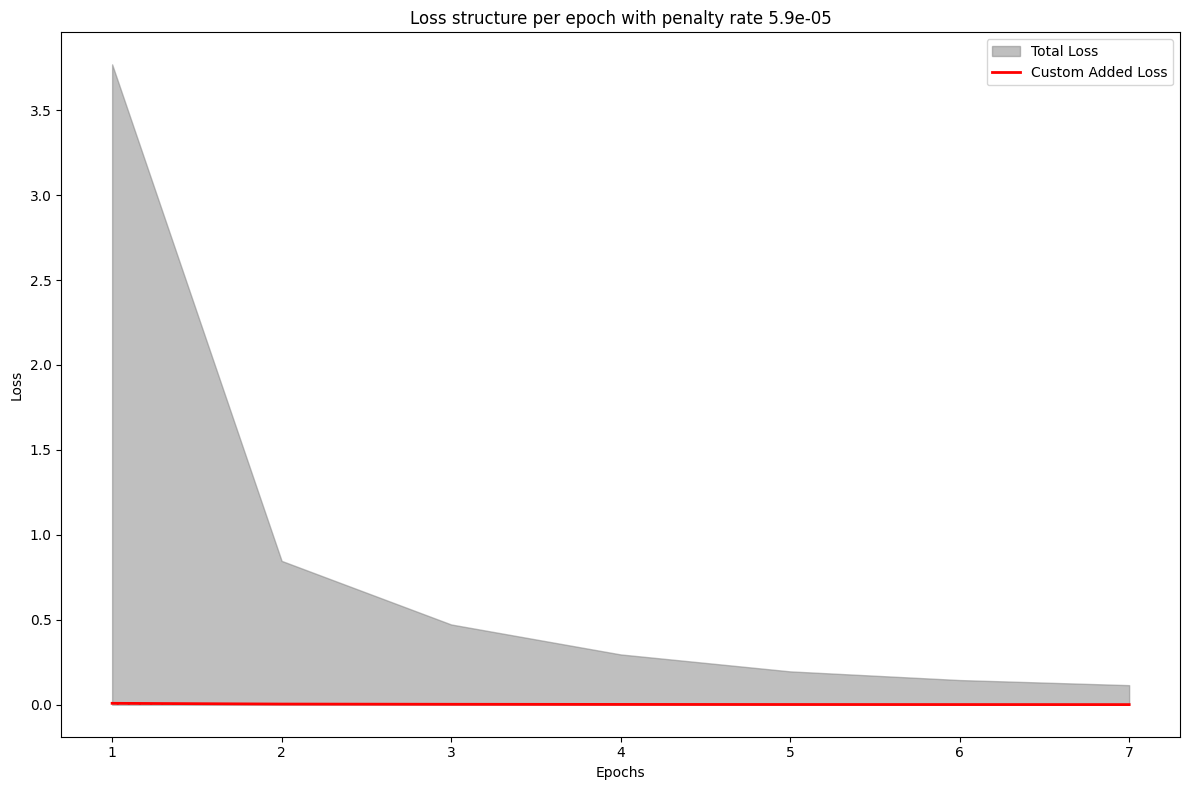


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3c7edb670>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x355da2c40>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3ffbf0a90>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3c7e8b100>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3842e18b0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x47339aa30>
  - Input Shape: (None, 10)

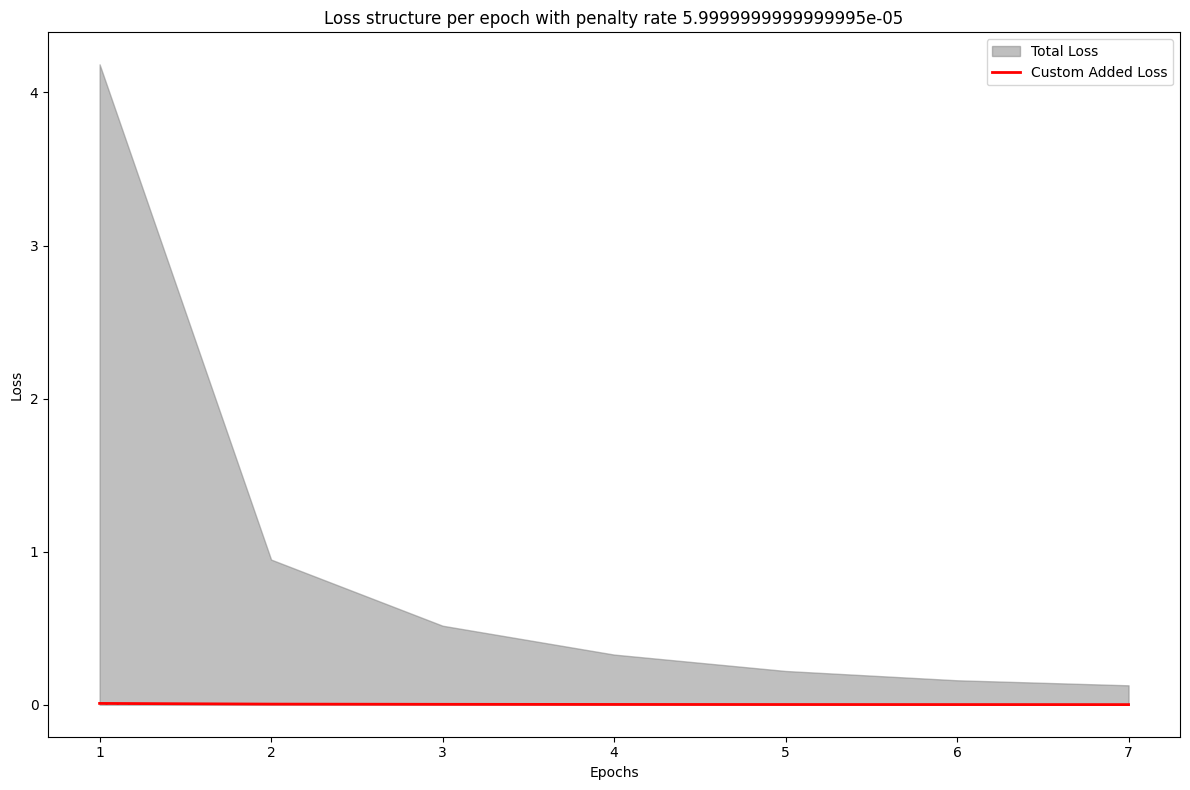


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x464fb1490>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x34237e400>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3886171c0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x454221fd0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x318864ac0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x345b5f550>
  - Input Shape: (None, 10)

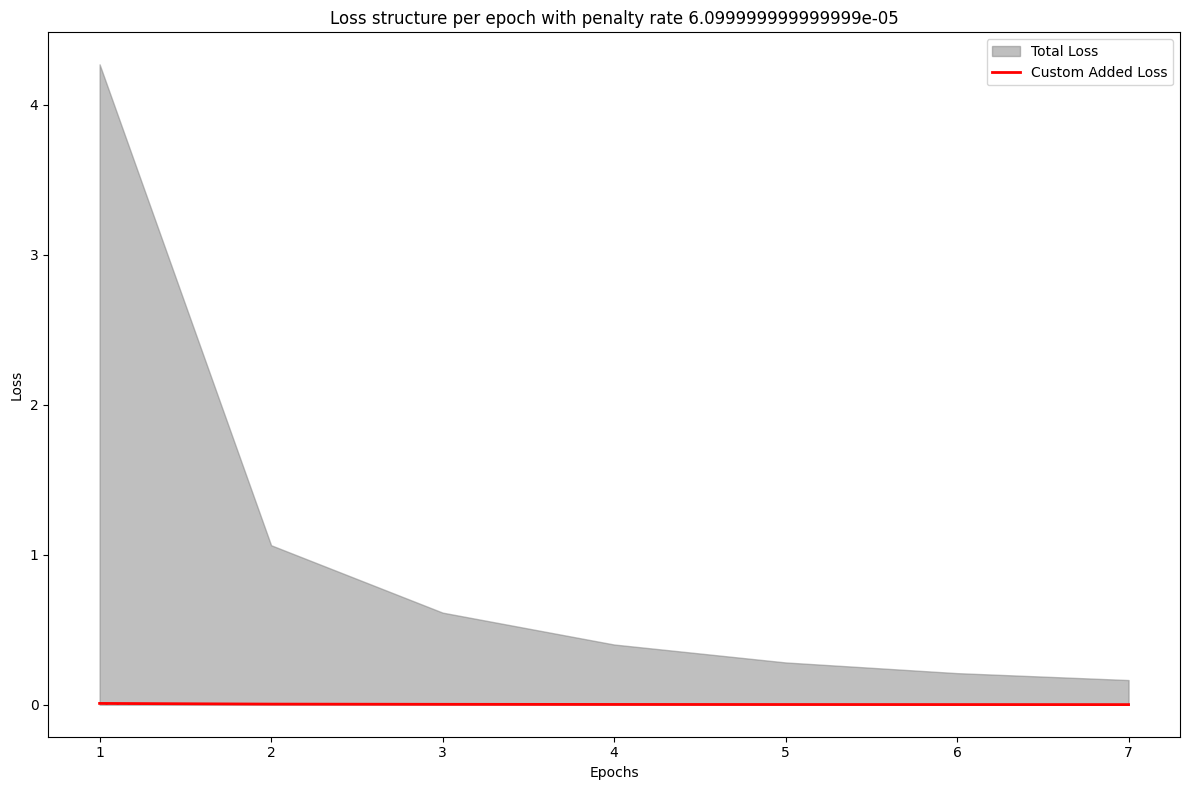


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x45473ecd0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4592bd7c0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3c7e8bf10>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3fc37cf40>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x42127a910>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3ca95d760>
  - Input Shape: (None, 10)

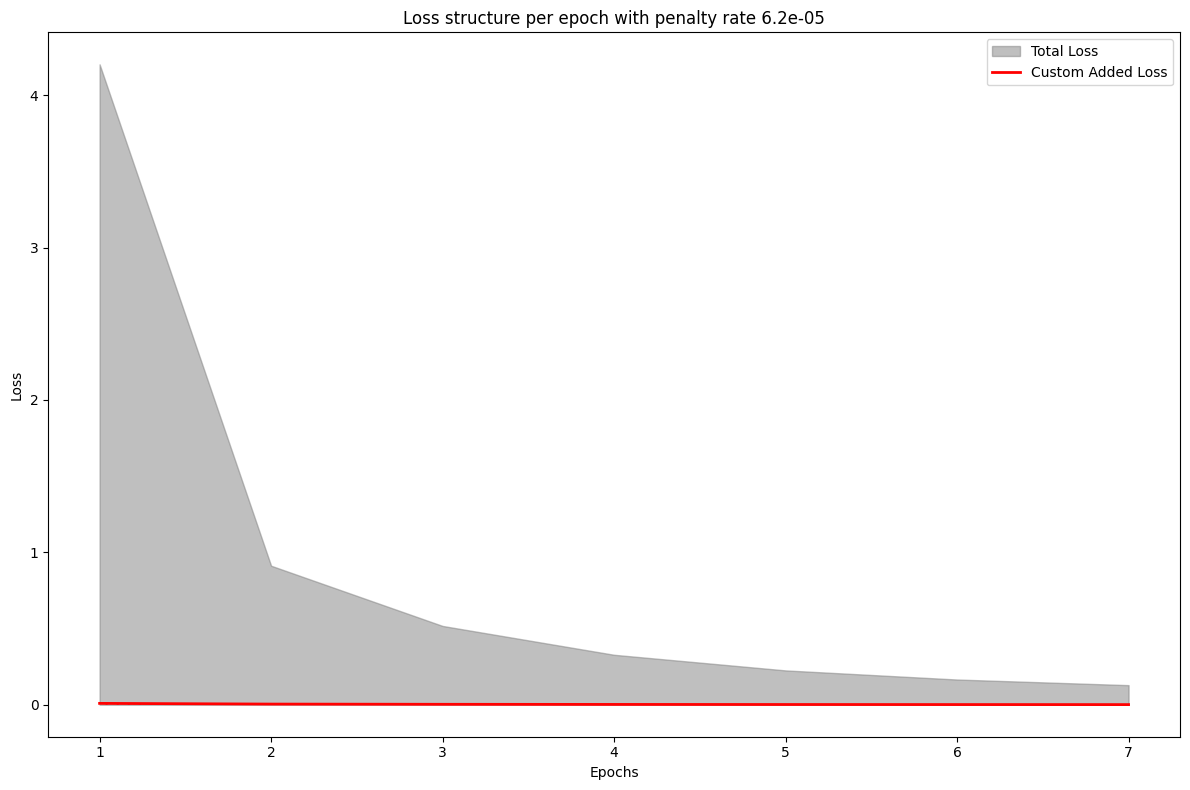


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x345c63b20>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x352847670>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3ffb21e80>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x51658f220>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x31f272130>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x44f7819a0>
  - Input Shape: (None, 10)

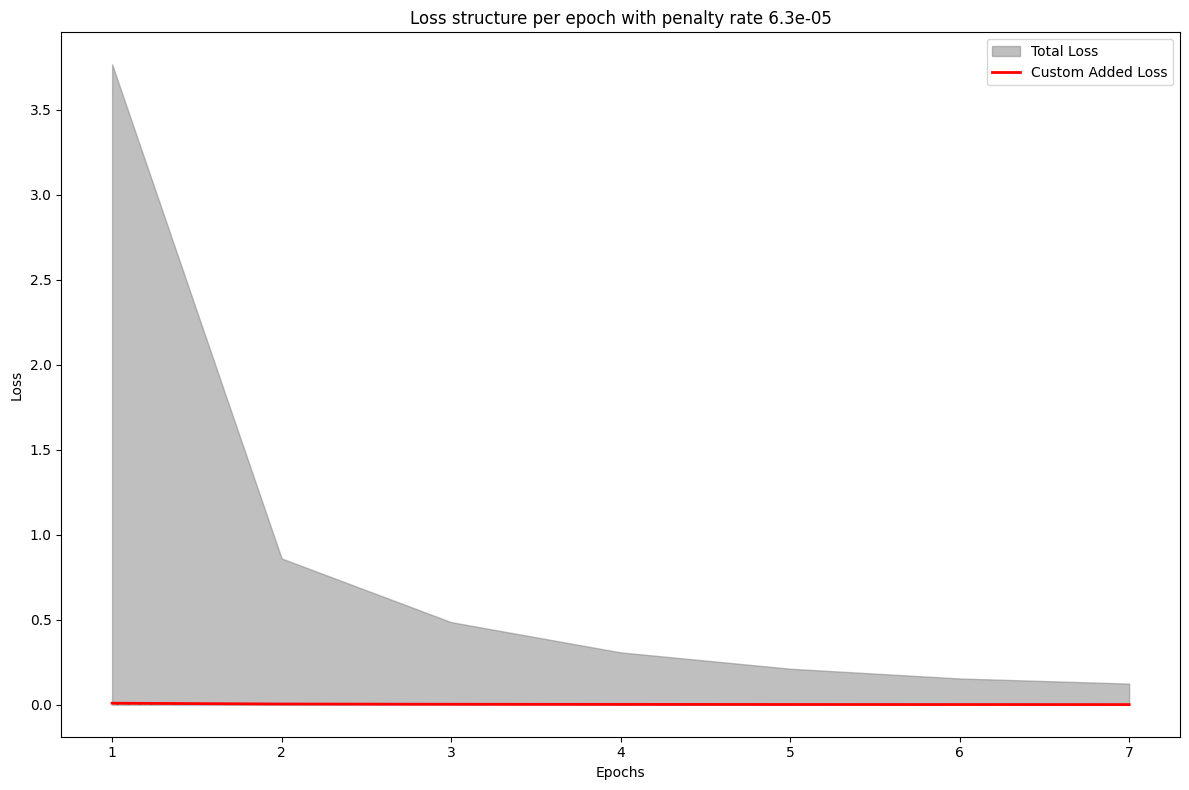


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x49f41d3d0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x44f79cf70>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x47c70f880>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x44f7c56d0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x49f4242b0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x49f4bda90>
  - Input Shape: (None, 10)

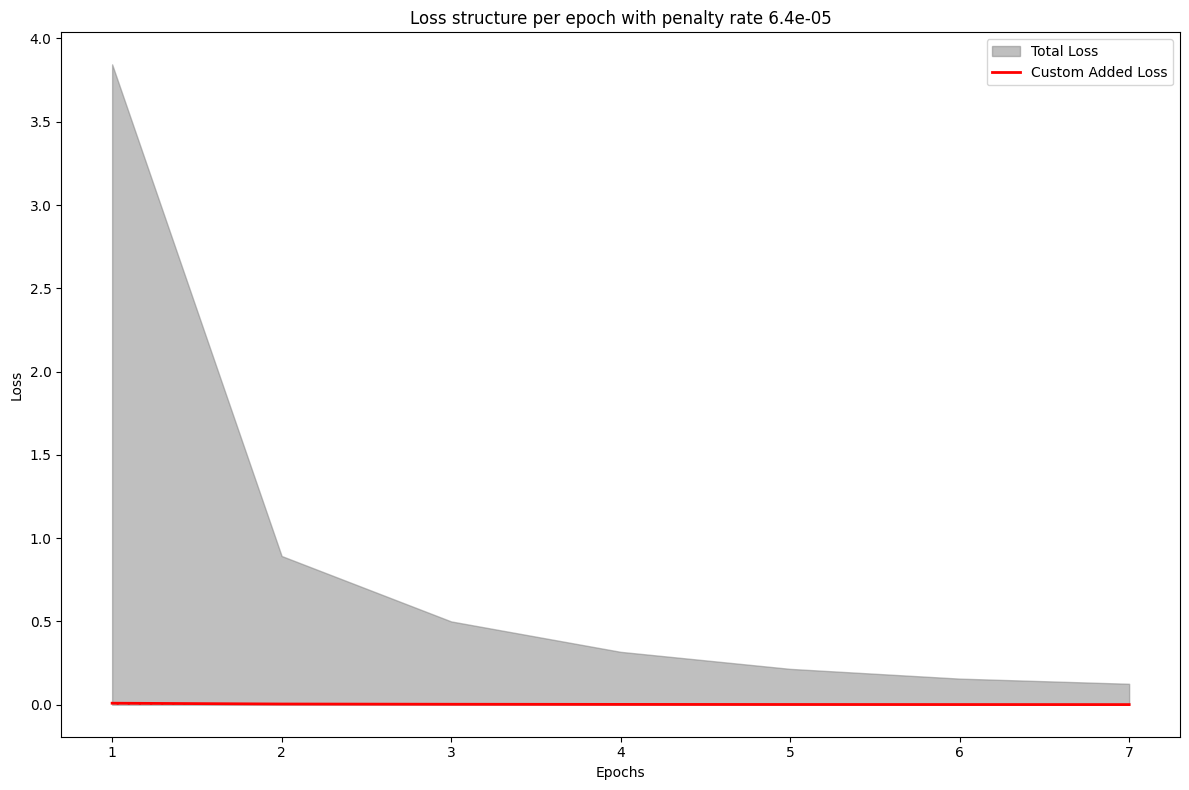


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x44f565940>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4f3db5bb0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3ffbf0070>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4d6790b20>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x49f5a8d60>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x49f5a8220>
  - Input Shape: (None, 10)

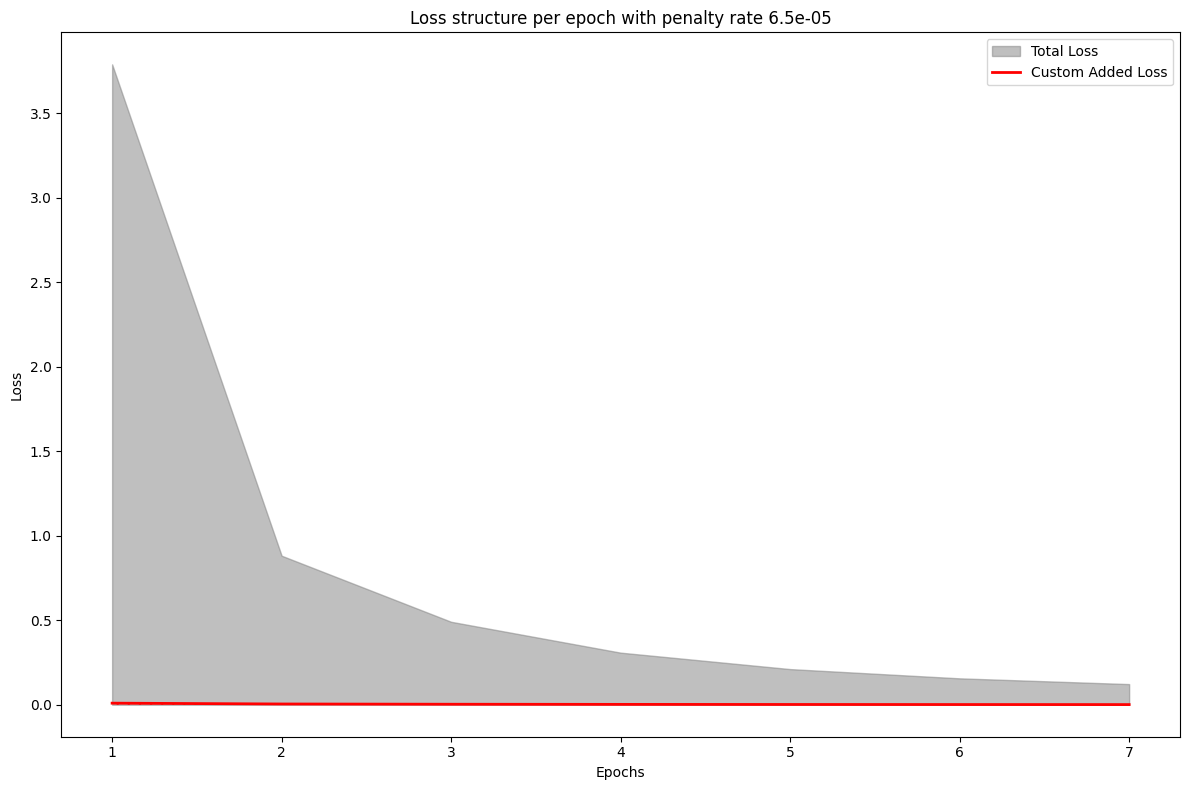


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x49f5a8820>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x44fbbb940>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x44f79cdf0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4f3d8ea00>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x44f7da5b0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x49f48d430>
  - Input Shape: (None, 10)

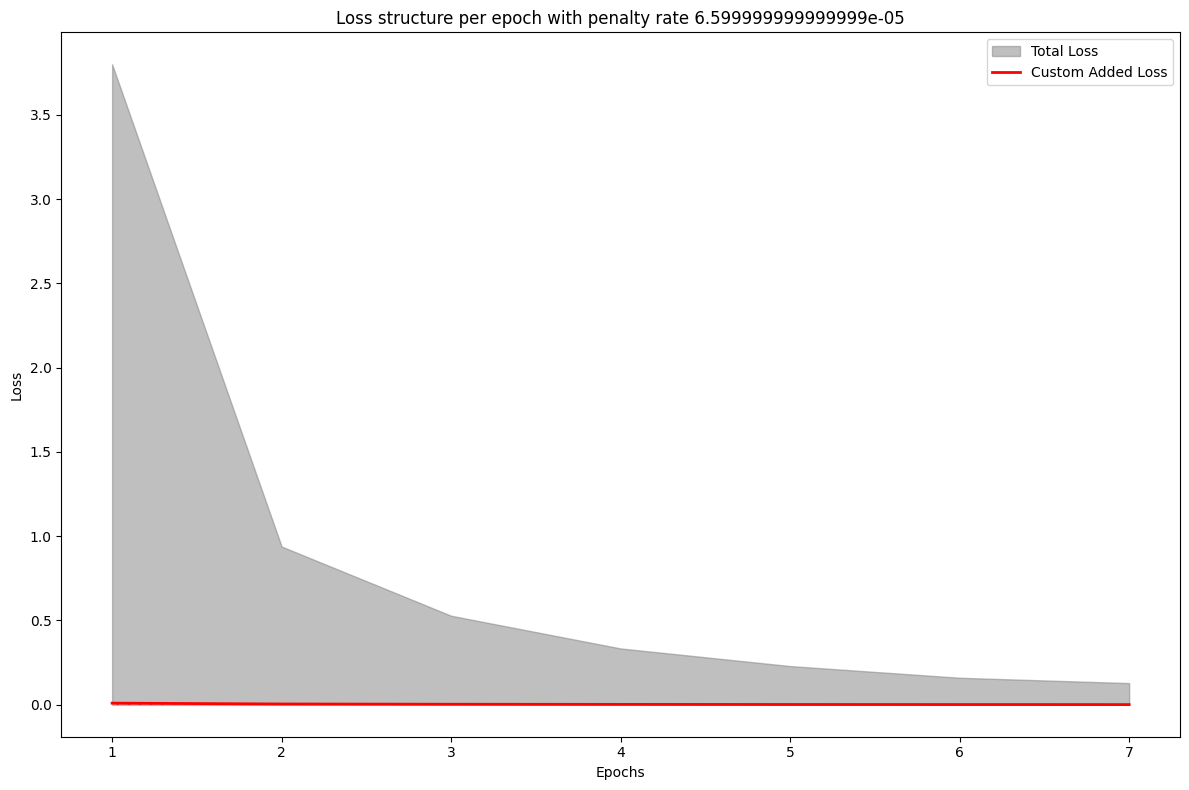


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x49f5d1bb0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x175f69040>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3424c2310>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x34ba13ac0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3144084f0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3e947d7f0>
  - Input Shape: (None, 10)

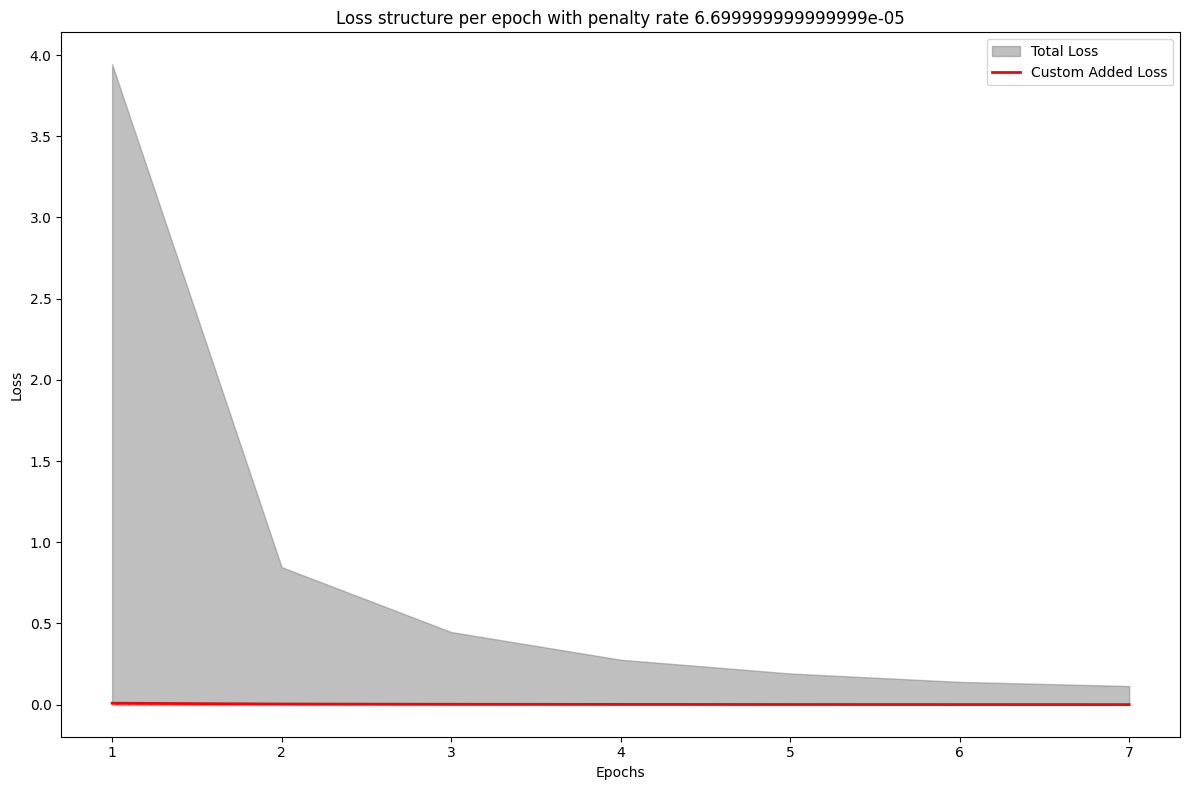


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x4595804c0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x5167c1580>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x49f4382b0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x49f45cc40>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4d6788220>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x49f16f0a0>
  - Input Shape: (None, 10)

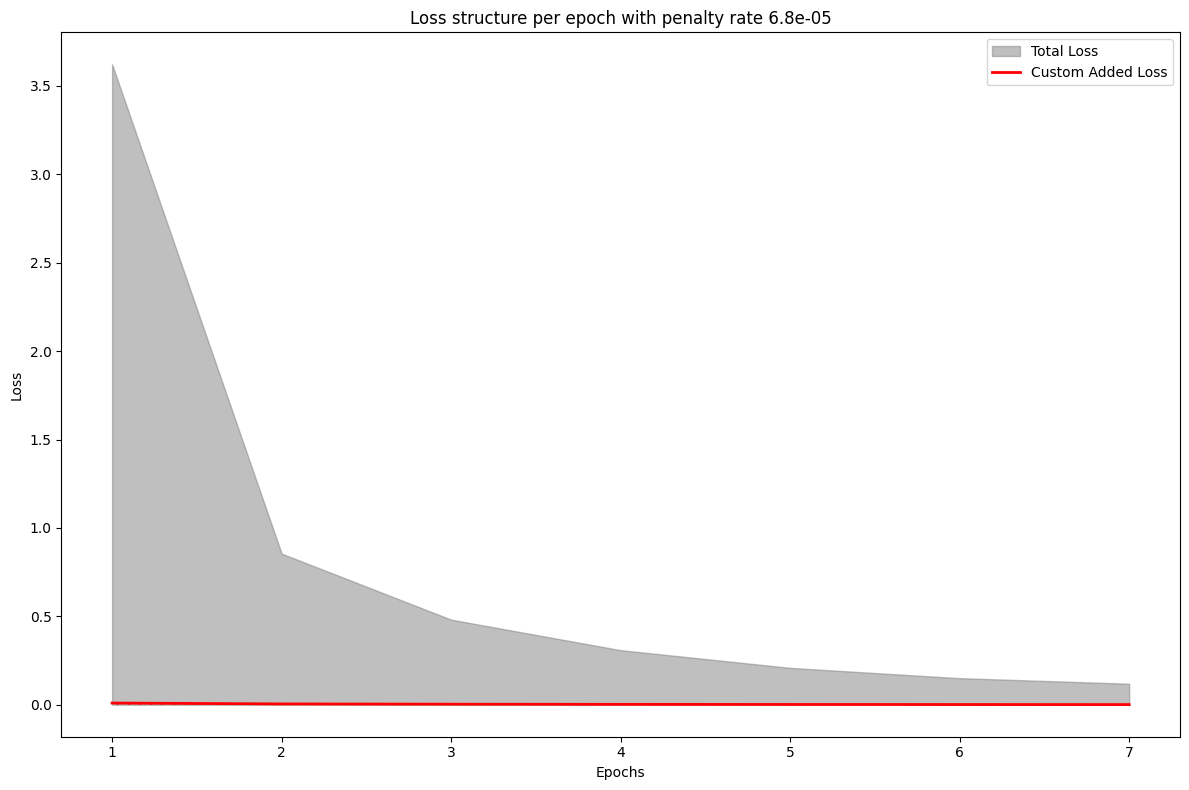


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x49f16fac0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x34b28efd0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x49f190850>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3d0711fa0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4aaabcb50>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x34ba1a9d0>
  - Input Shape: (None, 10)

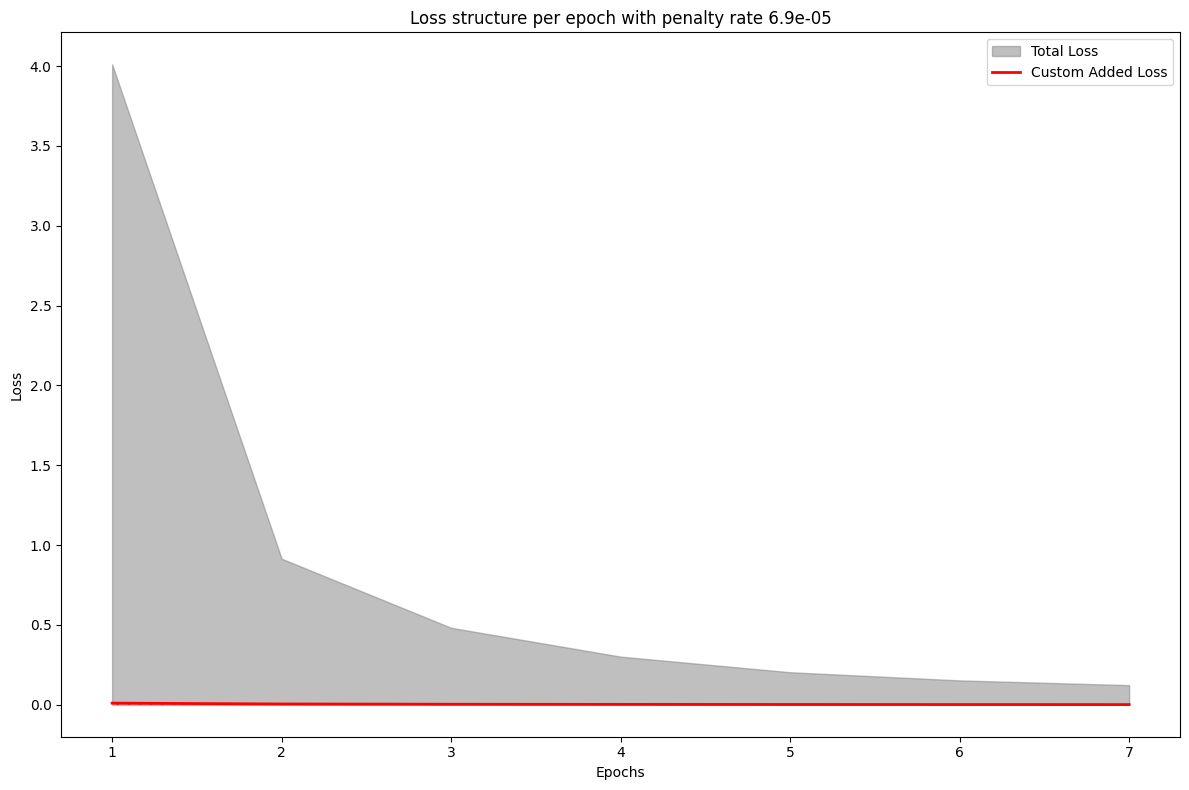


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x384110ee0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x472b358b0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x4f3d16580>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x472b47070>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3fc3209d0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x472b47b50>
  - Input Shape: (None, 10)

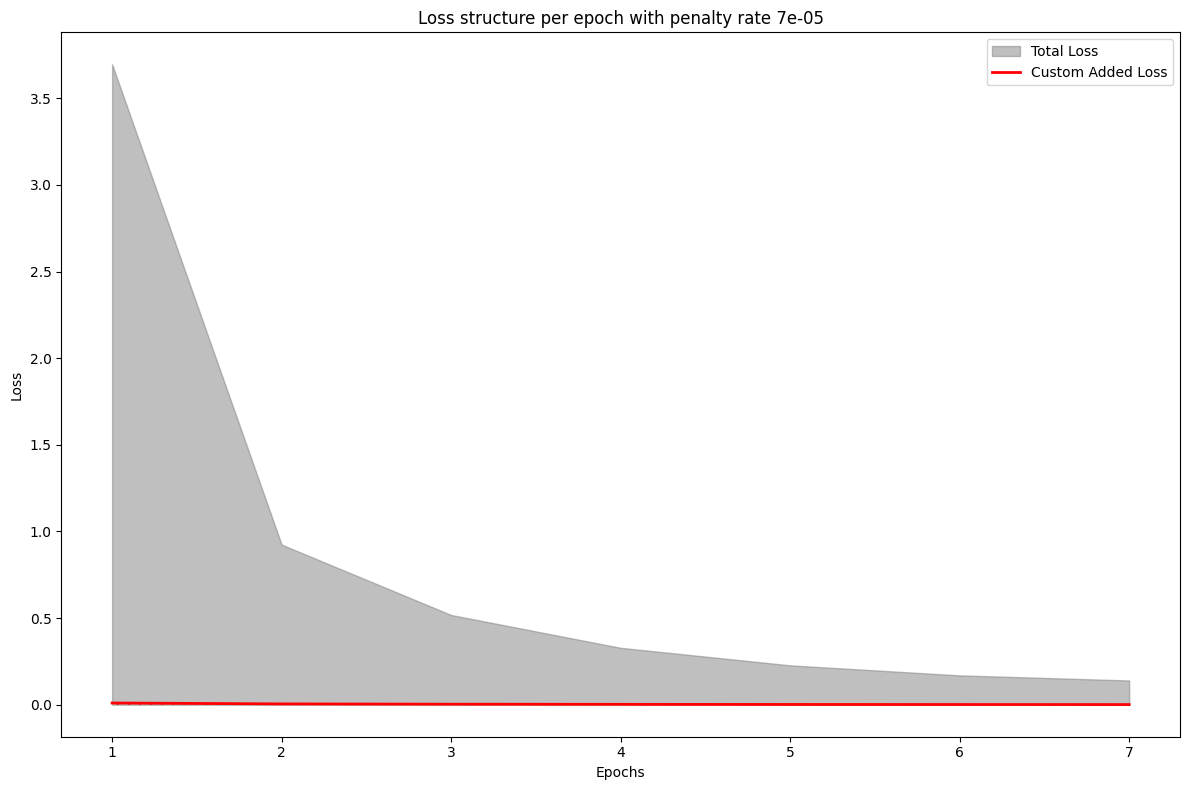


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x4bd7dc460>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x49f4f7370>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x4f7c89a00>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4bd7c4220>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x472be4b20>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4a2c13430>
  - Input Shape: (None, 10)

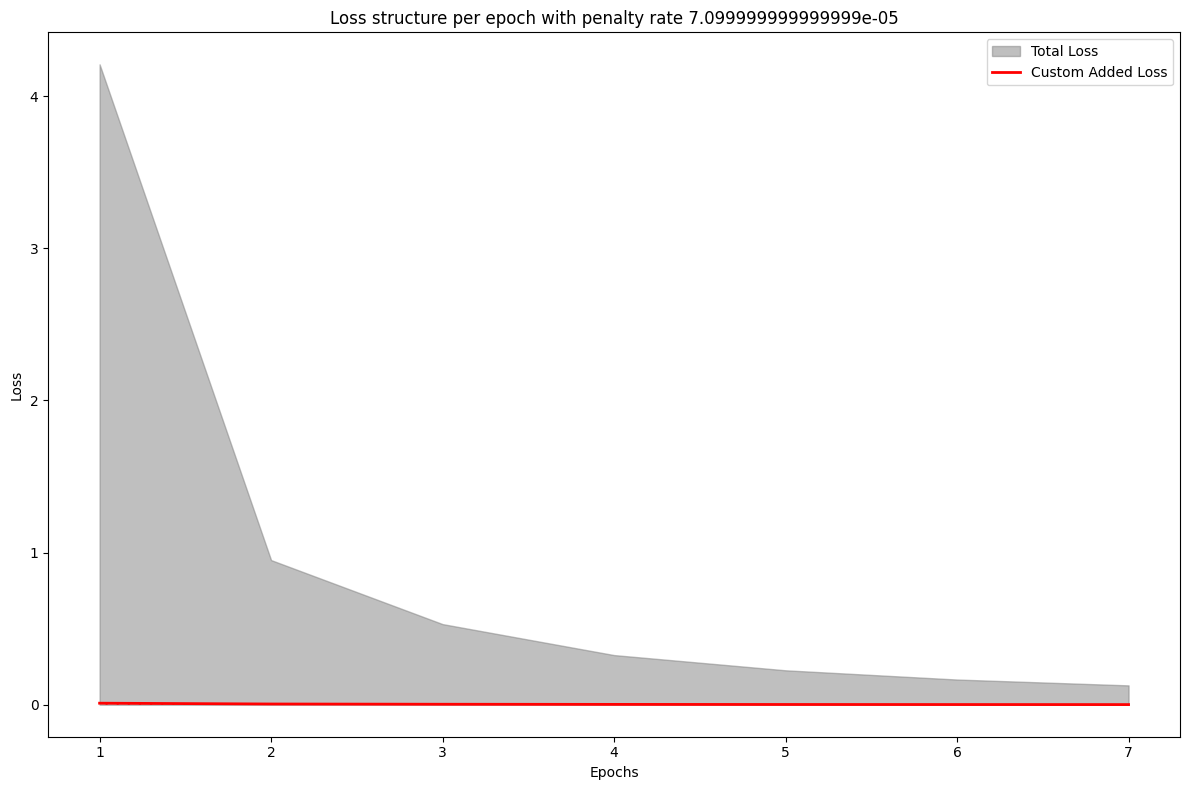


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x380e90d00>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4d6f9afa0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x4f3dea7c0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4f3df4250>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3d7d66cd0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4f3c4b5e0>
  - Input Shape: (None, 10)

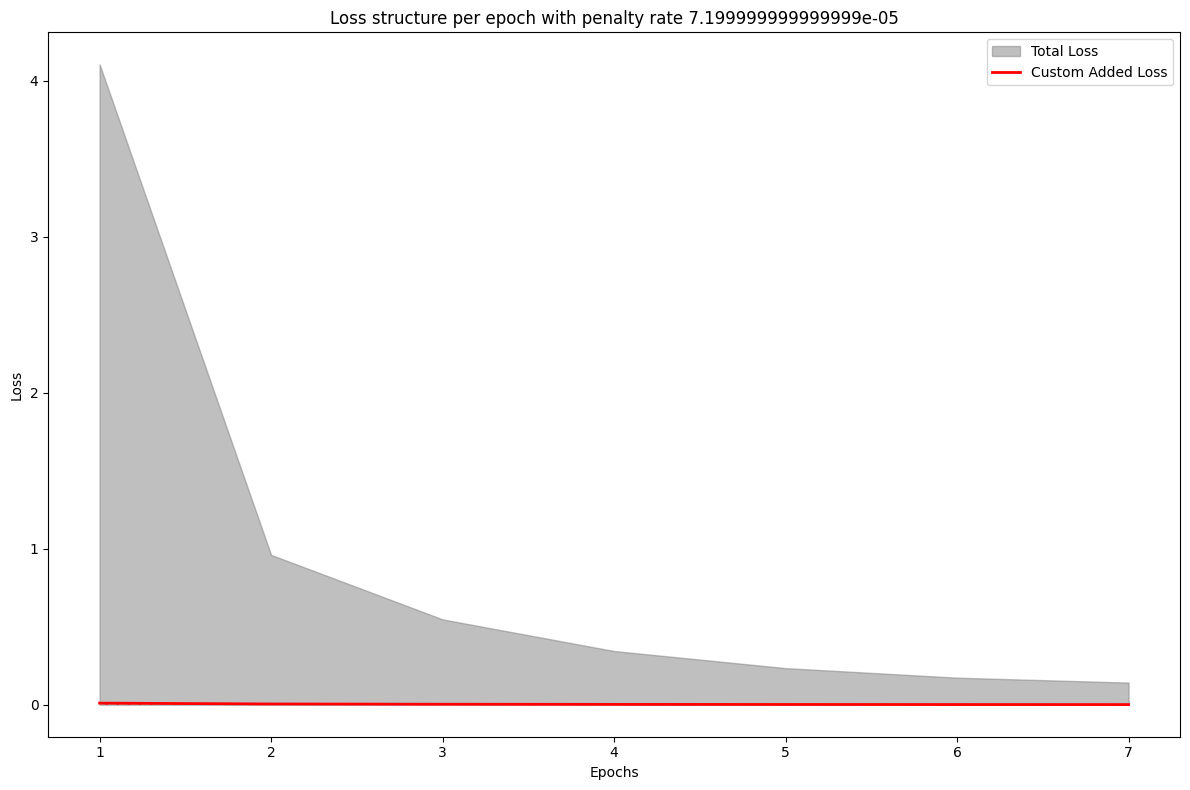


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x4a2c4b0d0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x34ba32be0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x384120100>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x380e90730>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x44f72da60>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x17689ba30>
  - Input Shape: (None, 10)

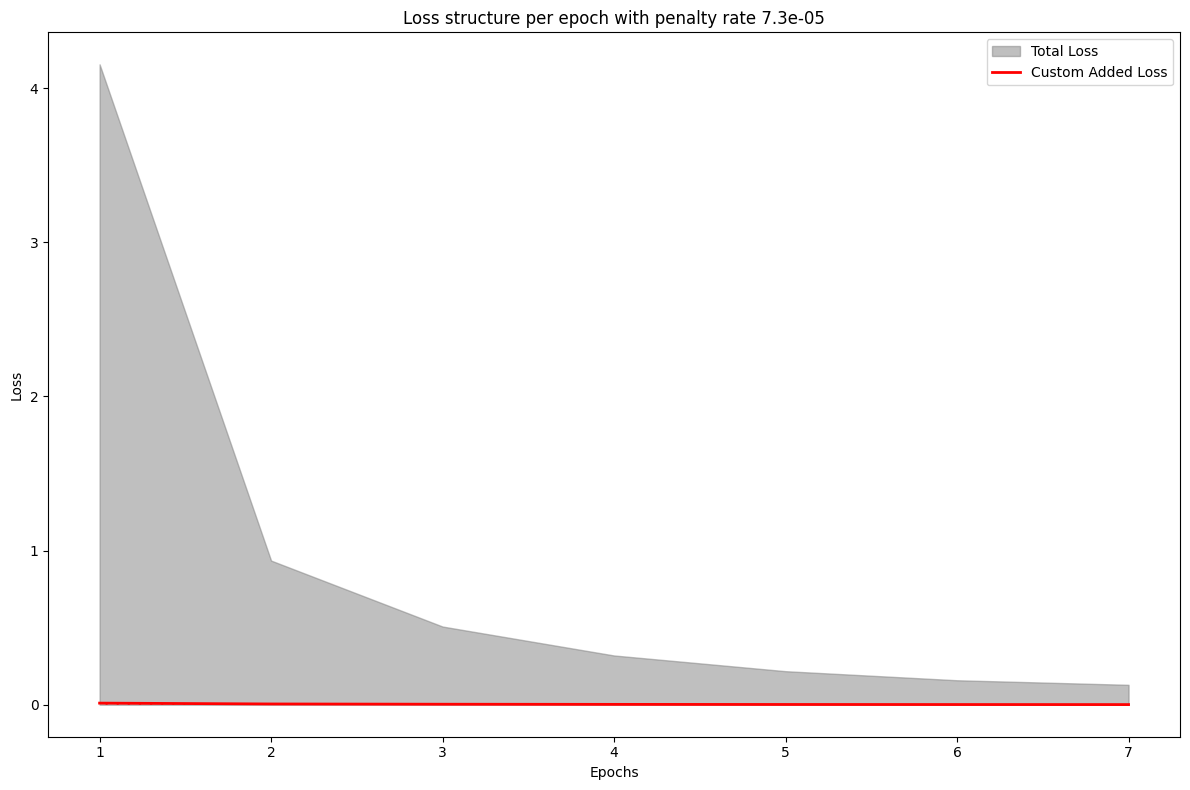


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x44fbc1550>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4a26e64f0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x4415c1100>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x542b08b50>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x40596fa90>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x380b25040>
  - Input Shape: (None, 10)

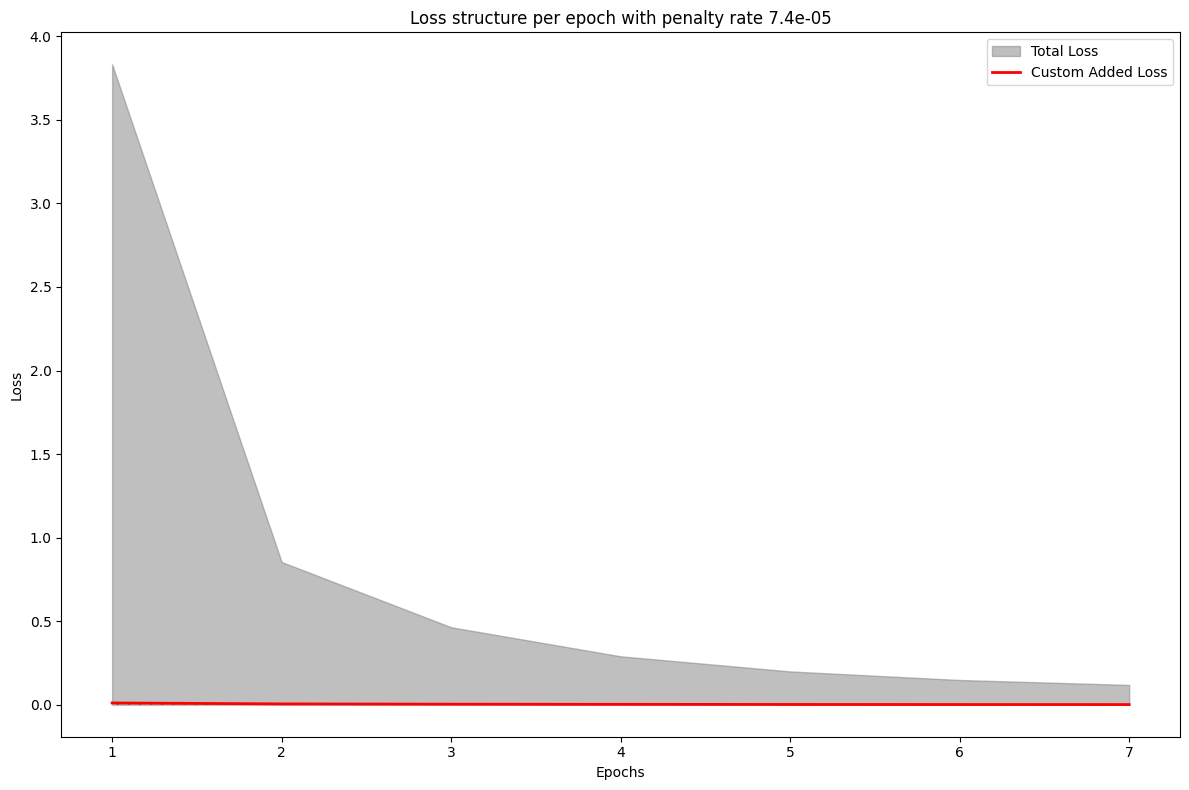


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x44fb93280>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x47337b430>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x4547dea60>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x49f1dea30>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3fc310e20>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4f8685ac0>
  - Input Shape: (None, 10)

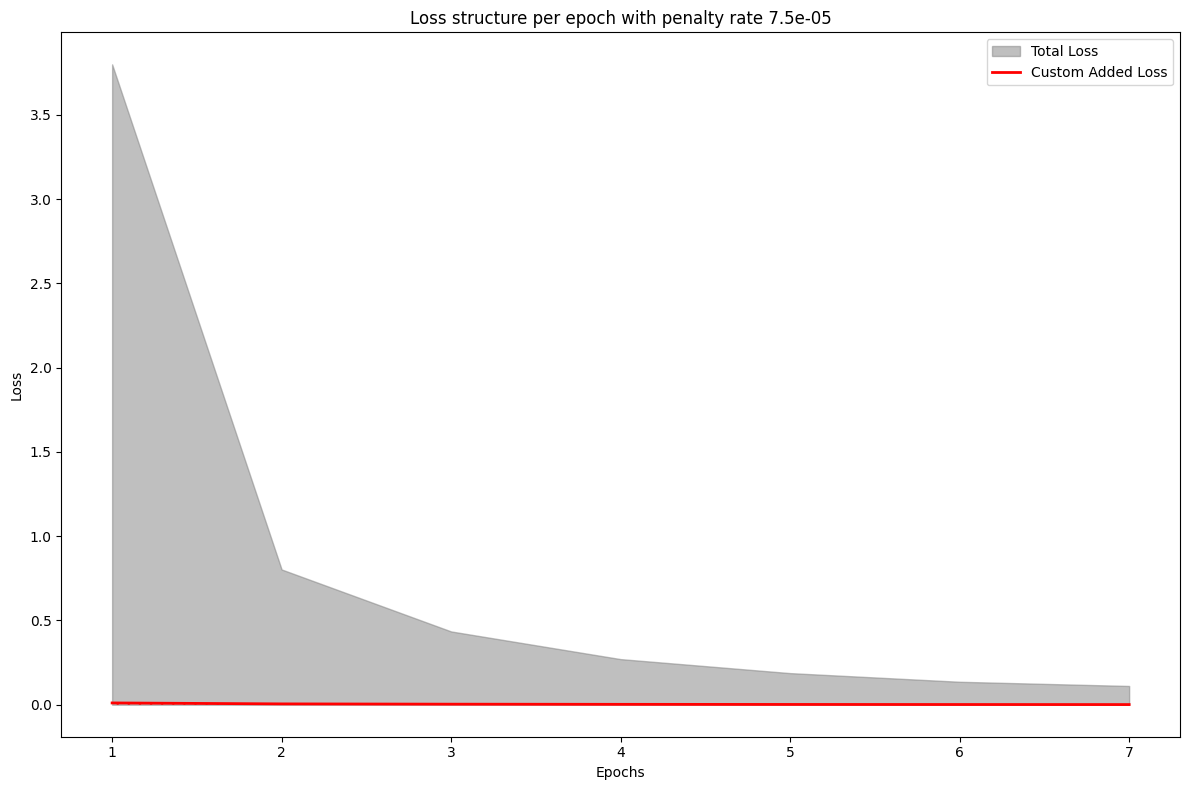


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x472b1ad30>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4f3de53a0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x49f46c760>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x47c7584f0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4f3de5f10>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x47c758700>
  - Input Shape: (None, 10)

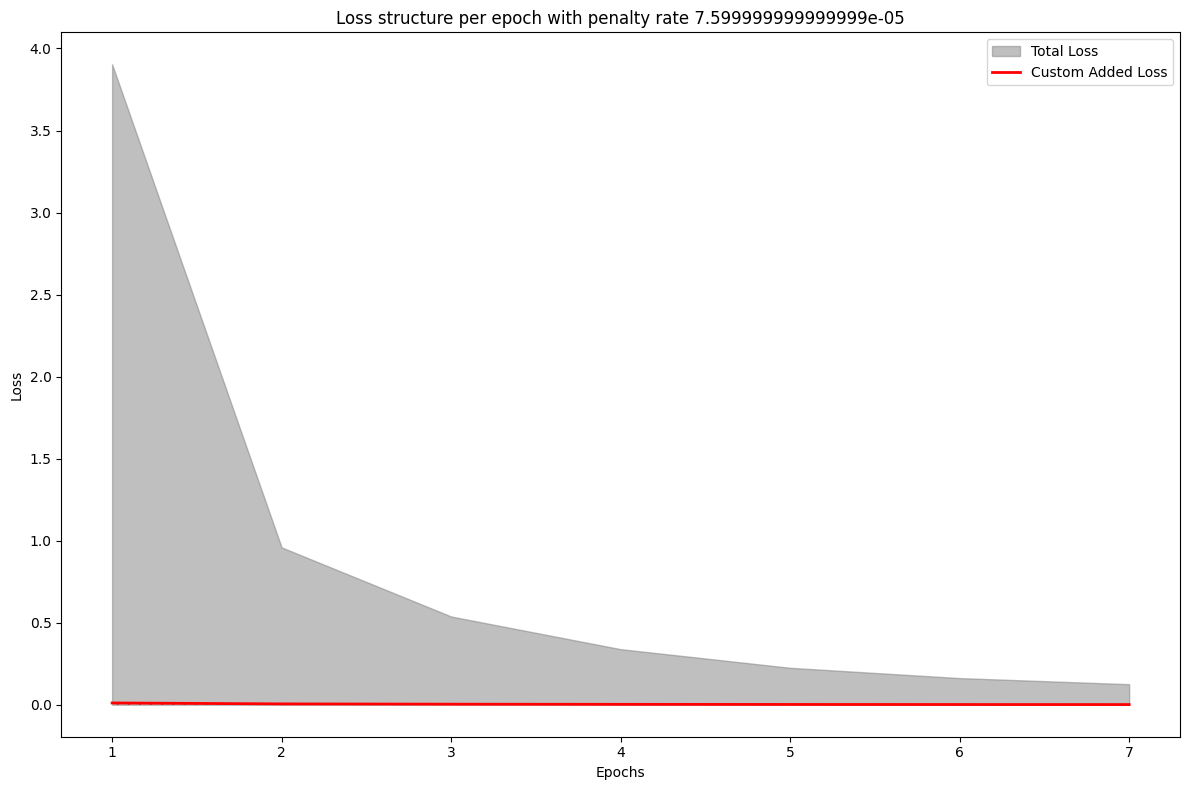


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x4547b2760>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x44fb4ca90>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x472d7d070>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x542945250>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x44fb46640>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x542945d60>
  - Input Shape: (None, 10)

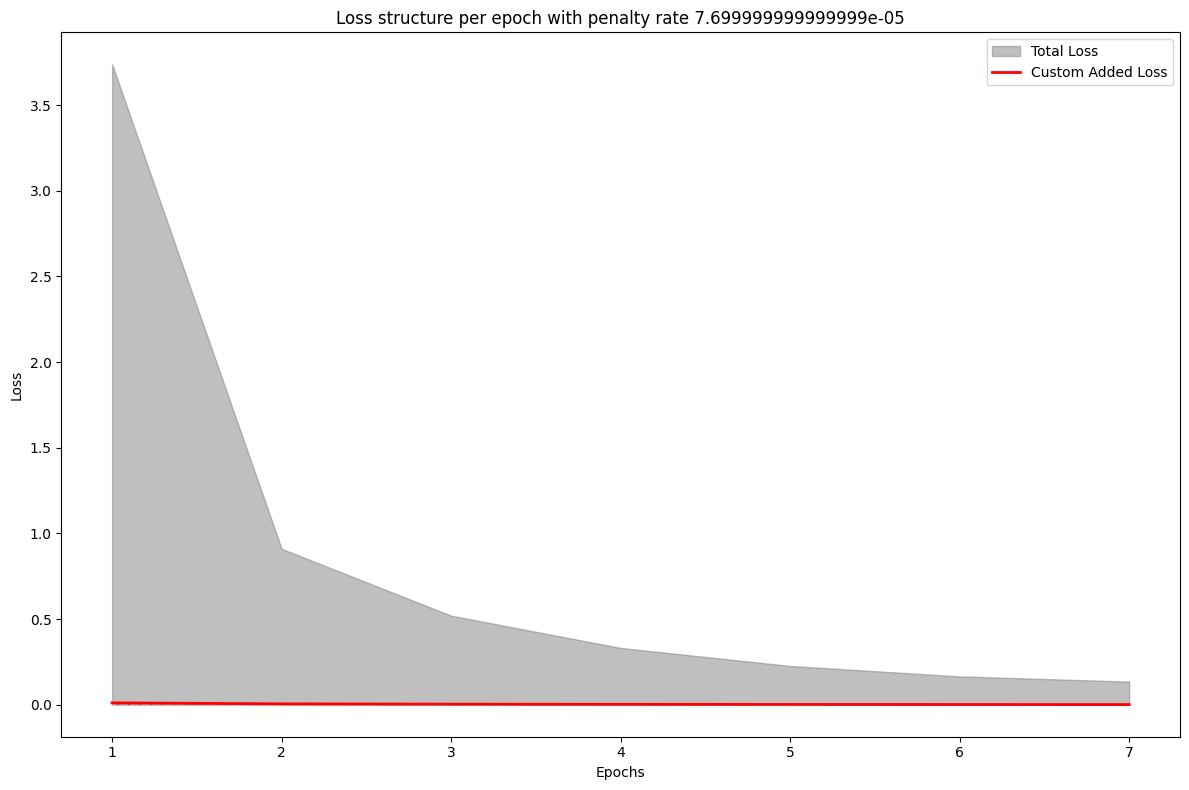


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x52b56b4f0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x472e787f0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x52bc964c0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x52c18eca0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x52bc31c40>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x52bca67f0>
  - Input Shape: (None, 10)

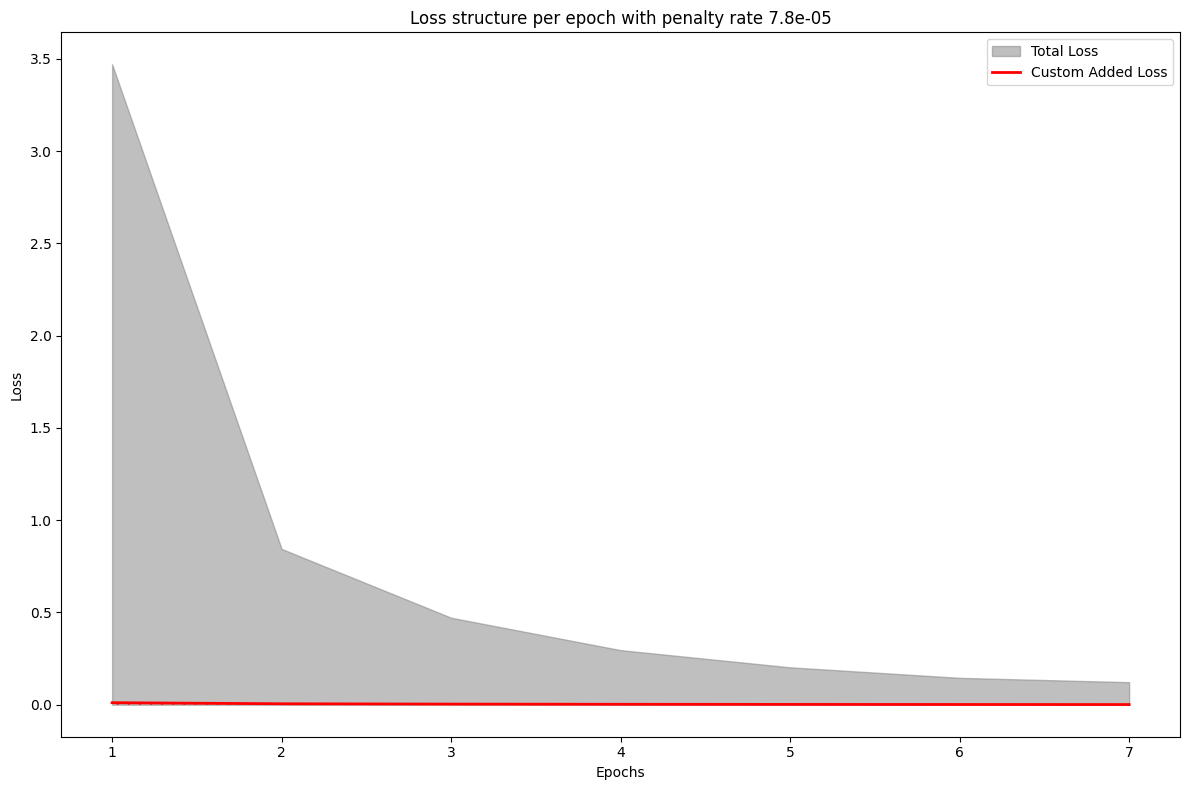


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x313a22b80>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4bd7202b0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3e9344880>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x34a249070>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3188fd640>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4f3c8c670>
  - Input Shape: (None, 10)

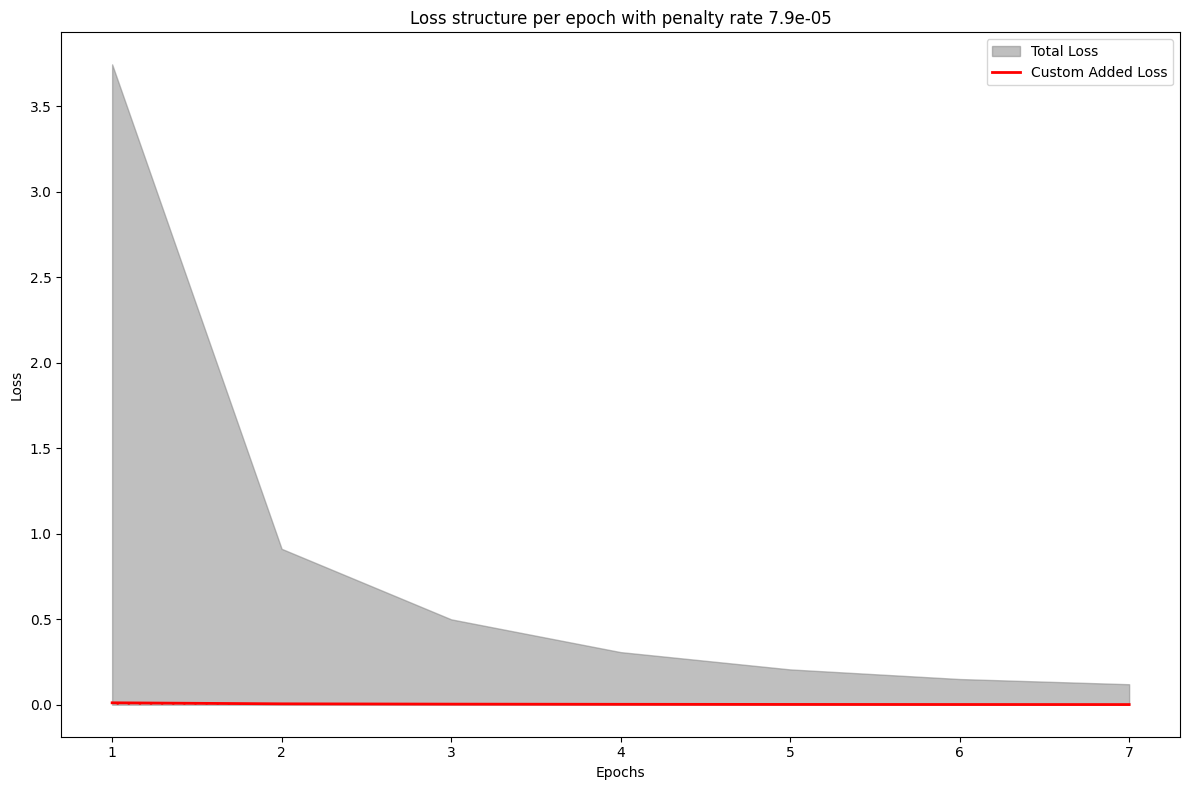


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x4f3c8ce50>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x454796070>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x4f3ca3730>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3ca91ba00>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4f7c840a0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4547de790>
  - Input Shape: (None, 10)

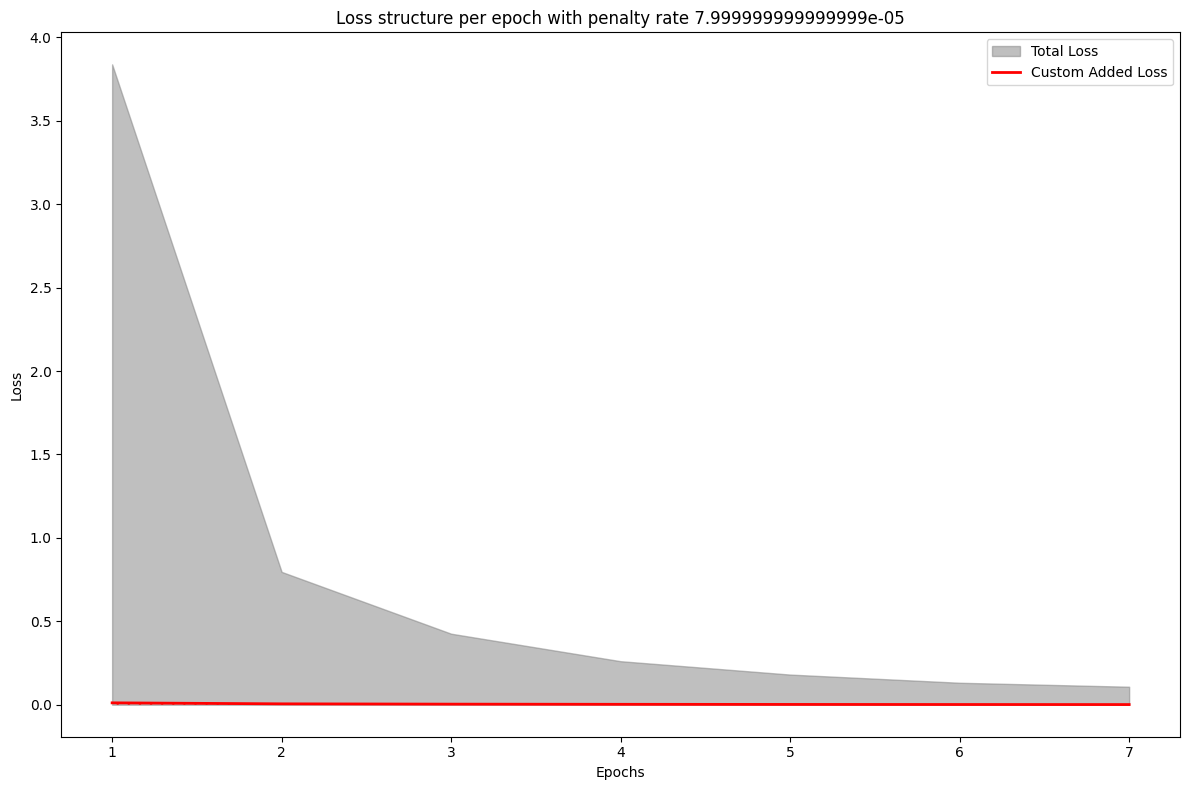


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x4361441f0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x52d38fc40>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3841d88e0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3ca903fd0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x454079400>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x5522bee50>
  - Input Shape: (None, 10)

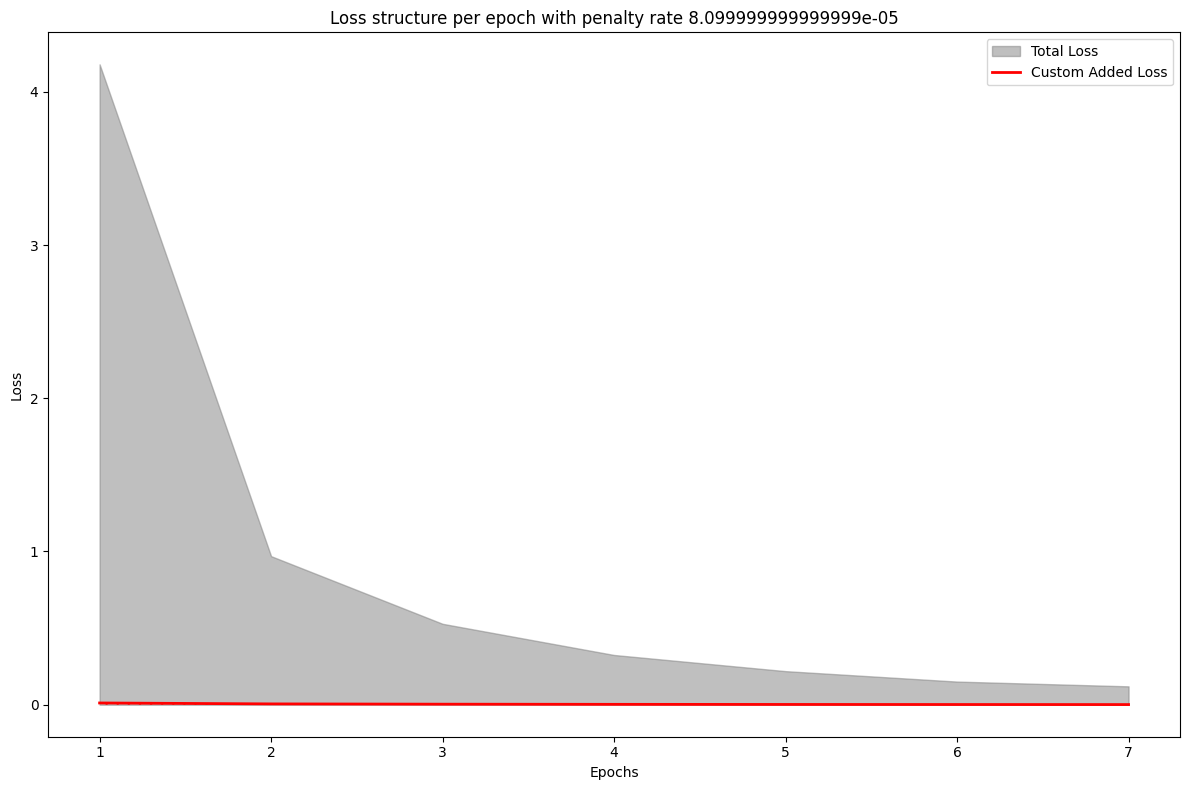


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x4f3d29610>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4592bd100>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x4f3d5b400>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3fc310700>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4f3d5b730>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3b89372e0>
  - Input Shape: (None, 10)

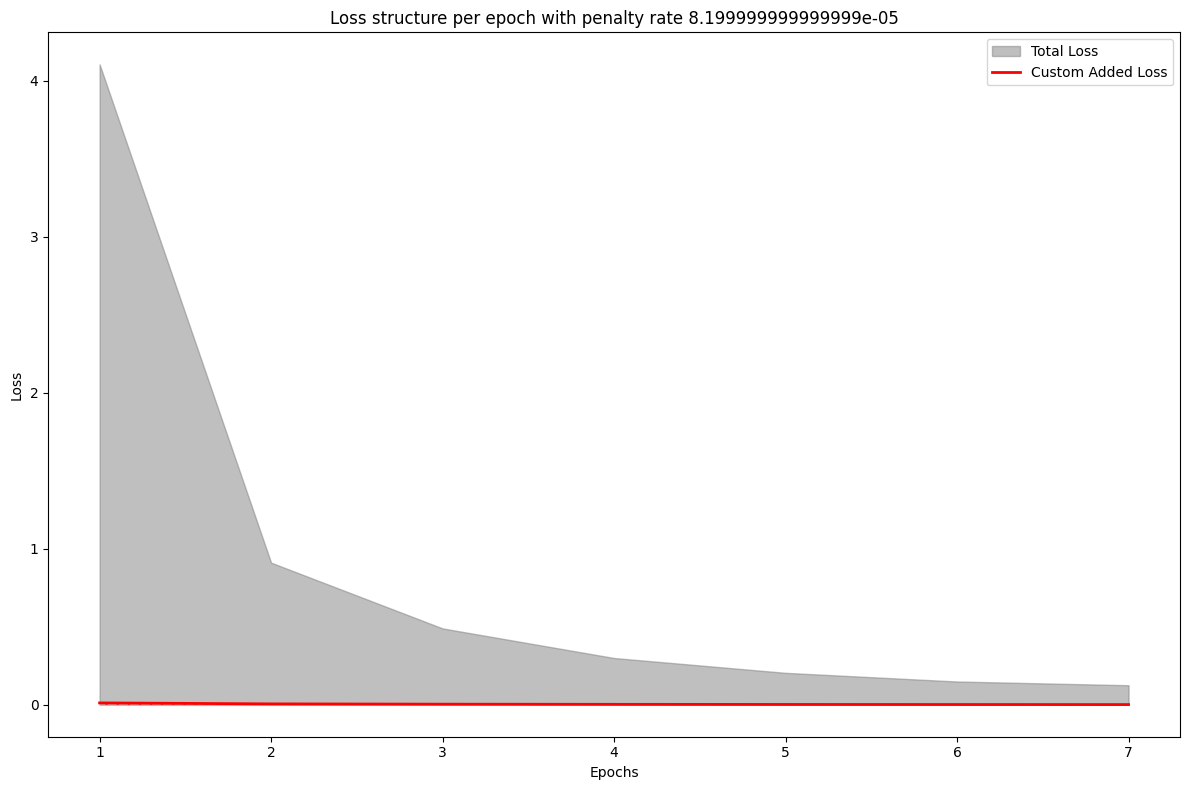


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x52c4b2b80>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x52c443640>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x51e376ee0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x51655fa30>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x405dacd60>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4540a0b20>
  - Input Shape: (None, 10)

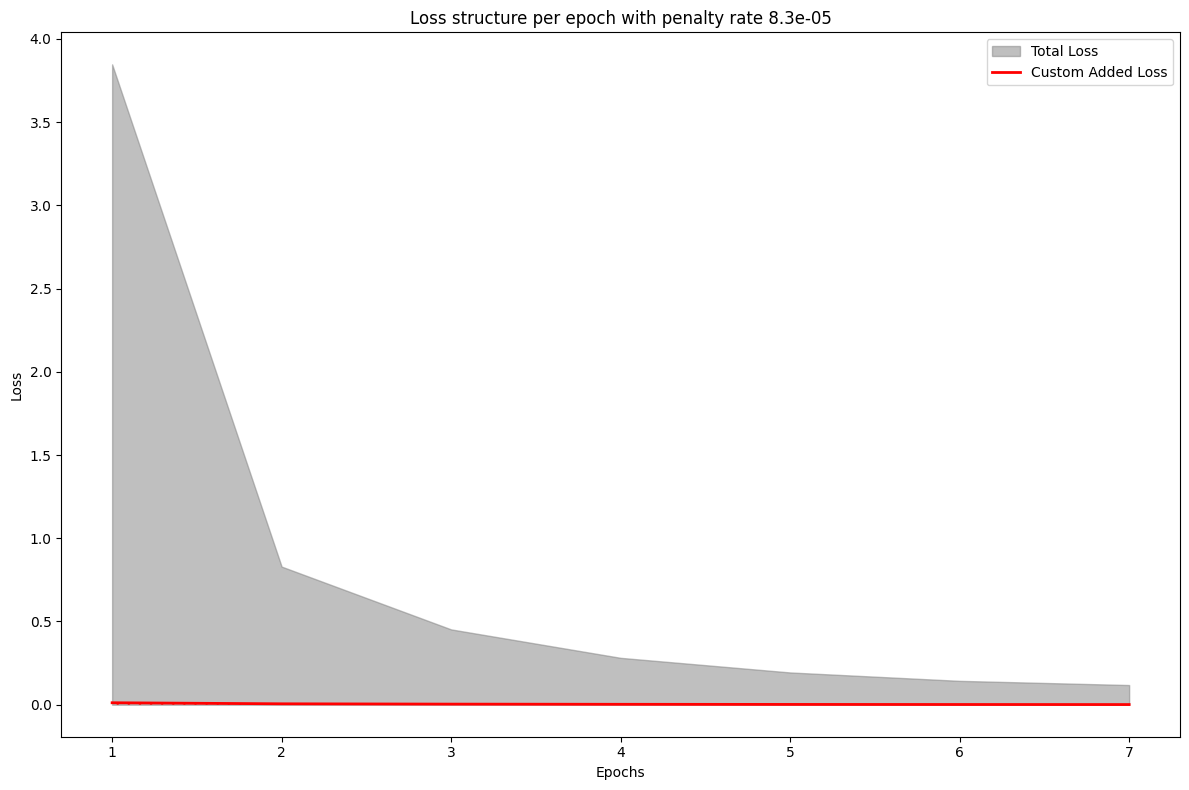


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x49f1c4a00>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4f094fe80>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x4fc73e3d0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4eff99b20>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x49f5c86d0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4f8f01a00>
  - Input Shape: (None, 10)

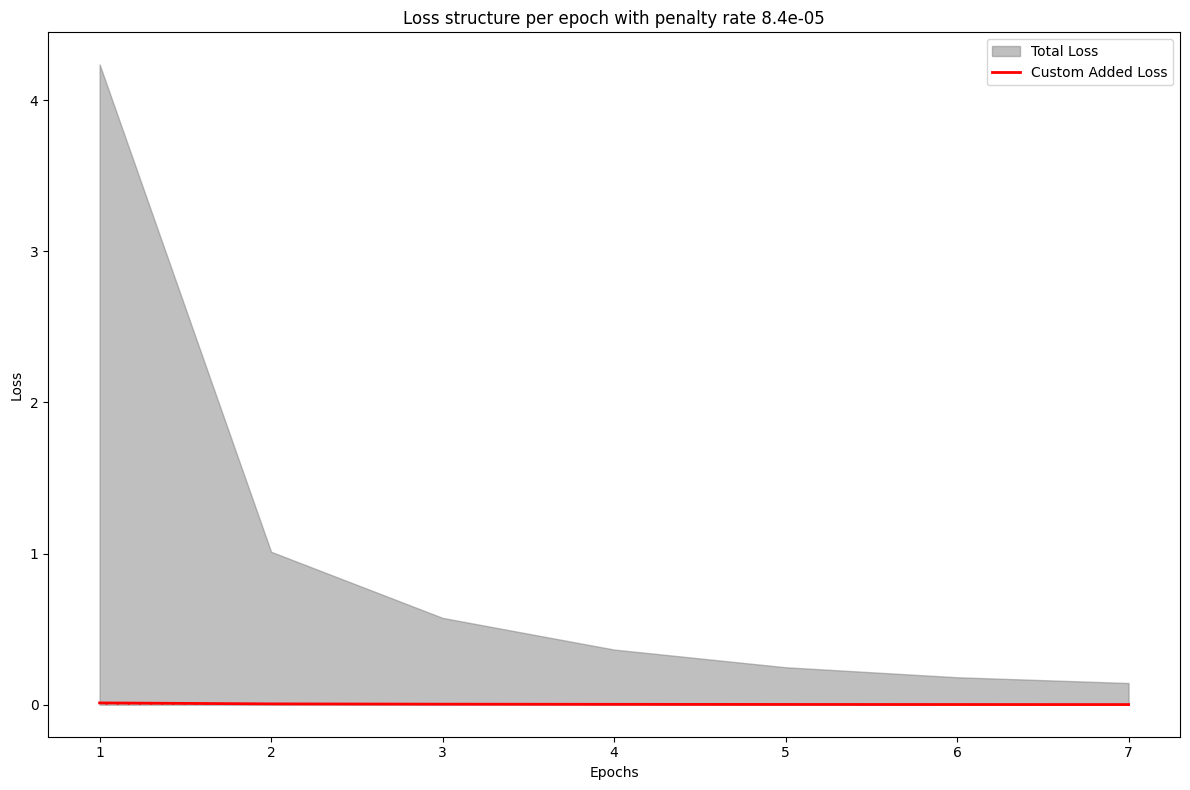


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x4f091d6d0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x558d7a850>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x558d27670>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x558d20fd0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x55981cc70>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x5529d4cd0>
  - Input Shape: (None, 10)

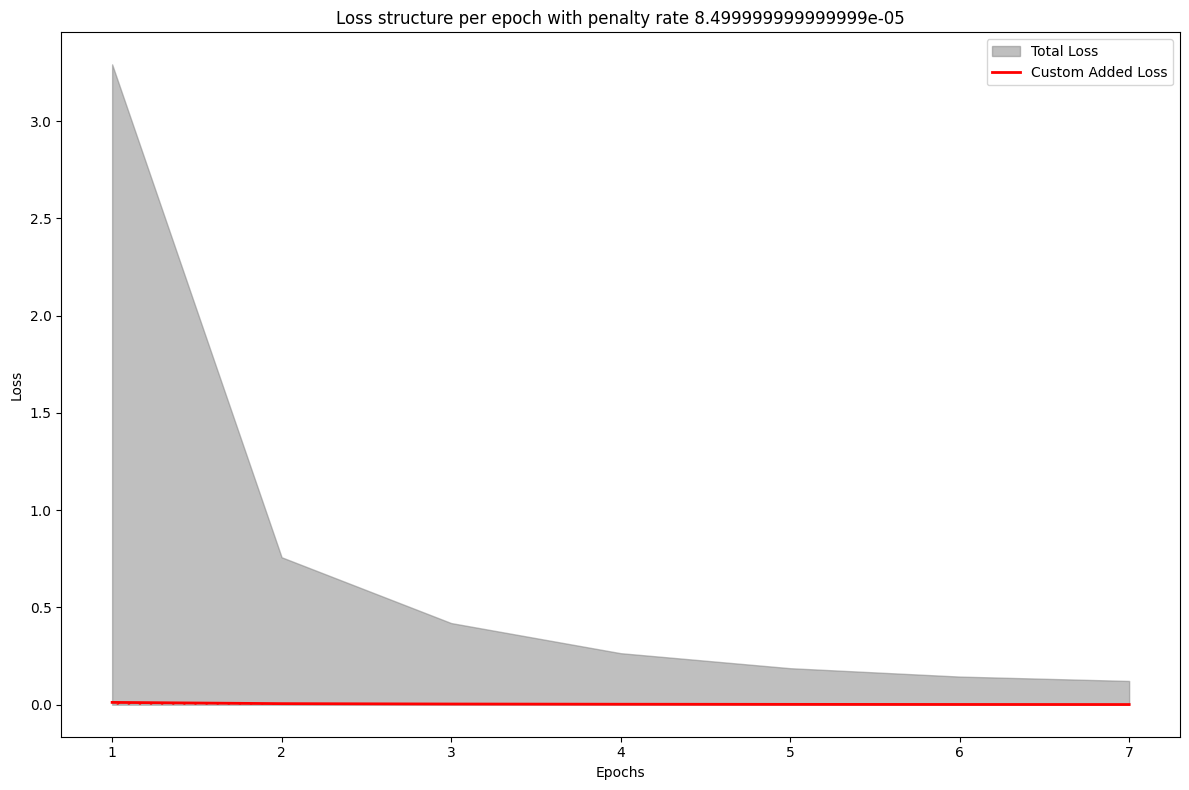


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x559822eb0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x59441ecd0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x594396d00>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x5944456a0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x5944a05b0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x5a537c7c0>
  - Input Shape: (None, 10)

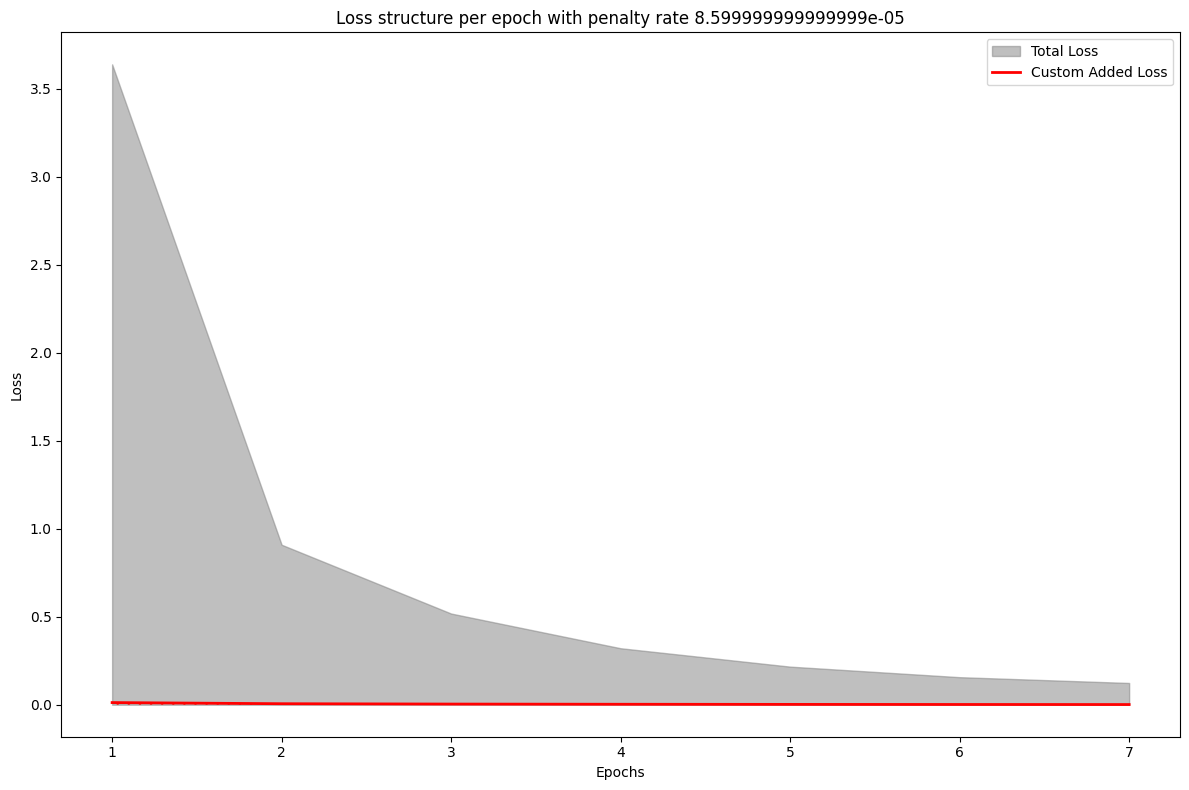


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x4547c4f10>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4540a0100>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3cd8a8f10>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3f6150880>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4f3c9d610>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x49f16f7c0>
  - Input Shape: (None, 10)

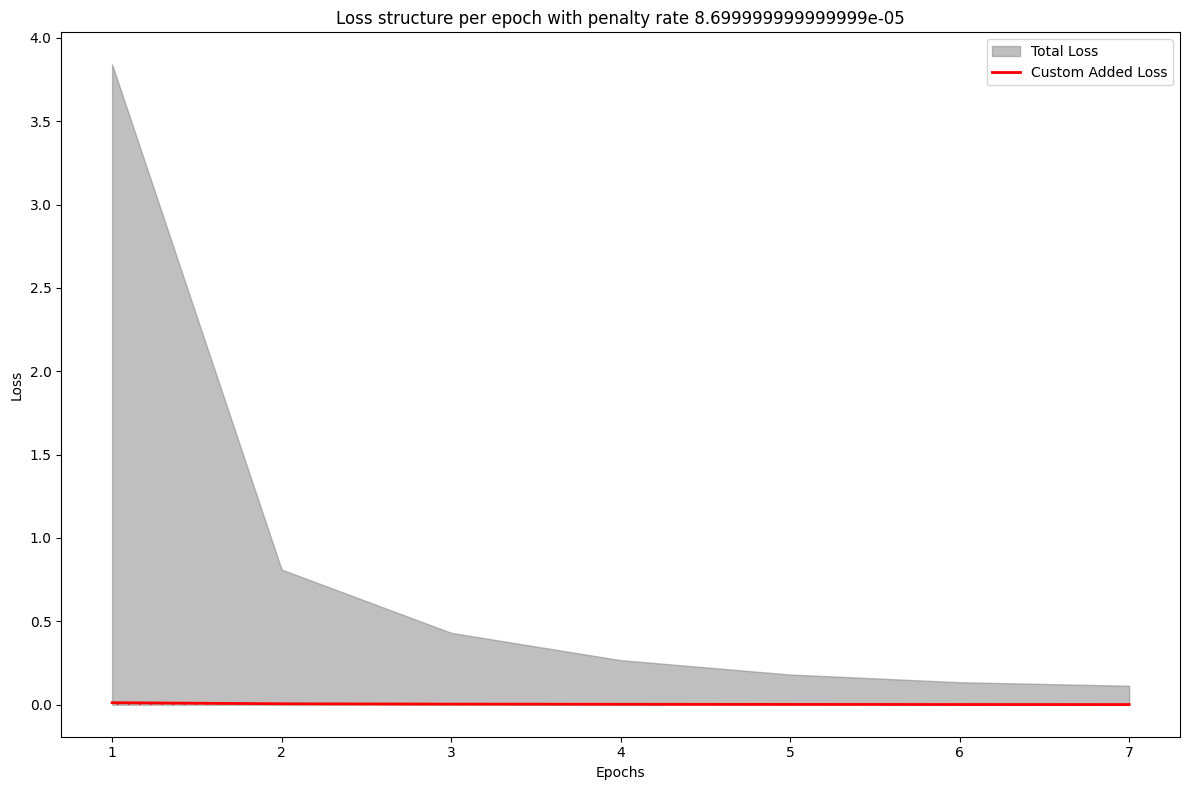


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x31aa65af0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4f3cffeb0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x4f3c8c670>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x39cac92b0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4f3c8ccd0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x542bc2910>
  - Input Shape: (None, 10)

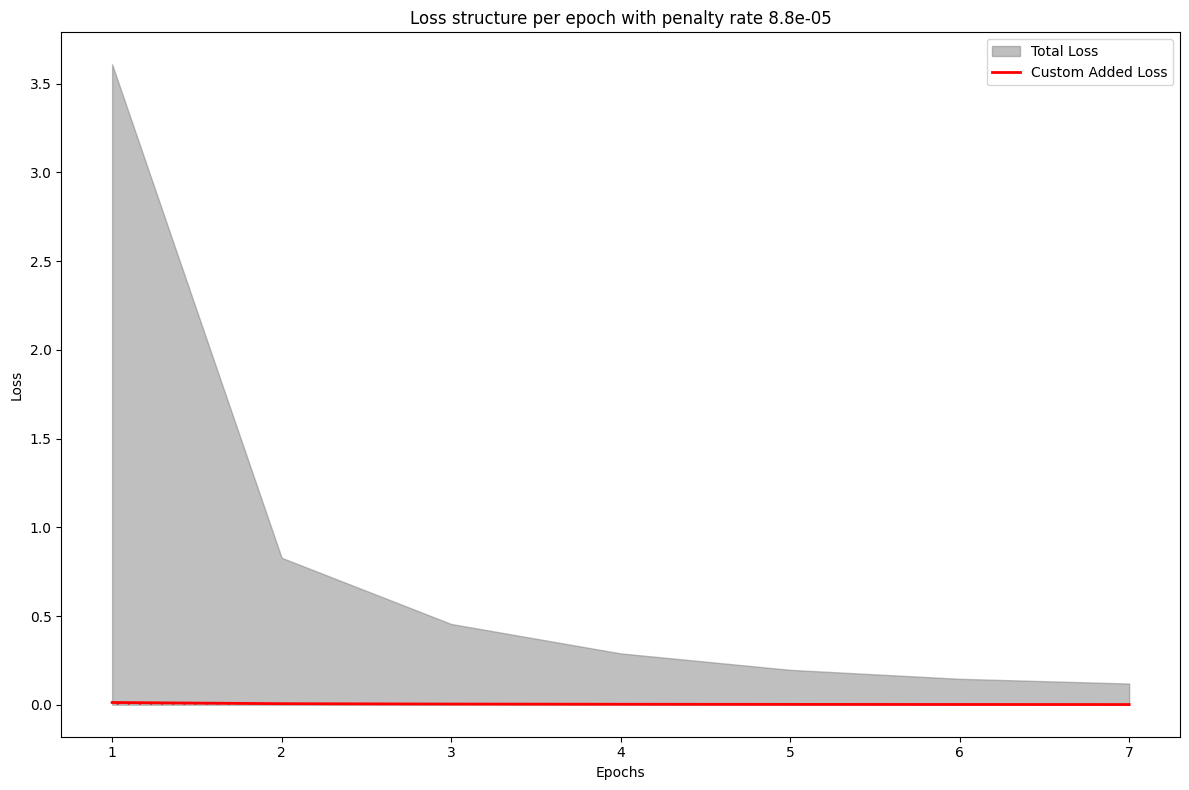


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x473331730>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x542bddc40>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x594523670>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4f3c9bbb0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4fc7469a0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x514c9baf0>
  - Input Shape: (None, 10)

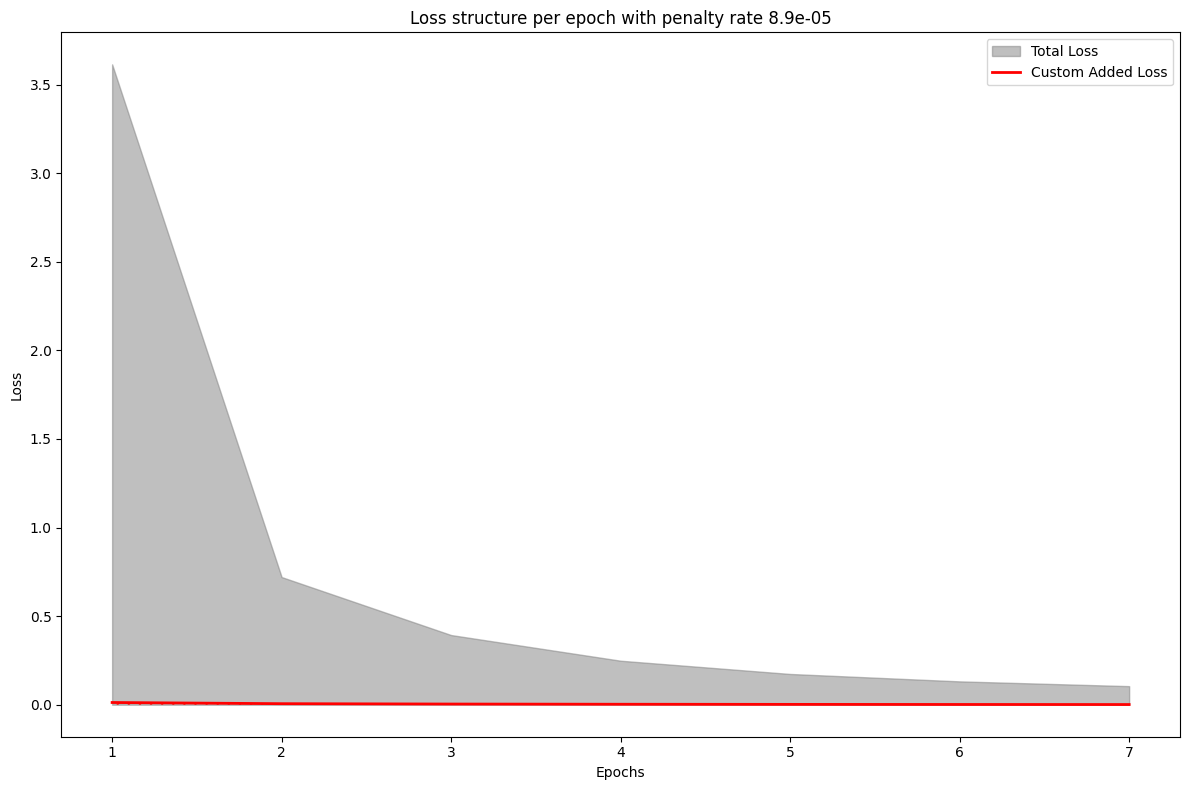


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x49f472190>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x473378e20>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x52b595730>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3febabca0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x47c70f610>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x49f445ca0>
  - Input Shape: (None, 10)

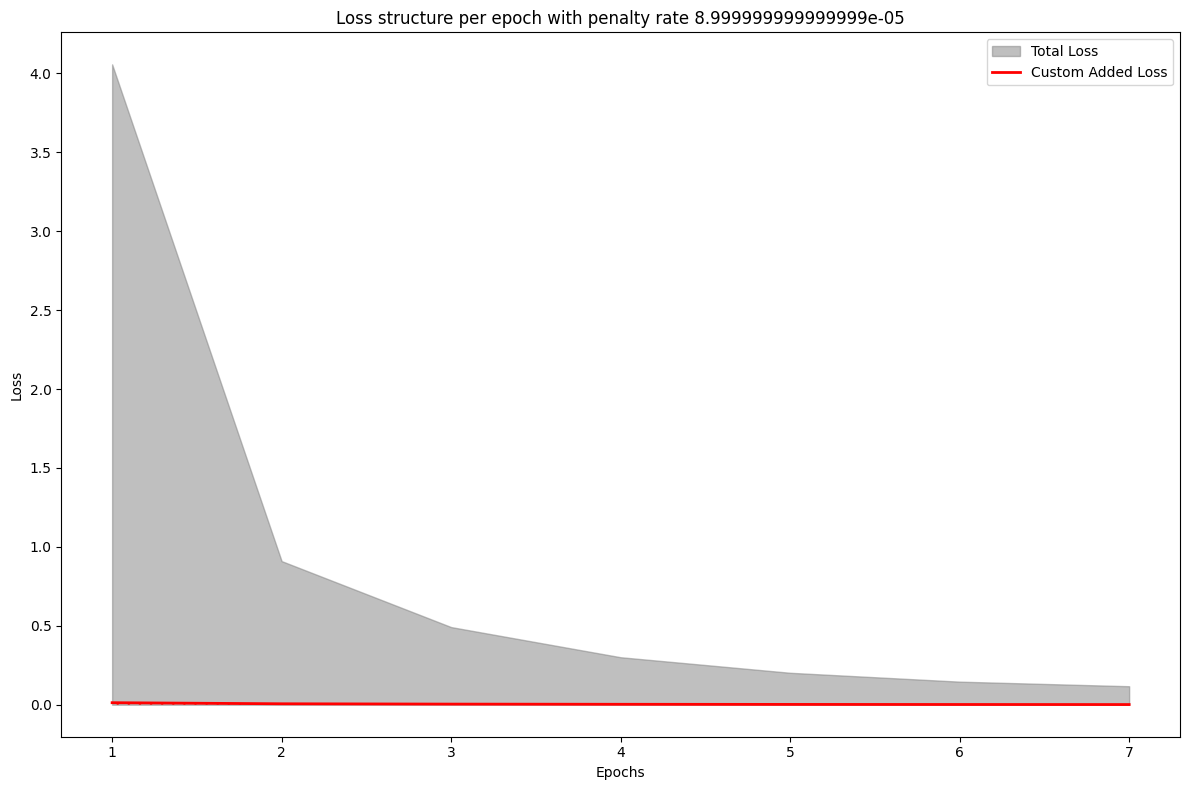


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x49dca34f0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x353047d30>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x49dca3b20>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x45ad3e730>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x34c1a5580>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4f7c31a30>
  - Input Shape: (None, 10)

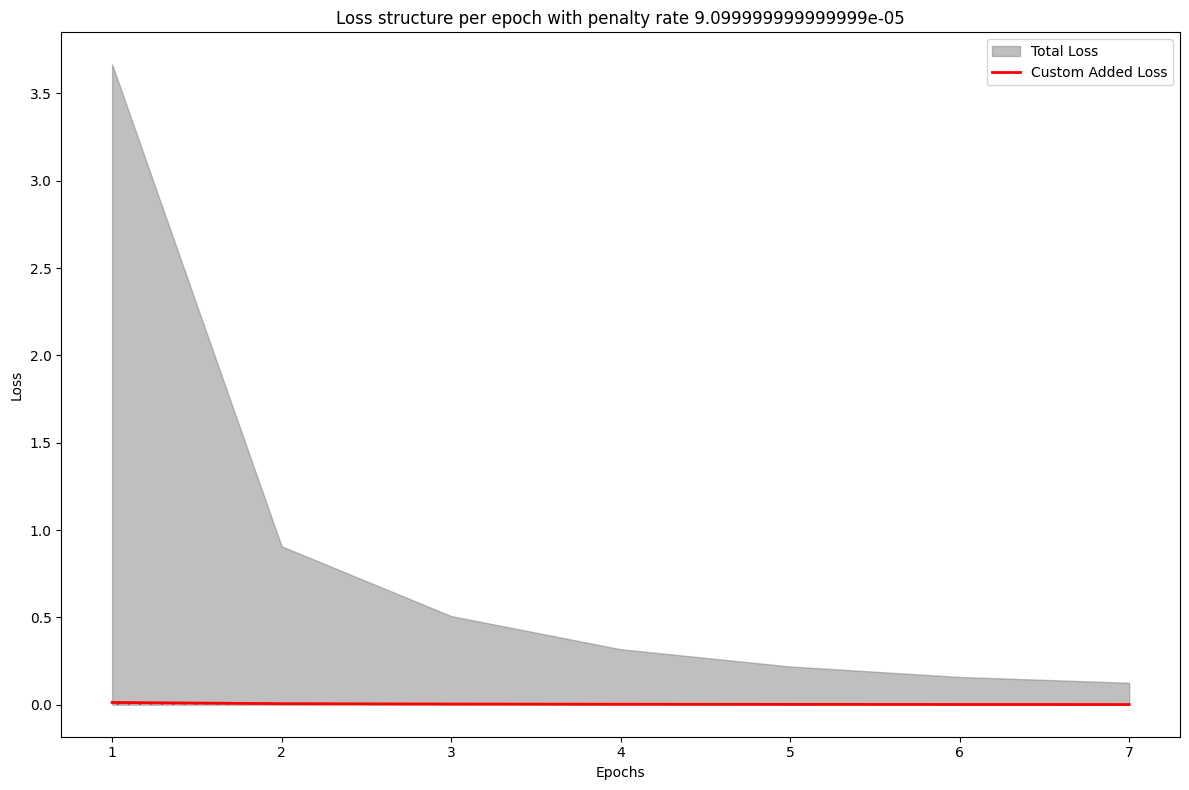


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x53414aeb0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4cd7d4c70>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x52c15fe50>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x5341bafa0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4cd7f2d30>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x52c17d610>
  - Input Shape: (None, 10)

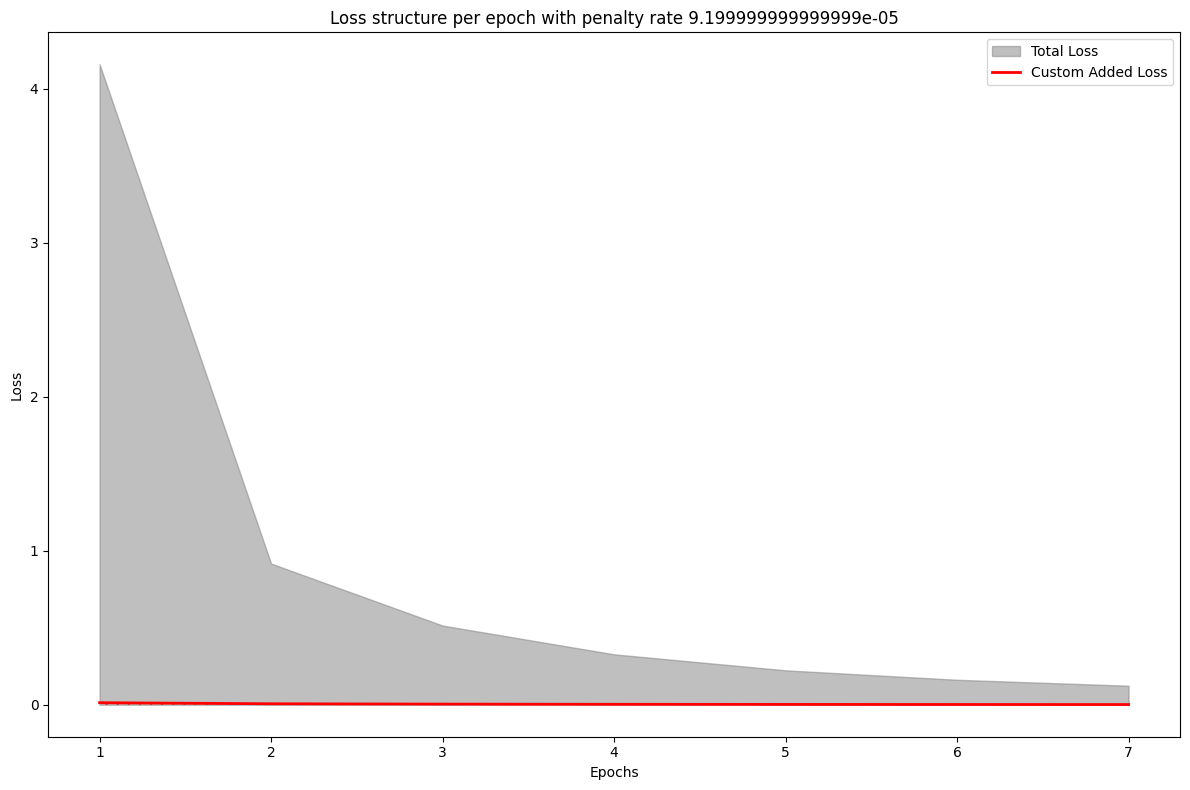


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x57b802160>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x57b8366d0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x578fcf850>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x57b8a0af0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x57b7cba60>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x57029b310>
  - Input Shape: (None, 10)

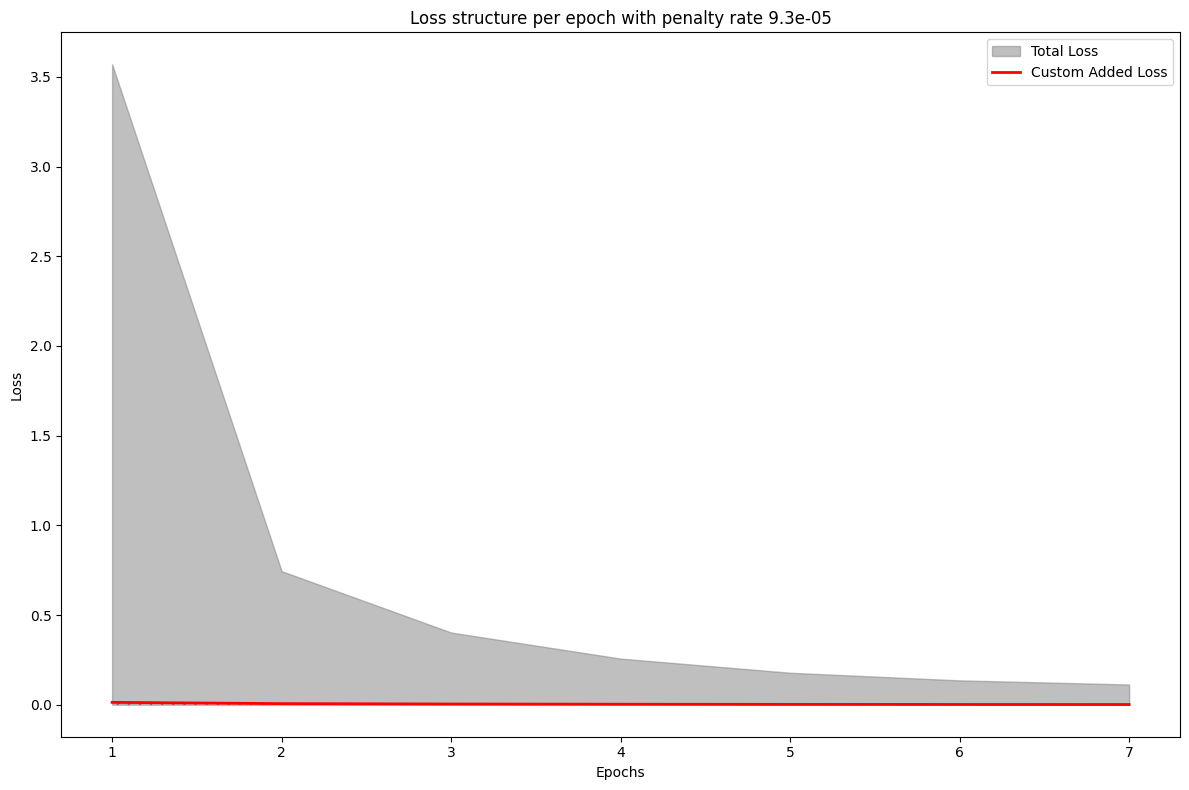


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x578fc50d0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x57b856760>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x5702739d0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x52c142700>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x52c142220>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x5a17f6040>
  - Input Shape: (None, 10)

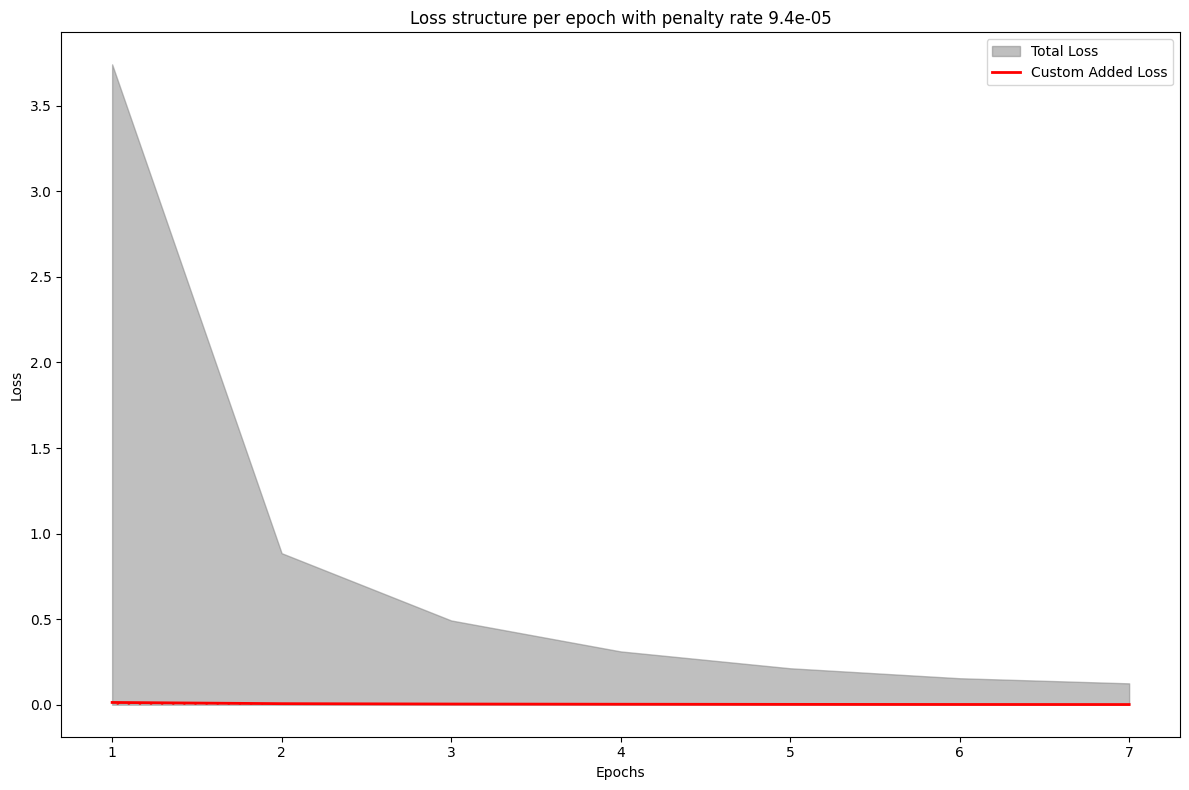


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x3ffc303d0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4547567f0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x3cd8d7430>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4cd71f2b0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x4843d6040>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x49bbbffa0>
  - Input Shape: (None, 10)

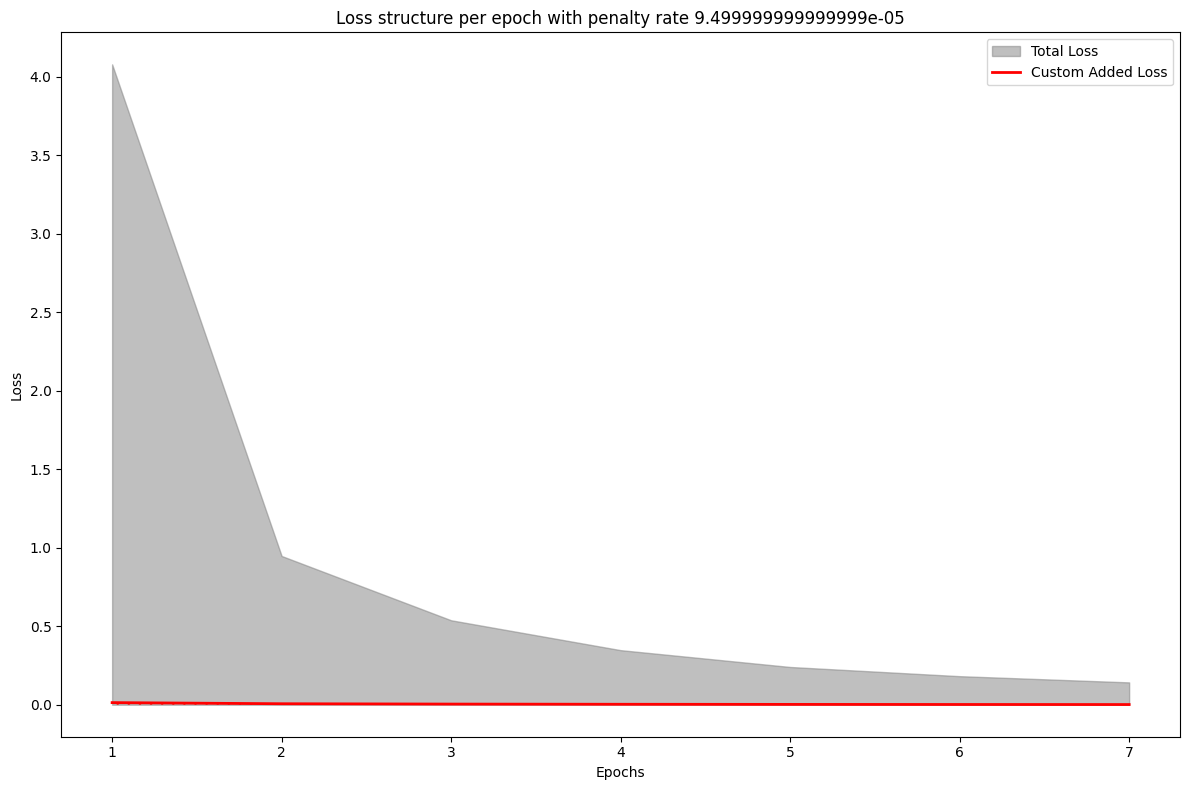


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x314b43a30>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4d6f9de50>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x31aa71280>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4a6e48a60>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x405d2f970>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x175fa17f0>
  - Input Shape: (None, 10)

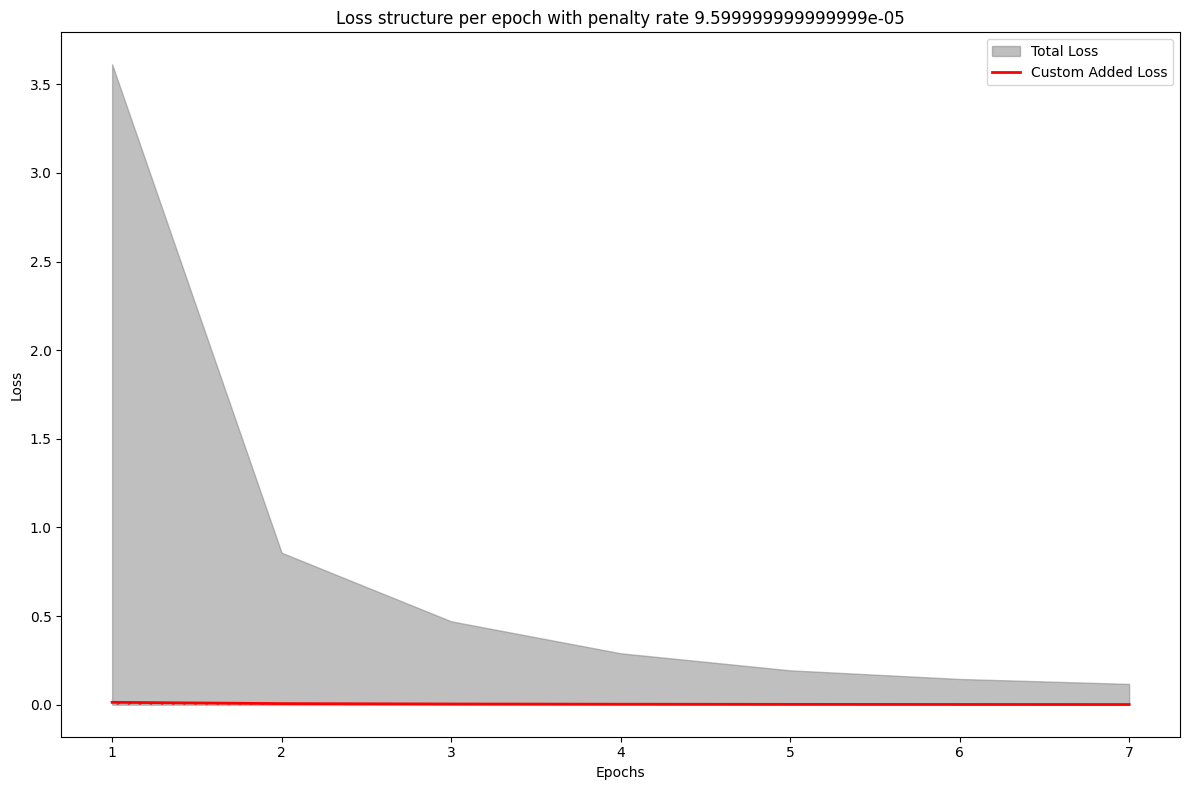


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x594574580>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4595df640>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x49dcc2a90>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x34ba059a0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x472e00400>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4ee1024f0>
  - Input Shape: (None, 10)

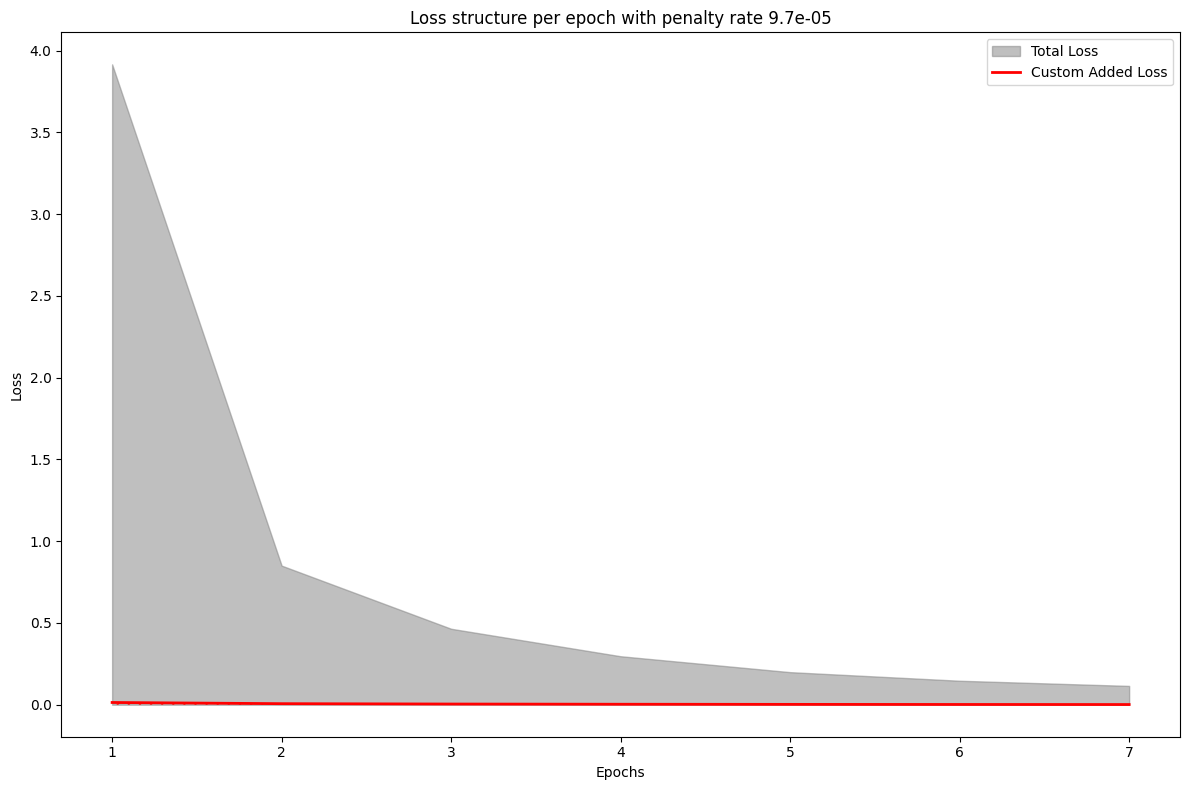


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x533e04760>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x473330160>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x47c76ca60>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4f7c84580>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x5165d3370>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x52bc6de80>
  - Input Shape: (None, 10)

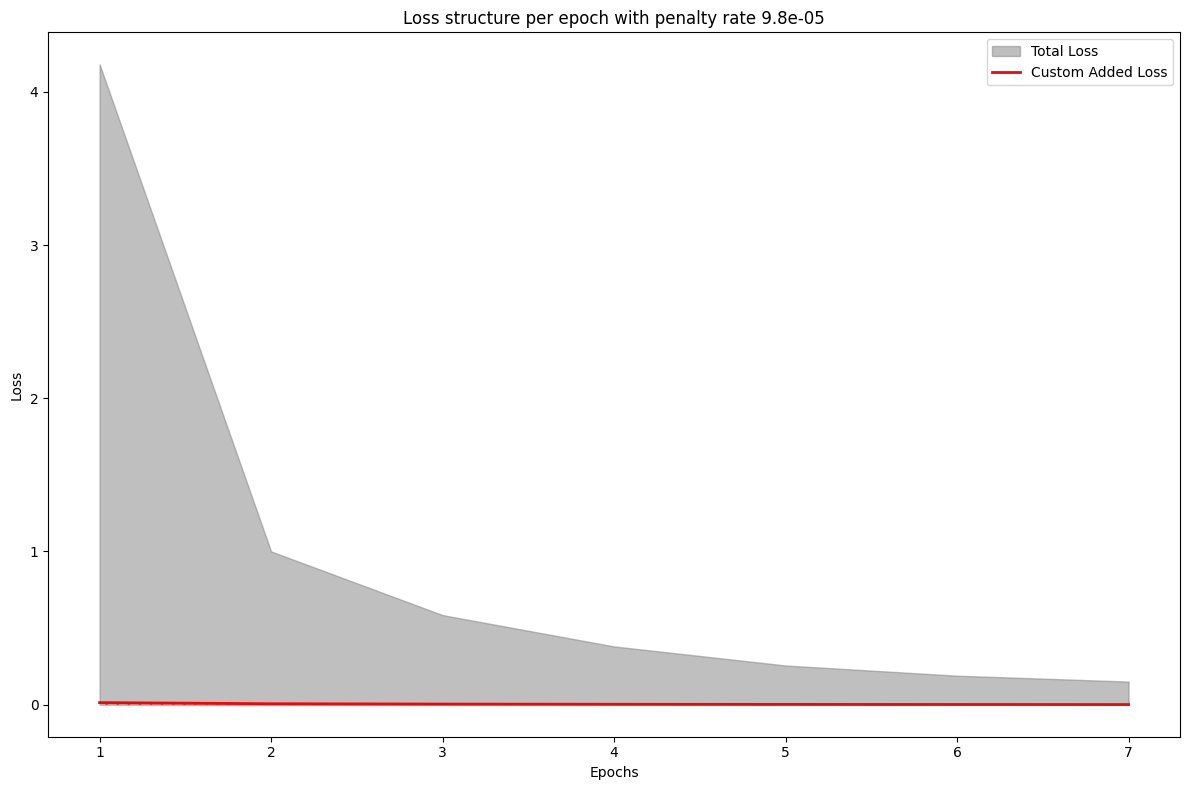


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x5c15b01c0>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x5a176b610>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x5c2a8bca0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4ed89a3d0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x5a176b8b0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x4edb92940>
  - Input Shape: (None, 10)

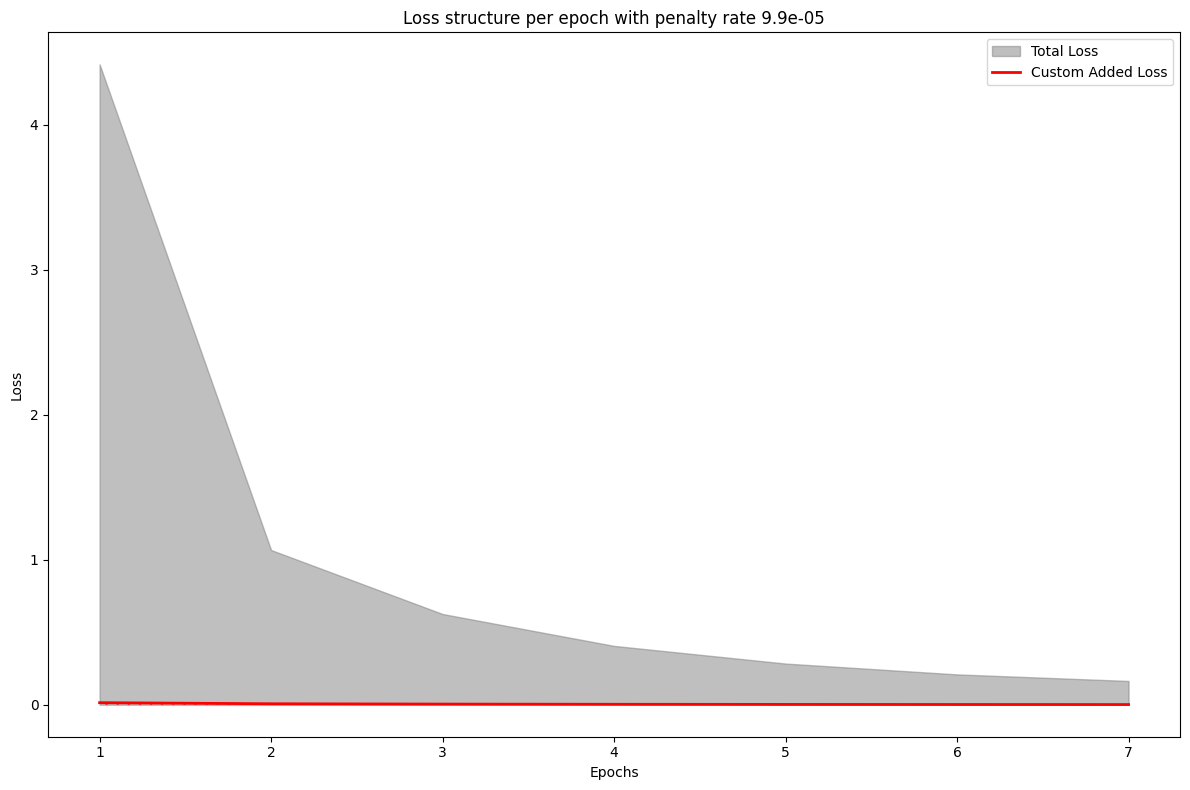


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x550ea5880>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x5511a3a00>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x4fc7155e0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x513b2e5b0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x3bb4cf3d0>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x513b2c4f0>
  - Input Shape: (None, 10)

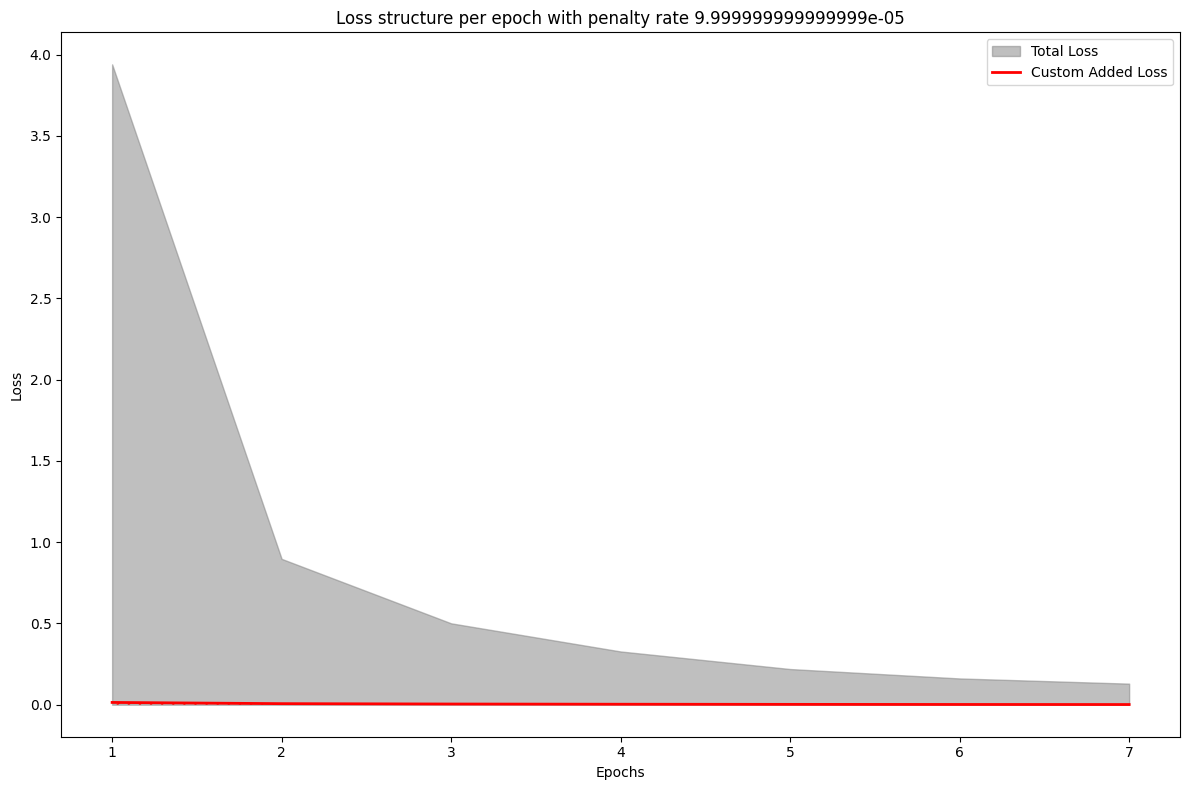

In [8]:

learning_rate = 0.0001
validation_data = (x_test, y_test)
epochs = 7
val_interval = 75
batch_size = 32
run_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

log_dirs = []

for pr in penalty_rates:
    
    quantized_model = initialize_quantized_model(input_shape=(28,28,1))

    log_dir = prepare_model_dir(model=quantized_model, penalty_rate=pr, run_timestamp = run_timestamp)
    log_dirs.append(log_dir)

    loss_function = initialize_loss_function(
        model=quantized_model, 
        penalty_rate=pr, 
        log_dir=log_dir
    )

    compile_model(
        model=quantized_model, 
        learning_rate=learning_rate, 
        loss_function=loss_function
    )

    callbacks = initialize_callbacks(
        model=quantized_model, 
        loss_function=loss_function, 
        validation_data=validation_data,
        log_dir=log_dir
    )
    
    train_model(
        model=quantized_model, 
        epochs=epochs, 
        validation_data=validation_data,
        batch_size=batch_size,
        **callbacks
    )

    accuracy = evaluate_model(model=quantized_model)
    plot_loss(log_dir, x_train_size=len(x_train), batch_size=batch_size, penalty_rate=pr)


0.12032499024823487
1.1556893550192013e-05


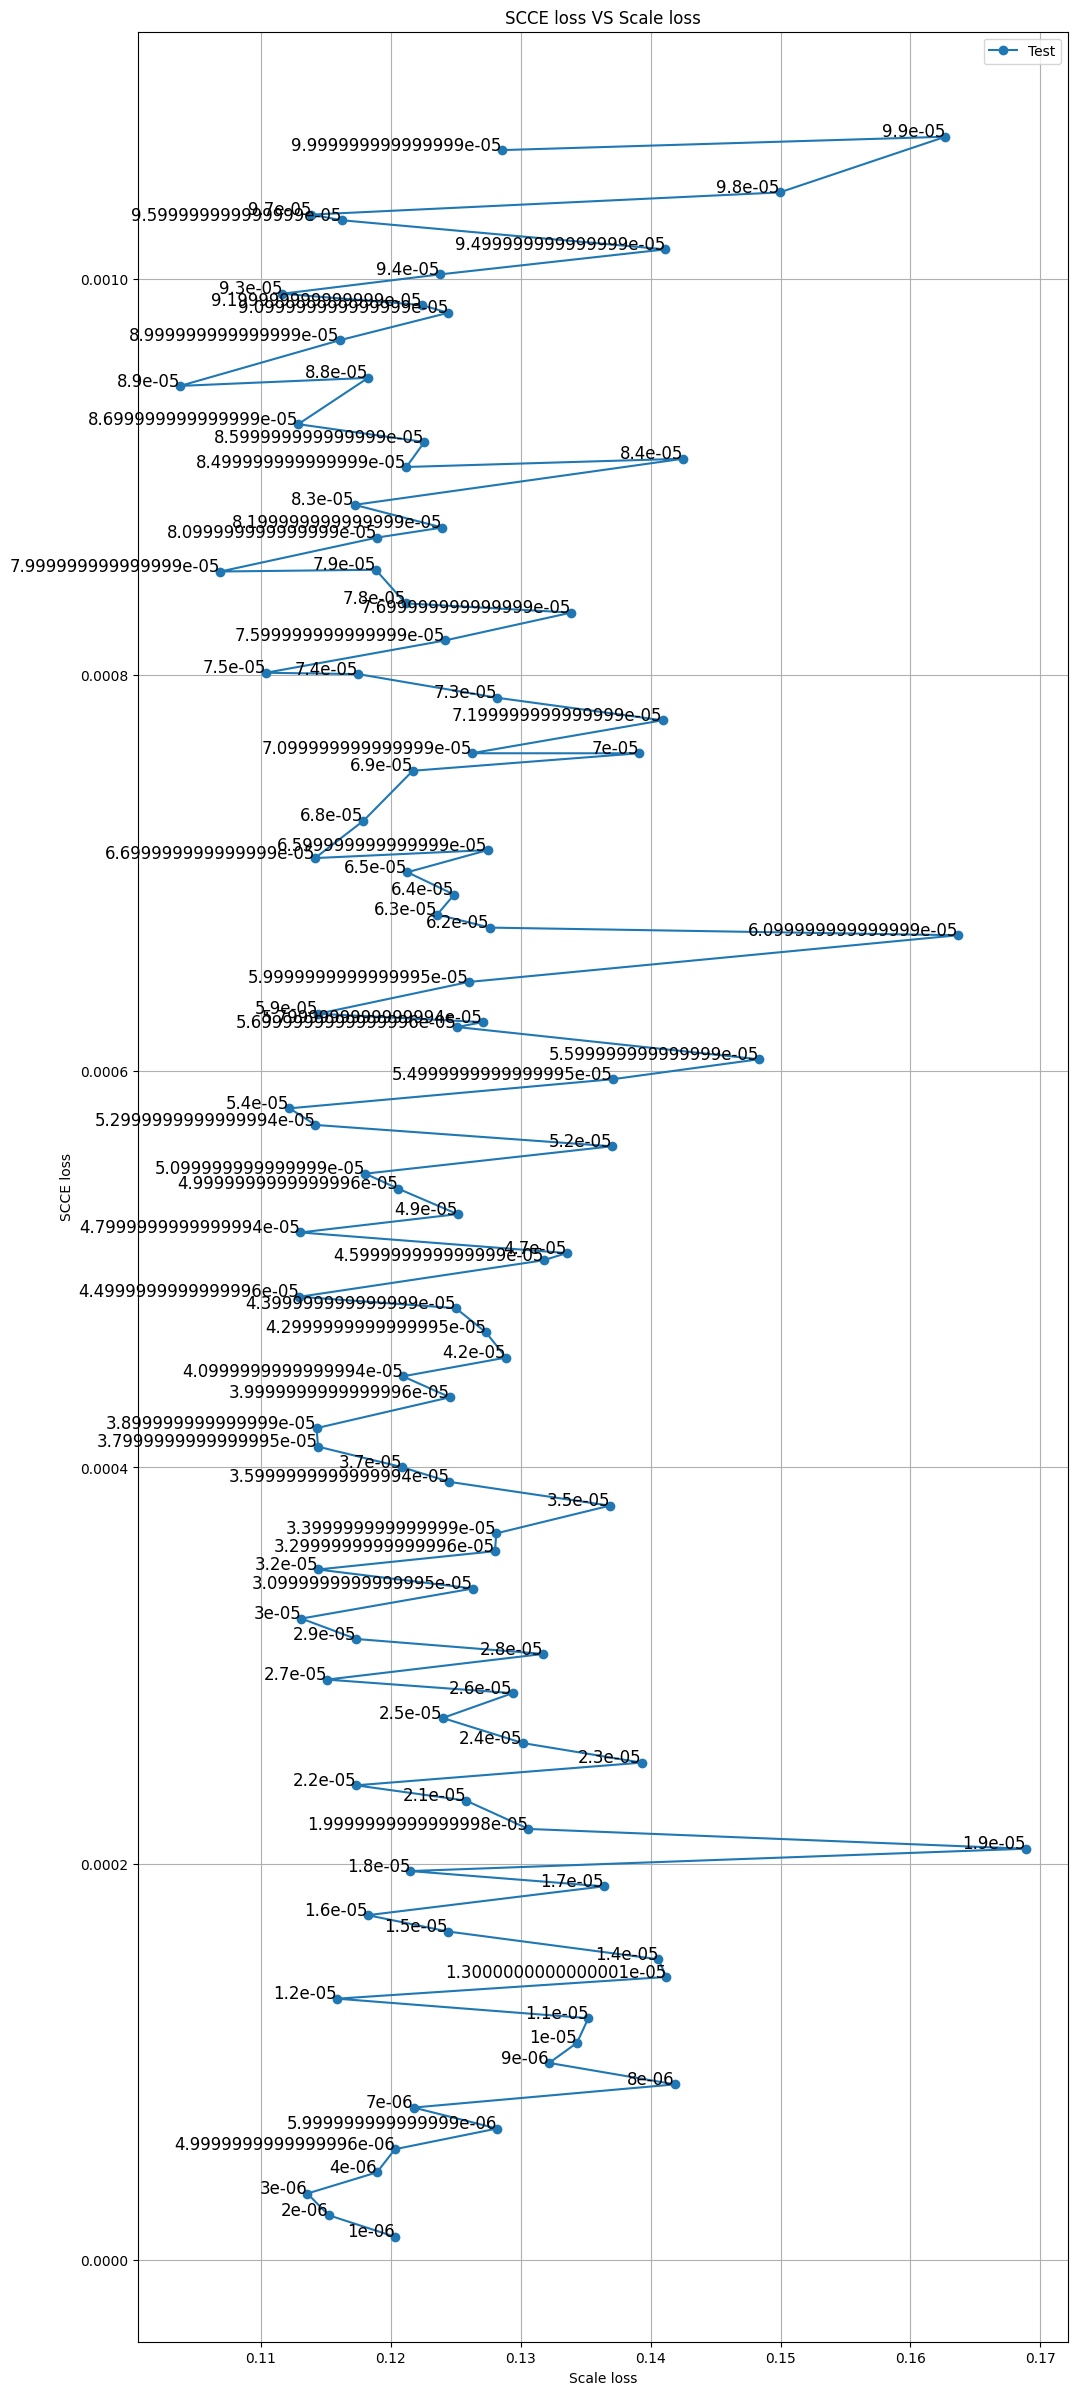

In [9]:
import matplotlib.pyplot as plt

def plot_pareto(log_dirs, penalty_rates, exclude=0):
    
    total_losses = [] # keys are epochs, list of values containts
    scale_losses = [] # keys are epochs

    for log_dir in log_dirs:
        total_loss_log_path = os.path.join(log_dir, 'losses/total_avg_log.txt')
        scale_loss_log_path = os.path.join(log_dir, 'losses/scale_avg_log.txt')

        with open(total_loss_log_path, 'r') as total_f:
            for index, line in enumerate(total_f):
                if index == 6:
                    total_losses.append(float(line.strip()))
    #                total_losses.setdefault(index, []).append(float(line.strip()))

        with open(scale_loss_log_path, 'r') as scale_f:
            for index, line in enumerate(scale_f):
                if index == 6:
                    scale_losses.append(float(line.strip()))
    #                scale_losses.setdefault(index, []).append(float(line.strip()))

    print(total_losses[0])
    print(scale_losses[0])
    scce_loss = [total - scale for total, scale in zip(total_losses, scale_losses)]

    labels = penalty_rates[:len(penalty_rates)-exclude]
    cut_scce = scce_loss[:len(penalty_rates)-exclude]
    cut_total = total_losses[:len(penalty_rates)-exclude]
    cut_scale = scale_losses[:len(penalty_rates)-exclude]

    plt.figure(figsize=(12, 30))
    plt.plot(cut_scce, cut_scale, marker='o', label=f'Test')  
    # Annotating each point with its label
    for i, label in enumerate(labels):
        plt.text(cut_scce[i], cut_scale[i], label, fontsize=12, ha='right')

    plt.ylabel('SCCE loss')
    plt.xlabel('Scale loss')
    plt.title('SCCE loss VS Scale loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pareto(log_dirs, penalty_rates)